In [1]:
import numpy as np
import pandas as pd
import scanpy as sc
%matplotlib inline
import matplotlib.pyplot as plt

import sys 
import inspect
import seaborn as sns
import os
import copy

import perturbseq as perturb

sc.settings.verbosity = 3  # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.settings.set_figure_params(dpi=80, color_map='viridis')
sc.logging.print_versions()

scanpy==1.5.1 anndata==0.7.1 umap==0.4.4 numpy==1.17.2 scipy==1.4.1 pandas==0.24.2 scikit-learn==0.22 statsmodels==0.11.0 python-igraph==0.7.1 louvain==0.6.1 leidenalg==0.8.1


In [2]:
PROTEIN='KRAS'
DATA='/ahg/regevdata/projects/bn10_cancer_variants/bn10_oana_2018-06-22/results/2018-06-22/results/2020-02-14'
SUBSAMPLED=DATA+'/'+PROTEIN+'/subsampled/A549.'+PROTEIN

counts=20000

FIGS=DATA+'/2021-03-22_Figures/'
os.system('mkdir -p '+FIGS)
print(FIGS)

sc.settings.figdir=FIGS

/ahg/regevdata/projects/bn10_cancer_variants/bn10_oana_2018-06-22/results/2018-06-22/results/2020-02-14/2021-03-22_Figures/


In [3]:
ANNO=DATA+'/'+PROTEIN+'/anno'
anno=pd.read_csv(ANNO+'/'+PROTEIN+'.anno.complete3.csv',sep='\t',index_col=0)
anno=anno.loc[anno['Library_synthesis']=='in',:]

sorted_variants_df=pd.read_csv(DATA+'/'+PROTEIN+'/clustering/'+PROTEIN+'.corrL1.sorted_variants_2021-03-23.csv',header=None)
sorted_variants_df.index=sorted_variants_df[0]
sorted_variants=list(sorted_variants_df[0])
print(sorted_variants)

print(anno.columns)


['M111L', 'T127T', 'V112I', 'R149K', 'S17S', 'T74T', 'I163S', 'G75A', 'S136N', 'K179R', 'T158A', 'T20T', 'V8V', 'A66A', 'M170L', 'D173D', 'T158T', 'A130V', 'D30D', 'K176Q', 'T144T', 'C118S', 'Y166H', 'WT', 'K88K', 'A155G', 'T50T', 'K169K', 'F141L', 'R135T', 'R164Q', 'P110S', 'K178K', 'L159S', 'L79I', 'Q25H', 'K147N', 'G77A', 'K147T', 'E63K', 'V14I', 'T50I', 'E31K', 'Q99E', 'R41K', 'T50P', 'T20R', 'Q22H', 'C185Y', 'T20M', 'T144P', 'L52F', 'T74A', 'D57N', 'unassigned', 'N26Y', 'D33E', 'L19F', 'Q61K', 'P34L', 'K5E', 'P34R', 'G60D', 'Q61P', 'G60S', 'G60V', 'R68S', 'I36M', 'T58I', 'Q22K', 'K117R', 'A59T', 'AG59GV', 'D119G', 'G12Y', 'G12F', 'V14L', 'A59E', 'G12S', 'G12A', 'A59G', 'A146V', 'G13C', 'G12C', 'A146P', 'A146T', 'G12V', 'AG11TD', 'G12D', 'G12I', 'G12R', 'Q61A', 'Q61H', 'Q61R', 'Q61L', 'G13E', 'K117N', 'G13V', 'G13R']
Index(['Variant.1', 'Variant.1.1', 'Position', 'From', 'To', 'mutation_type',
       'Count_pancan', 'Count_ExAC', 'control_status', 'control_color',
       'Library_s

In [4]:
f='/ahg/regevdata/projects/bn10_cancer_variants/bn10_oana_2018-06-22/results/2018-06-22/results/2019-06-07/KRAS/mutational_signatures/KRAS_mutationalSignatures_Andrew.txt'
mutsig=pd.read_csv(f,sep='\t')
mutsig.index=mutsig['Mutation']
print(mutsig.head())
print(mutsig.columns)

#modify the names for the synonymous ones
import re
new_vars=[]
for i in range(mutsig.shape[0]):
    v=mutsig.index[i]
    new_var_here=v
    if 'B' in v:
        new_var_here=re.sub('B',v[0],v)
    new_vars.append(new_var_here)
mutsig.index=new_vars


          Position WT AA Final AA Mutation  COSMIC  Day0 Reads  Z-Low-D7  \
Mutation                                                                   
G12D            12     G        D     G12D  Single      1756.3      7.30   
G12V            12     G        V     G12V  Single      1803.0      6.88   
G12C            12     G        C     G12C  Single      2495.7      5.55   
G13D            13     G        D     G13D  Single      3388.3      5.68   
G12A            12     G        A     G12A  Single       922.0      3.28   

          Z-Low-D14  Z-High-D7  Z-High-D14  ...  Signature_21  Signature_22  \
Mutation                                    ...                               
G12D           6.41       2.47        4.21  ...        0.0062      0.001525   
G12V           5.89       2.57        4.08  ...        0.0007      0.002451   
G12C           4.74       1.86        2.41  ...        0.0020      0.004550   
G13D           4.90       1.81        3.21  ...        0.0392      0.003

In [5]:
for c in ['Z-Low-D7','Z-Low-D14','COSMIC.1']:
    anno[c]=mutsig.loc[anno.index,c]

/ahg/regevdata/users/oursu/software/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:1017: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return getattr(section, self.name)[new_key]


In [6]:
#check which of our variants are in the Giacomelli dataset
overlapping=set(mutsig.index).intersection(set(anno.index))
print('variants in',len(overlapping))
print(overlapping)
missed=set(anno.index).difference(set(mutsig.index))
print('variants not in',len(missed))
print(missed)

variants in 94
{'Q61A', 'A66A', 'G60D', 'K169K', 'D173D', 'T158A', 'G12A', 'G12V', 'T74T', 'K147T', 'V14L', 'L52F', 'M170L', 'Q99E', 'S136N', 'S17S', 'I163S', 'Q61R', 'G60S', 'P34R', 'R149K', 'G75A', 'N26Y', 'D33E', 'G12D', 'G77A', 'P110S', 'A146V', 'G12R', 'G12F', 'T20T', 'A146P', 'M111L', 'E63K', 'R135T', 'G12Y', 'T158T', 'D119G', 'V112I', 'R68S', 'Q22H', 'T58I', 'G60V', 'R41K', 'Q22K', 'A155G', 'P34L', 'T144T', 'G13E', 'D30D', 'A59G', 'R164Q', 'F141L', 'G13V', 'Q61P', 'L79I', 'K117R', 'Q25H', 'L159S', 'A59E', 'D57N', 'I36M', 'E31K', 'T20R', 'K147N', 'C185Y', 'K88K', 'A130V', 'Q61L', 'A146T', 'T144P', 'G12S', 'Q61K', 'C118S', 'T50I', 'Q61H', 'K179R', 'V8V', 'V14I', 'G12C', 'A59T', 'K176Q', 'G13R', 'K178K', 'L19F', 'T20M', 'K5E', 'T50P', 'T74A', 'T127T', 'K117N', 'T50T', 'G12I', 'G13C'}
variants not in 4
{'AG11TD', 'AG59GV', 'WT', 'Y166H'}


In [7]:
def fun_scatter(x,y,xname='x',yname='y',width=4,height=4,corrtype='spearman',
                xlim=None,ylim=None,
                **kwargs):
    from scipy.stats import spearmanr, pearsonr
    if corrtype=='spearman':
        corr=spearmanr(x,y,nan_policy='omit')
    if corrtype=='pearson':
        corr=pearsonr(x,y)
    c,p="%.2g" % corr[0],"%.3g" % corr[1]
    fig,plots=plt.subplots(1)
    fig.set_size_inches(width,height)
    plots.scatter(x,y,**kwargs)
    plots.set_xlabel(xname)
    plots.set_ylabel(yname)
    if xlim!=None:
        plots.set_xlim(xlim)
    if ylim!=None:
        plots.set_ylim(ylim)
    plots.set_title(corrtype+':'+str(c)+'\n'+'p:'+str(p))
    


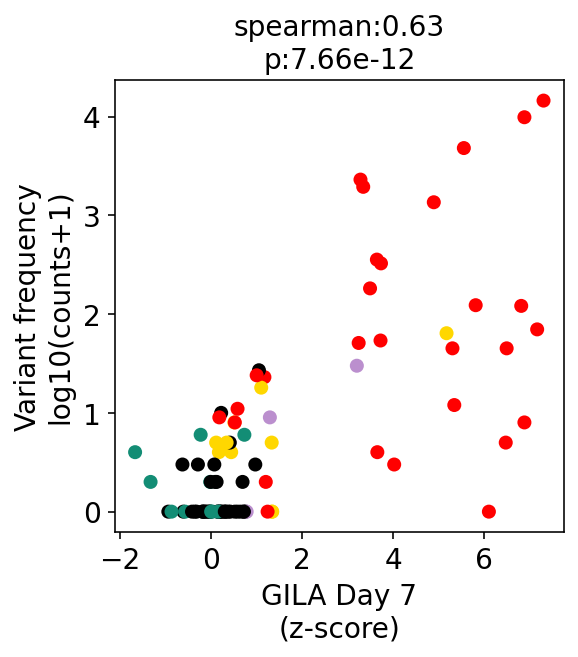

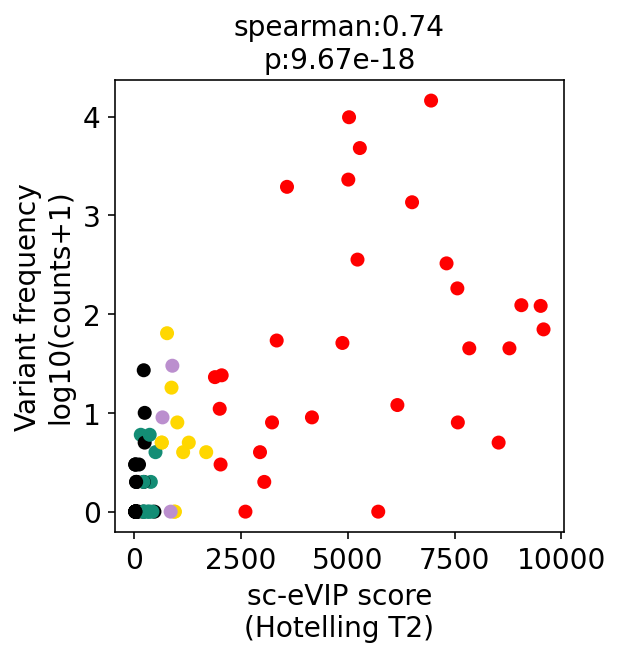

In [8]:
for f1 in ['Z-Low-D7','HotellingT2']:
    mutcount='COSMIC.1'
    fun_scatter(anno.loc[overlapping,f1],
                np.log10(anno.loc[overlapping,mutcount]+1),
               color=anno.loc[overlapping,'cluster_color'],
                xname=f1,yname='log counts',corrtype='spearman')
    plt.grid(False)
    
    plt.ylabel('Variant frequency\nlog10(counts+1)')
    if f1=='HotellingT2':
        plt.xlabel('sc-eVIP score\n(Hotelling T2)')
    if f1=='Z-Low-D7':
        plt.xlabel('GILA Day 7\n(z-score)')
    
    plt.savefig(FIGS+'/'+PROTEIN+'.'+f1+'_vs_mutfreq.pdf',bbox_inches = "tight") 
    plt.savefig(FIGS+'/'+PROTEIN+'.'+f1+'_vs_mutfreq.png',bbox_inches = "tight")
    plt.show()

In [9]:
#restrict to variants with features. excludes synonymous variants
f='/ahg/regevdata/projects/bn10_cancer_variants/bn10_oana_2018-06-22/results/2018-06-22/results/2019-06-07/KRAS/mutational_signatures/KRAS_mutationalSignatures_Andrew.txt'
mutsig_init=pd.read_csv(f,sep='\t')
mutsig_init.index=mutsig_init['Mutation']
mutsig_restricted=mutsig_init.dropna(axis='index')####### remove items without mutational signatures

print(mutsig_restricted.head())
print(mutsig_restricted.shape)


          Position WT AA Final AA Mutation  COSMIC  Day0 Reads  Z-Low-D7  \
Mutation                                                                   
G12D            12     G        D     G12D  Single      1756.3      7.30   
G12V            12     G        V     G12V  Single      1803.0      6.88   
G12C            12     G        C     G12C  Single      2495.7      5.55   
G13D            13     G        D     G13D  Single      3388.3      5.68   
G12A            12     G        A     G12A  Single       922.0      3.28   

          Z-Low-D14  Z-High-D7  Z-High-D14  ...  Signature_21  Signature_22  \
Mutation                                    ...                               
G12D           6.41       2.47        4.21  ...        0.0062      0.001525   
G12V           5.89       2.57        4.08  ...        0.0007      0.002451   
G12C           4.74       1.86        2.41  ...        0.0020      0.004550   
G13D           4.90       1.81        3.21  ...        0.0392      0.003

Data for the model
===

Keep only variants with mutational signatures annotated. That removed the synonymous variants.

In [10]:
#define data
data=pd.DataFrame(mutsig_restricted)
# need to add HotellingT2
data['HotellingT2']=anno.loc[data.index,'HotellingT2']

#check which of our variants are in the Giacomelli dataset
overlapping=set(mutsig_restricted.index).intersection(set(anno.index))
print('variants in',len(overlapping))
print(overlapping)
missed=set(anno.index).difference(set(mutsig_restricted.index))
print('variants not in',len(missed))
print(missed)

data['has_effsize']=False
data.loc[list(overlapping),'has_effsize']=True

print('Data',data.columns)
print(data.shape)

#keep only thozs with non-zero counts
data=data.loc[data['COSMIC.1']>0,:]
print(data.shape)

variants in 89
{'A66A', 'G60D', 'K169K', 'D173D', 'T158A', 'G12A', 'G12V', 'T74T', 'K147T', 'V14L', 'L52F', 'M170L', 'Q99E', 'S136N', 'S17S', 'I163S', 'Q61R', 'G60S', 'P34R', 'R149K', 'G75A', 'N26Y', 'D33E', 'G12D', 'G77A', 'P110S', 'A146V', 'G12R', 'T20T', 'A146P', 'M111L', 'E63K', 'R135T', 'T158T', 'D119G', 'V112I', 'R68S', 'Q22H', 'T58I', 'G60V', 'R41K', 'Q22K', 'A155G', 'P34L', 'T144T', 'D30D', 'A59G', 'R164Q', 'F141L', 'G13V', 'Q61P', 'L79I', 'K117R', 'Q25H', 'L159S', 'A59E', 'D57N', 'I36M', 'E31K', 'T20R', 'K147N', 'C185Y', 'K88K', 'A130V', 'Q61L', 'A146T', 'T144P', 'G12S', 'Q61K', 'C118S', 'T50I', 'Q61H', 'K179R', 'V8V', 'V14I', 'G12C', 'A59T', 'K176Q', 'G13R', 'K178K', 'L19F', 'T20M', 'K5E', 'T50P', 'T74A', 'T127T', 'K117N', 'T50T', 'G13C'}
variants not in 9
{'Q61A', 'WT', 'G13E', 'G12F', 'G12Y', 'AG59GV', 'G12I', 'AG11TD', 'Y166H'}
Data Index(['Position', 'WT AA', 'Final AA', 'Mutation', 'COSMIC', 'Day0 Reads',
       'Z-Low-D7', 'Z-Low-D14', 'Z-High-D7', 'Z-High-D14', 'Theta-

/ahg/regevdata/users/oursu/software/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:1017: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return getattr(section, self.name)[new_key]


In [11]:
data.shape

(166, 50)

In [12]:
mutsig_restricted.shape

(1292, 50)

/ahg/regevdata/users/oursu/software/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:1017: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return getattr(section, self.name)[new_key]


====got it AG59GV
====got it G12Y
====got it G12F
====got it AG11TD
====got it G12I
====got it Q61A
====got it G13E
[<matplotlib.lines.Line2D object at 0x2b86016534e0>, <matplotlib.lines.Line2D object at 0x2b8603c6e400>] [0.0, 40.0]


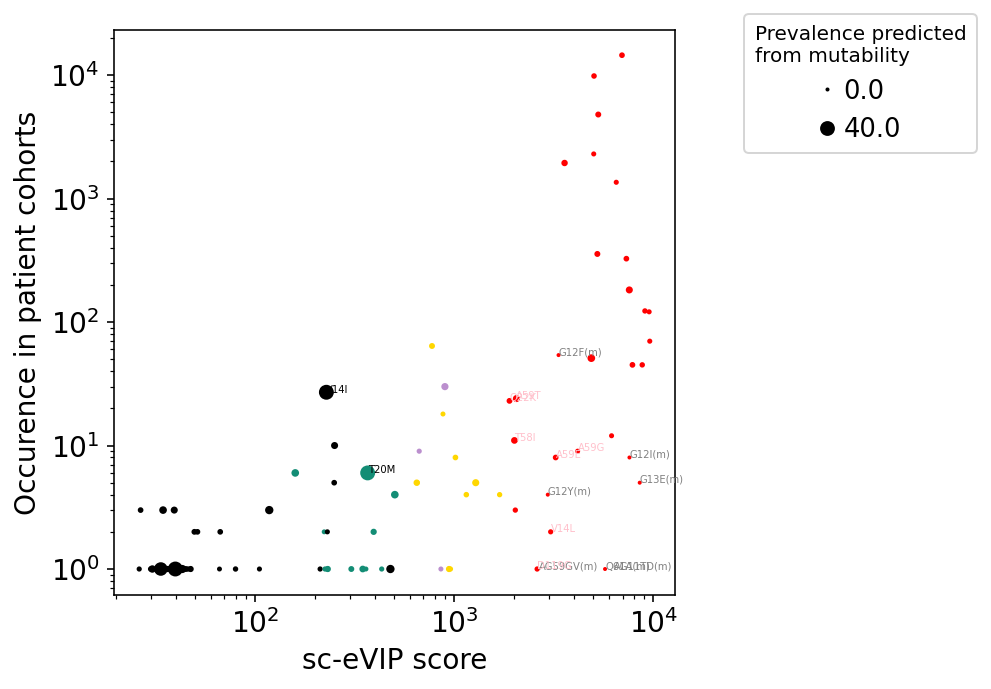

In [58]:
fold=0
foldname='fold'+str(fold)
preds=pd.read_csv(DATA+'/mutfreq/KRAS.predictedFromTP53.'+foldname+'.pred.csv',
                     sep=' ')
preds.index=list(preds['Mutation'])
preds=preds.loc[:,['Mutation','predicted.mutonly.response']]
preds.loc['AG59GV',:]=['AG59GV',0]
preds.loc['AG11TD',:]=['AG11TD',0]
present_variants=list(set(sorted_variants).intersection(set(preds.index)))

preds.loc[present_variants,'predicted.mutonly.response']=preds.loc[present_variants,'predicted.mutonly.response'].fillna(0)


anno.loc['unassigned','cluster_color']='slateblue'
fig,plots=plt.subplots()
fig.set_size_inches(5,5)
scatter_output=plots.scatter(anno.loc[present_variants,'HotellingT2'],
           mutsig.loc[present_variants,'COSMIC.1']+1,
           s=preds.loc[present_variants,'predicted.mutonly.response']+1,
              c=anno.loc[present_variants,'cluster_color'],
              vmax=20,cmap='viridis')

plots.grid(False)
plots.set_yscale('log')
plots.set_xscale('log')
#plots.set_xlim(0,100)
plots.set_xlabel('sc-eVIP score')
plots.set_ylabel('Occurence in patient cohorts')
plots.grid(False)
for i, txt in enumerate(sorted_variants):
    #print(txt)
    if anno.loc[sorted_variants,'mutation_type'][i]=='Multiple':
        if txt=='Q61P':
            continue
        print('====got it',txt)
        plots.annotate(txt+'(m)', (anno.loc[sorted_variants,'HotellingT2'][i], 
                             mutsig.loc[sorted_variants,'COSMIC.1'][i]+1),
                       fontsize=5,color='gray')
        if txt not in mutsig.index:
            plots.annotate(txt+'(m)', (anno.loc[sorted_variants,'HotellingT2'][i], 
                             1),
                       fontsize=5,color='gray')
    if txt in ['Q22K', 'A59G','A59E','A59T', 'T58I', 'V14L', 'D119G']:
        plots.annotate(txt, (anno.loc[sorted_variants,'HotellingT2'][i], 
                             mutsig.loc[sorted_variants,'COSMIC.1'][i]+1),
                       fontsize=5,color='pink')
        
    if txt in ['V14I','T20M']:
        plots.annotate(txt, (anno.loc[sorted_variants,'HotellingT2'][i], 
                             mutsig.loc[sorted_variants,'COSMIC.1'][i]+1),
                       fontsize=5,color='black')
        
            

plots.set_yscale('log')
#plots.set_xscale('log')

handles, labels = scatter_output.legend_elements(prop="sizes", num=40)
labels2=[]
import re
for i in range(len(labels)):
    i_num=float(re.sub('\$\\\\mathdefault{','',re.sub('}\$','',labels[i])))
    labels2.append(i_num-1)
min_size=labels2[0]
max_size=labels2[len(labels2)-1]
min_handle=handles[0]
labels_ends=[min_size,max_size]
handles_ends=[handles[0],handles[len(handles)-1]]
print(handles_ends, labels_ends)

legend2 = plots.legend(handles_ends, labels_ends, #loc="upper left", 
                          title="Prevalence predicted\nfrom mutability",
                       bbox_to_anchor=(1.1, 1.05))


plt.savefig(FIGS+'/'+PROTEIN+'.EffectSize_vs_mutfreq.pdf',bbox_inches = "tight") 
plt.savefig(FIGS+'/'+PROTEIN+'.EffectSize_vs_mutfreq.png',bbox_inches = "tight")



In [60]:
fold=0
foldname='fold'+str(fold)
preds=pd.read_csv(DATA+'/mutfreq/KRAS.predictedFromTP53.'+foldname+'.pred.csv',
                     sep=' ')
preds.index=list(preds['Mutation'])

data['mutational_signature_score']=preds.loc[data.index,'predicted.mutonly.terms']

In [61]:
data['GILA_day7']=data['Z-Low-D7']
data['GILA_day14']=data['Z-Low-D14']

In [62]:
#make the data for all the individual models

def get_positions_train_valid(data_pos,rng):
    
    positions=list(set(data_pos))
    train_positions=rng.choice(positions,size=int(len(positions)/2),replace=False)
    
    train_col=[]
    for j in range(len(data_pos)):
        curr_pos=data_pos[j]
        if curr_pos in train_positions:
            train_col.append(True)
        else:
            train_col.append(False)
    return(train_col)



for i in range(10):
    print('=============== iteration',i)
    #define train, validation sets
    #==============================
    #randomize train/test - by position
    foldname='fold'+str(i)
    rng=np.random.RandomState(i)
    data[foldname]=get_positions_train_valid(copy.deepcopy(data['Position']),rng)
    data[foldname+'not']=(data[foldname]==False)
    
    #x=list(set(data.loc[data[foldname+'not'],'Position']))
    #x.sort()
    #print(x)
    
    
    
    data['train'+foldname]=np.multiply(data['has_effsize'],data[foldname])
    data['valid'+foldname]=np.multiply(data['has_effsize'],data[foldname+'not'])
    data.to_csv(DATA+'/mutfreq/KRAS.model_comparison.'+foldname+'.csv')
    print(DATA+'/mutfreq/KRAS.model_comparison.'+foldname+'.csv')

=============== iteration 0
/ahg/regevdata/projects/bn10_cancer_variants/bn10_oana_2018-06-22/results/2018-06-22/results/2020-02-14/mutfreq/KRAS.model_comparison.fold0.csv
=============== iteration 1
/ahg/regevdata/projects/bn10_cancer_variants/bn10_oana_2018-06-22/results/2018-06-22/results/2020-02-14/mutfreq/KRAS.model_comparison.fold1.csv
=============== iteration 2
/ahg/regevdata/projects/bn10_cancer_variants/bn10_oana_2018-06-22/results/2018-06-22/results/2020-02-14/mutfreq/KRAS.model_comparison.fold2.csv
=============== iteration 3
/ahg/regevdata/projects/bn10_cancer_variants/bn10_oana_2018-06-22/results/2018-06-22/results/2020-02-14/mutfreq/KRAS.model_comparison.fold3.csv
=============== iteration 4
/ahg/regevdata/projects/bn10_cancer_variants/bn10_oana_2018-06-22/results/2018-06-22/results/2020-02-14/mutfreq/KRAS.model_comparison.fold4.csv
=============== iteration 5
/ahg/regevdata/projects/bn10_cancer_variants/bn10_oana_2018-06-22/results/2018-06-22/results/2020-02-14/mutfreq/

=============== iteration 0
=============== iteration 1
=============== iteration 2
=============== iteration 3
=============== iteration 4
=============== iteration 5
=============== iteration 6
=============== iteration 7
=============== iteration 8
=============== iteration 9


Text(0.1, 0.5, 'predicted\nlog10(1+counts)')

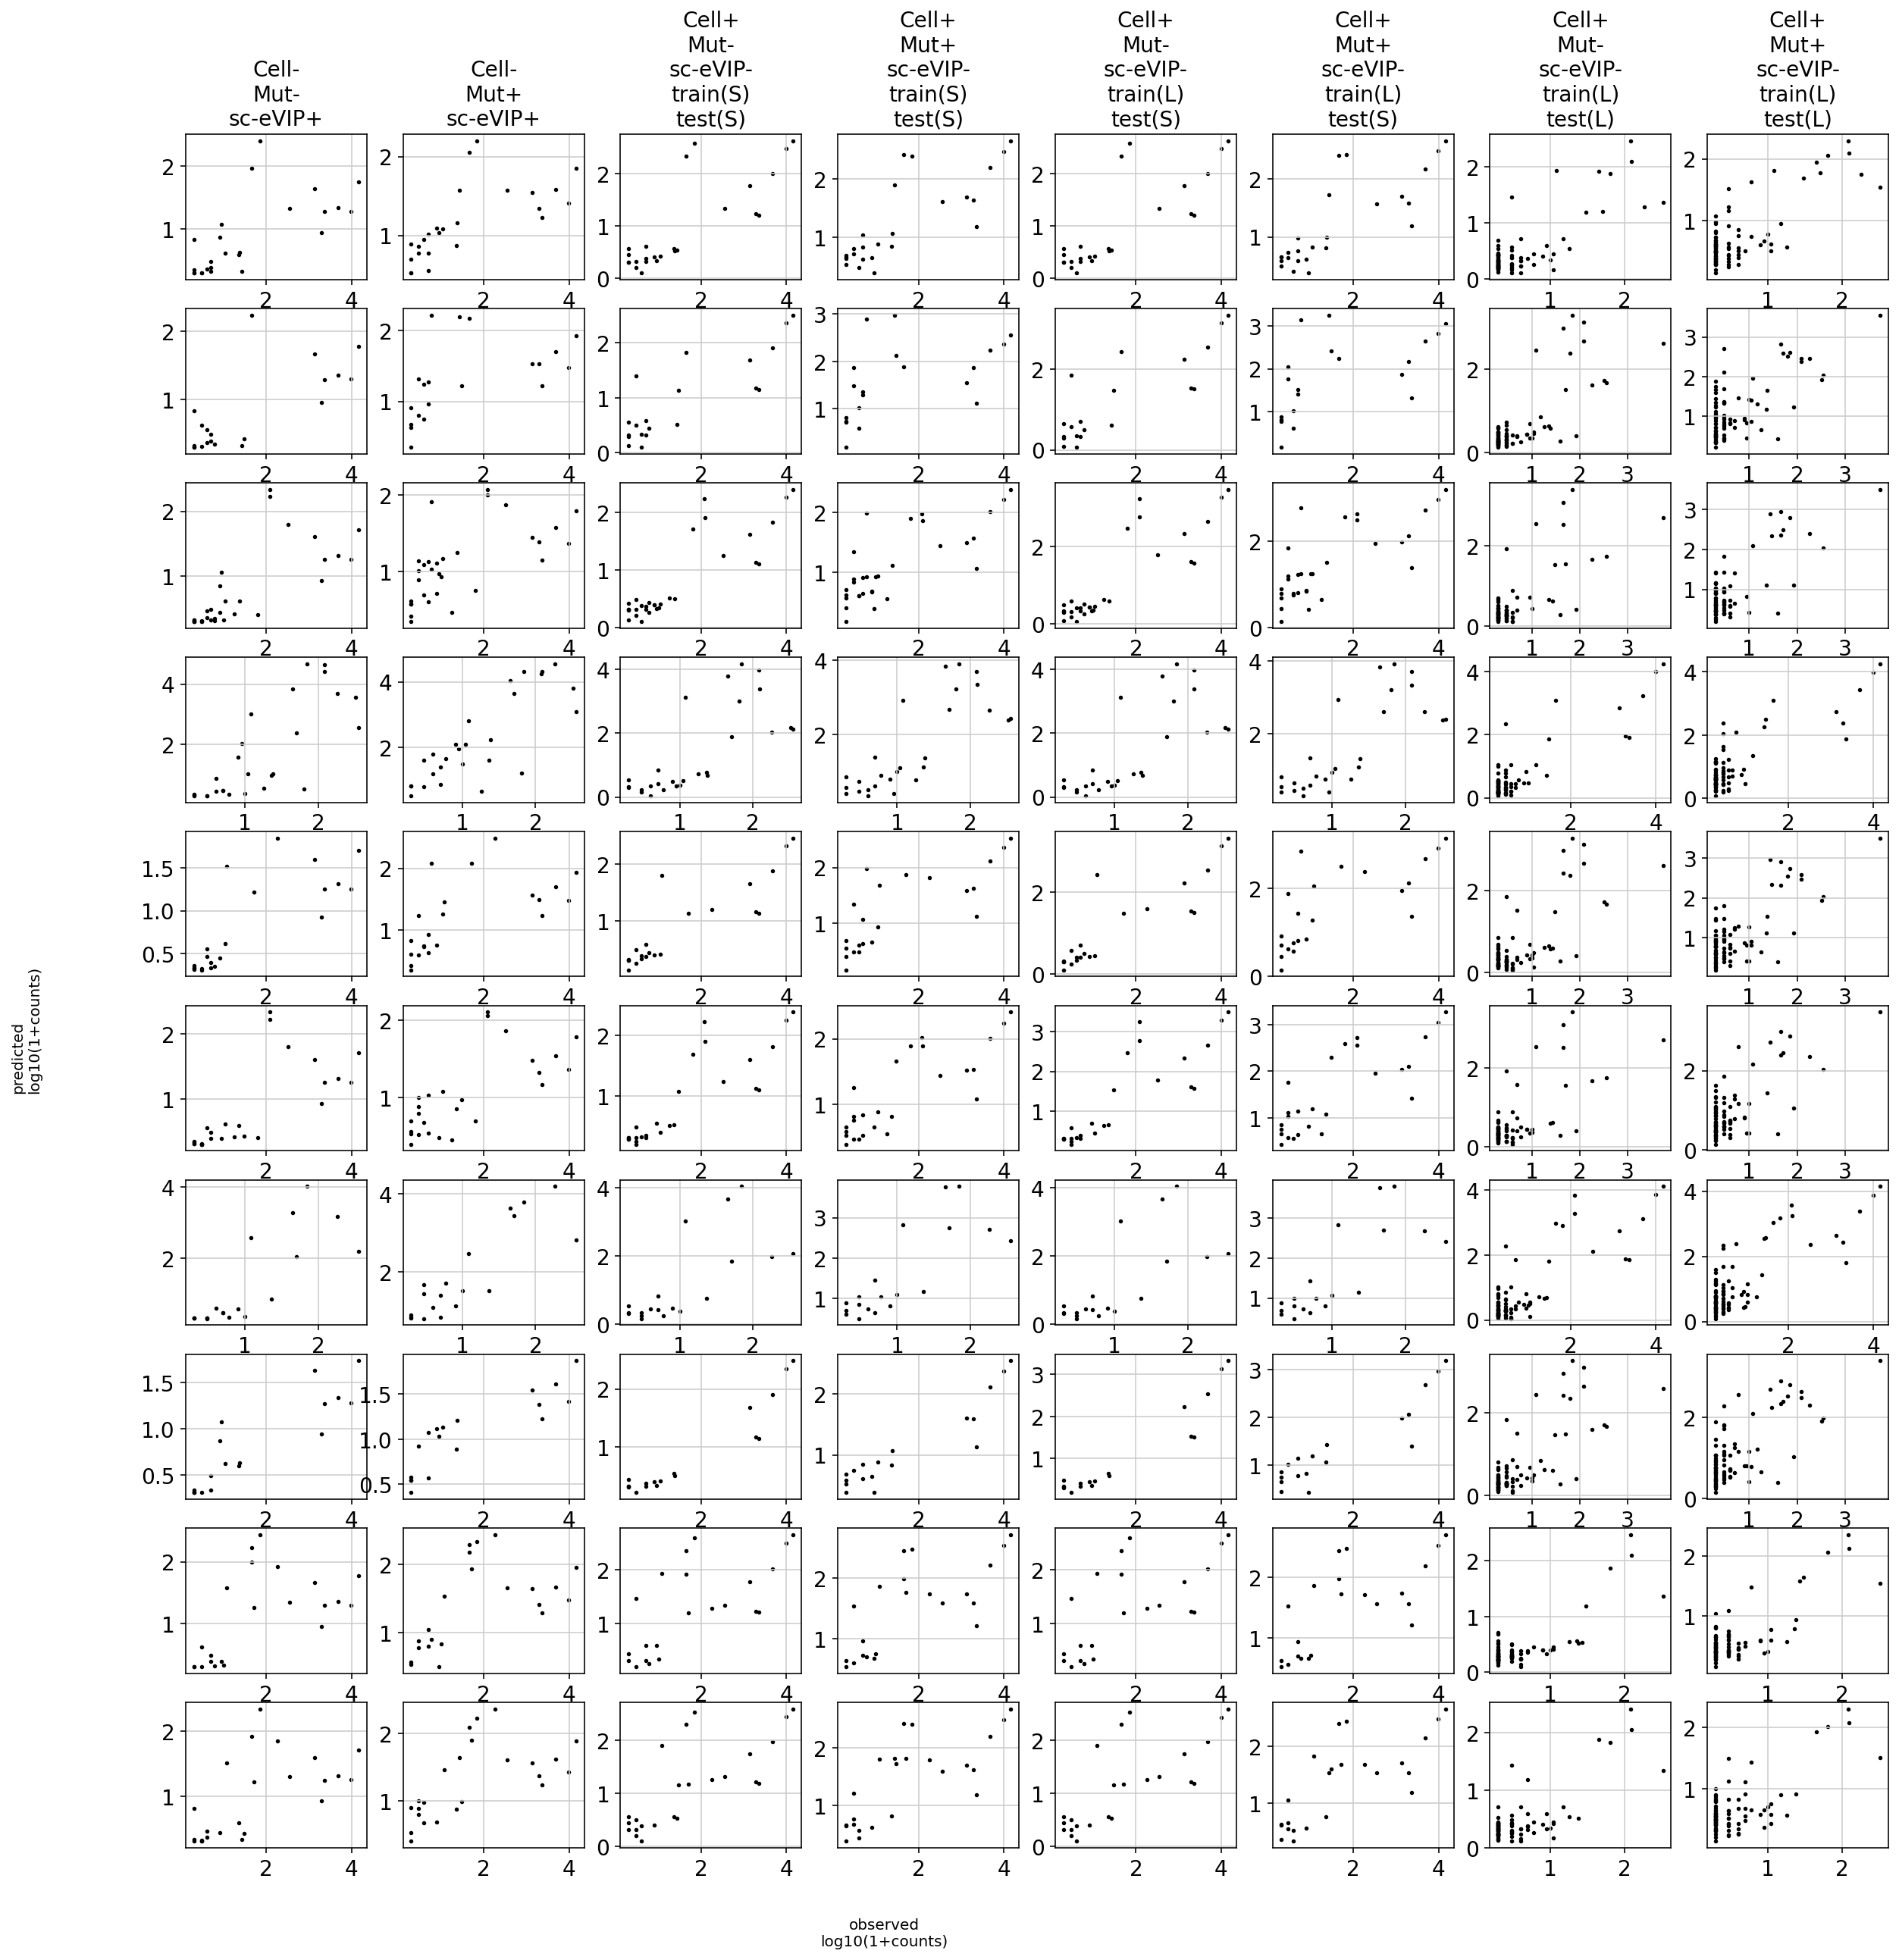

In [11]:
#read in all the predictions and compute performance

from scipy.stats import spearmanr,pearsonr

performances=pd.DataFrame(columns=['condition','pearson','spearman','r2','fold'])
ground_truth='COSMIC.1'

models=['Cell- Mut- sc-eVIP+',
        'Cell- Mut+ sc-eVIP+',
        
        'Cell+ Mut- sc-eVIP- train(S) test(S)',
        'Cell+ Mut+ sc-eVIP- train(S) test(S)',
        
        'Cell+ Mut- sc-eVIP- train(L) test(S)',
        'Cell+ Mut+ sc-eVIP- train(L) test(S)',
        
        'Cell+ Mut- sc-eVIP- train(L) test(L)',
        'Cell+ Mut+ sc-eVIP- train(L) test(L)',
       ]

fig,plots=plt.subplots(10,len(models))
fig.set_size_inches(20,20)


for i in range(10):
    print('=============== iteration',i)
    foldname='fold'+str(i)
    
    preds=pd.read_csv(DATA+'/mutfreq/KRAS.model_comparison.'+foldname+'.pred.csv',sep='\t')
    preds.index=preds['Mutation']
    
    m_idx=0
    for modelname in models:
        
        if modelname in ['Cell+ Mut+ sc-eVIP- train(S) test(S)',
                        'Cell+ Mut+ sc-eVIP- train(L) test(S)',
                        #'Cell+ Mut+ sc-eVIP- train L test L',
                        
                        'Cell+ Mut- sc-eVIP- train(S) test(S)',
                        'Cell+ Mut- sc-eVIP- train(L) test(S)',
                        #'Cell+ Mut- sc-eVIP- train L test L',
                        
                        'Cell- Mut- sc-eVIP+',
                        'Cell- Mut+ sc-eVIP+']:
            entries=preds.loc[preds['valid'+foldname],:].index
        else:
            entries=preds.loc[preds[foldname],:].index
            
        a=np.log10(1+preds.loc[entries,ground_truth])
        b=np.log10(1+preds.loc[entries,modelname])
        
        plots[i,m_idx].scatter(a,b,color='black',s=3)
        if i==0:
            plots[i,m_idx].set_title(re.sub(' ','\n',modelname))
            
        
        #measures
        s=spearmanr(a,b,nan_policy='omit')[0]
        p=pearsonr(a,b)[0]
        from sklearn.metrics import r2_score
        r2=r2_score(a,b)
        
        performances=pd.concat([performances,
                              pd.DataFrame({'condition':re.sub(' ','\n',modelname),
                                           'pearson':p,
                                           'spearman':s,
                                           'r2':r2,
                                           'fold':foldname},index=[modelname+foldname])])
        m_idx+=1
    #also do a shuffled
    entries=preds.loc[preds['valid'+foldname],:].index
            
    a=np.log10(1+preds.loc[entries,ground_truth])
    b=np.log10(1+preds.loc[entries,ground_truth])
    shuffle_rng=np.random.RandomState(i)
    b=shuffle_rng.choice(b,size=len(b),replace=False)

    #measures
    s=spearmanr(a,b,nan_policy='omit')[0]
    p=pearsonr(a,b)[0]
    from sklearn.metrics import r2_score
    r2=r2_score(a,b)

    performances=pd.concat([performances,
                          pd.DataFrame({'condition':'shuffled',
                                       'pearson':p,
                                       'spearman':s,
                                       'r2':r2,
                                       'fold':foldname},index=['shuffled'+foldname])])
fig.text(0.5, 0.08, 'observed\nlog10(1+counts)', ha='center')
fig.text(0.1, 0.5, 'predicted\nlog10(1+counts)', va='center', rotation='vertical')

In [63]:
#read in all the predictions and compute performance

from scipy.stats import spearmanr,pearsonr

performances=pd.DataFrame(columns=['condition','pearson','spearman','r2','fold'])
ground_truth='COSMIC.1'

models=['Cell- Mut- sc-eVIP+',
        'Cell- Mut+ sc-eVIP+',
        
        'Cell+ Mut- sc-eVIP- train(S) test(S)',
        'Cell+ Mut+ sc-eVIP- train(S) test(S)',
        
        'Cell+ Mut- sc-eVIP- train(L) test(S)',
        'Cell+ Mut+ sc-eVIP- train(L) test(S)',
        
        'Cell+ Mut- sc-eVIP- train(L) test(L)',
        'Cell+ Mut+ sc-eVIP- train(L) test(L)',
       ]

for i in range(10):
    print('=============== iteration',i)
    foldname='fold'+str(i)
    
    preds=pd.read_csv(DATA+'/mutfreq/KRAS.model_comparison.'+foldname+'.pred.csv',sep='\t')
    preds.index=preds['Mutation']
    
    
    for modelname in models:
        entries=data.loc[data[foldname],:].index
        if modelname in ['Cell+ Mut+ sc-eVIP- train(S) test(S)',
                        'Cell+ Mut+ sc-eVIP- train(L) test(S)',
                        #'Cell+ Mut+ sc-eVIP- train L test L',
                        
                        'Cell+ Mut- sc-eVIP- train(S) test(S)',
                        'Cell+ Mut- sc-eVIP- train(L) test(S)',
                        #'Cell+ Mut- sc-eVIP- train L test L',
                        
                        'Cell- Mut- sc-eVIP+',
                        'Cell- Mut+ sc-eVIP+']:
            entries=data.loc[data['valid'+foldname],:].index
            
        a=np.log10(1+preds.loc[entries,ground_truth])
        b=np.log10(1+preds.loc[entries,modelname])
        
        #measures
        s=spearmanr(a,b,nan_policy='omit')[0]
        p=pearsonr(a,b)[0]
        from sklearn.metrics import r2_score
        r2=r2_score(a,b)
        
        performances=pd.concat([performances,
                              pd.DataFrame({'condition':re.sub(' ','\n',modelname),
                                           'pearson':p,
                                           'spearman':s,
                                           'r2':r2,
                                           'fold':foldname},index=[modelname+foldname])])
    #also do a shuffled
    entries=data.loc[data['valid'+foldname],:].index
            
    a=np.log10(1+preds.loc[entries,ground_truth])
    b=np.log10(1+preds.loc[entries,ground_truth])
    shuffle_rng=np.random.RandomState(i)
    b=shuffle_rng.choice(b,size=len(b),replace=False)

    #measures
    s=spearmanr(a,b,nan_policy='omit')[0]
    p=pearsonr(a,b)[0]
    from sklearn.metrics import r2_score
    r2=r2_score(a,b)

    performances=pd.concat([performances,
                          pd.DataFrame({'condition':'shuffled',
                                       'pearson':p,
                                       'spearman':s,
                                       'r2':r2,
                                       'fold':foldname},index=['shuffled'+foldname])])

=============== iteration 0
=============== iteration 1
=============== iteration 2
=============== iteration 3
=============== iteration 4
=============== iteration 5
=============== iteration 6
=============== iteration 7
=============== iteration 8
=============== iteration 9


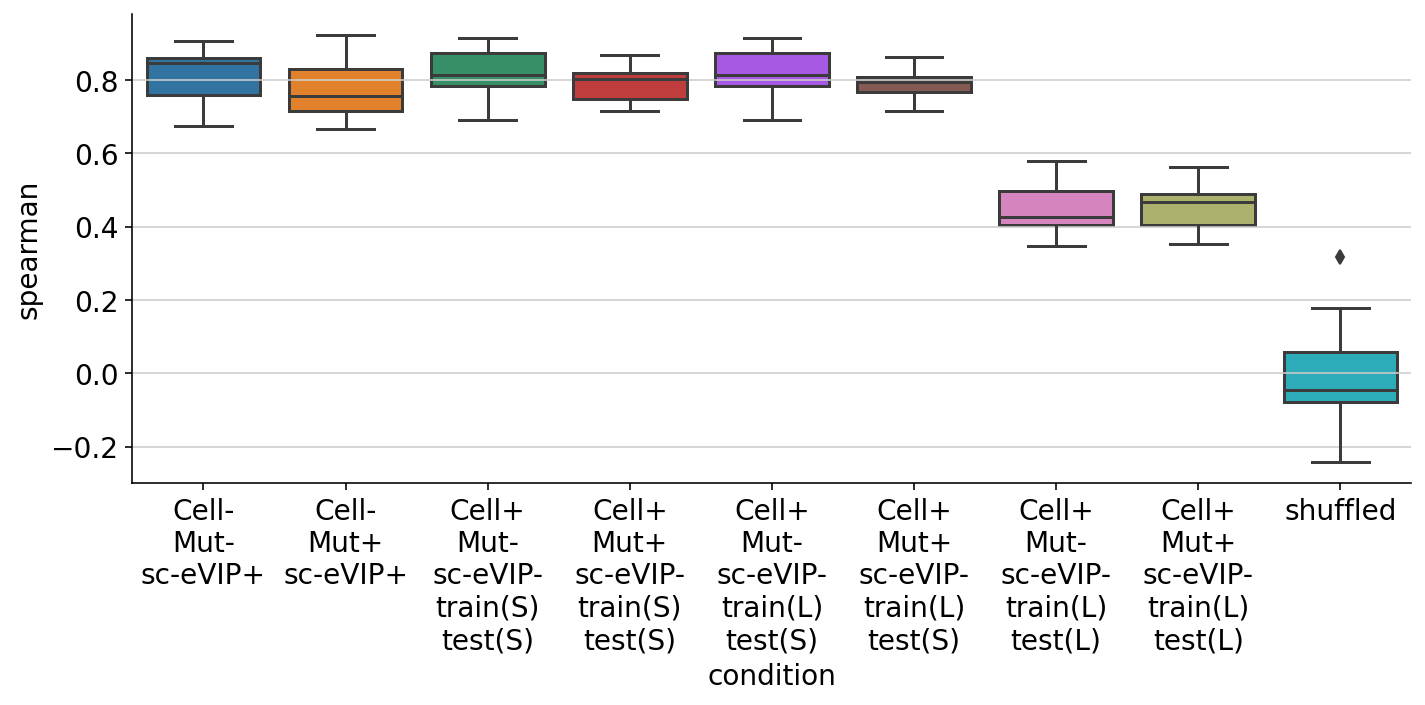

In [12]:
color_dict={}
for m in models:
    if 'Mut+' in m:
        if 'sc-eVIP-' in m:
            co='royalblue'
        if 'sc-eVIP+' in m:
            co='red'
    elif 'Mut-' in m:
        if 'sc-eVIP-' in m:
            co='lightblue'
        if 'sc-eVIP+' in m:
            co='pink'
    else:
        co='lightgray'
    color_dict[m]=co
    
color_dict['shuffled']='lightgray'

sns.catplot(data=performances,x='condition',y='spearman',kind='box',aspect=2,
           #palette=color_dict
           )


In [13]:
item='r2'
performances.groupby('condition', as_index=False)[item].median()

,condition,r2
0,Cell+\nMut+\nsc-eVIP-\ntrain(L)\ntest(L),0.303314
1,Cell+\nMut+\nsc-eVIP-\ntrain(L)\ntest(S),0.474039
2,Cell+\nMut+\nsc-eVIP-\ntrain(S)\ntest(S),0.442744
3,Cell+\nMut-\nsc-eVIP-\ntrain(L)\ntest(L),0.462190
4,Cell+\nMut-\nsc-eVIP-\ntrain(L)\ntest(S),0.512823
5,Cell+\nMut-\nsc-eVIP-\ntrain(S)\ntest(S),0.367450
6,Cell-\nMut+\nsc-eVIP+,0.213488
7,Cell-\nMut-\nsc-eVIP+,0.098260
8,shuffled,-0.956299


In [14]:
data.shape

(166, 50)

myorder ['Cell-\nMut-\nsc-eVIP+', 'Cell-\nMut+\nsc-eVIP+', 'Cell+\nMut-\nsc-eVIP-\ntrain(S)\ntest(S)', 'Cell+\nMut+\nsc-eVIP-\ntrain(S)\ntest(S)', 'Cell+\nMut-\nsc-eVIP-\ntrain(L)\ntest(S)', 'Cell+\nMut+\nsc-eVIP-\ntrain(L)\ntest(S)', 'Cell+\nMut-\nsc-eVIP-\ntrain(L)\ntest(L)', 'Cell+\nMut+\nsc-eVIP-\ntrain(L)\ntest(L)', 'shuffled']
[('Cell-\nMut-\nsc-eVIP+', 'Cell-\nMut+\nsc-eVIP+'), ('Cell+\nMut-\nsc-eVIP-\ntrain(S)\ntest(S)', 'Cell-\nMut+\nsc-eVIP+'), ('Cell+\nMut+\nsc-eVIP-\ntrain(S)\ntest(S)', 'Cell-\nMut+\nsc-eVIP+'), ('Cell+\nMut-\nsc-eVIP-\ntrain(L)\ntest(S)', 'Cell-\nMut+\nsc-eVIP+'), ('Cell+\nMut+\nsc-eVIP-\ntrain(L)\ntest(S)', 'Cell-\nMut+\nsc-eVIP+'), ('Cell+\nMut-\nsc-eVIP-\ntrain(L)\ntest(L)', 'Cell-\nMut+\nsc-eVIP+'), ('Cell+\nMut+\nsc-eVIP-\ntrain(L)\ntest(L)', 'Cell-\nMut+\nsc-eVIP+'), ('shuffled', 'Cell-\nMut+\nsc-eVIP+')]
r2                                           Cell+\nMut-\nsc-eVIP-\ntrain(S)\ntest(S)  \
Cell-\nMut-\nsc-eVIP+                                     

p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

Cell-
Mut-
sc-eVIP+ v.s. Cell-
Mut+
sc-eVIP+: Custom statistical test, P_val:4.272e-01
Cell-
Mut+
sc-eVIP+ v.s. Cell+
Mut-
sc-eVIP-
train(S)
test(S): Custom statistical test, P_val:3.537e-01
Cell-
Mut+
sc-eVIP+ v.s. Cell+
Mut+
sc-eVIP-
train(S)
test(S): Custom statistical test, P_val:8.058e-01
Cell-
Mut+
sc-eVIP+ v.s. Cell+
Mut-
sc-eVIP-
train(L)
test(S): Custom statistical test, P_val:3.537e-01
Cell-
Mut+
sc-eVIP+ v.s. Cell+
Mut+
sc-eVIP-
train(L)
test(S): Custom statistical test, P_val:8.072e-01
Cell-
Mut+
sc-eVIP+ v.s. Cell+
Mut-
sc-eVIP-
train(L)
test(L): Custom statistical test, P_val:8.472e-08
Cell-
Mut+
sc-eVIP+ v.s. Cell+
Mut+
sc-eVIP-
train(L)
test(L): Custom statistical test, P_val:3.648e-08
Cell-
Mut+
sc-eVIP+ v.s. shuffled: Custom statistical test, P_val:5.311e-10
p-value annotation legend:
ns: 5.00e-02 < p <= 1.

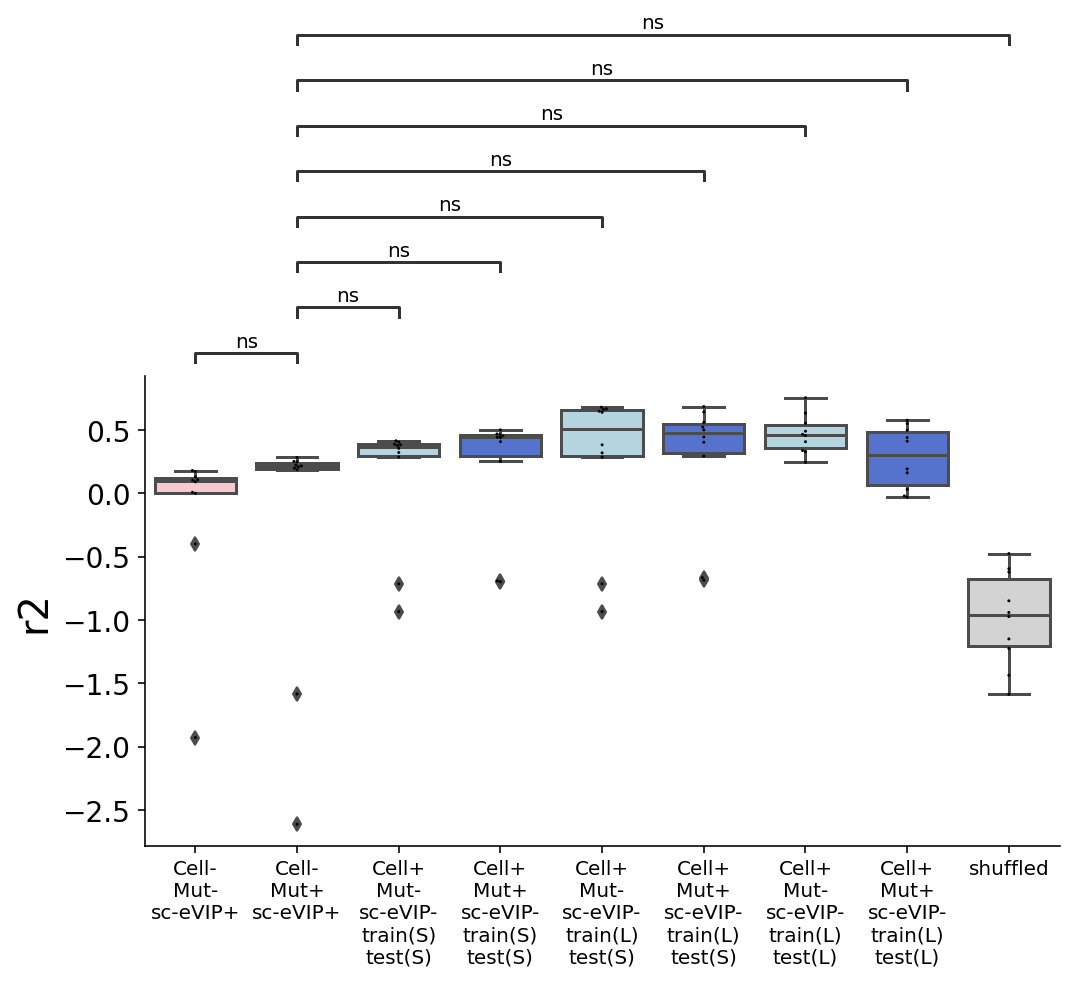

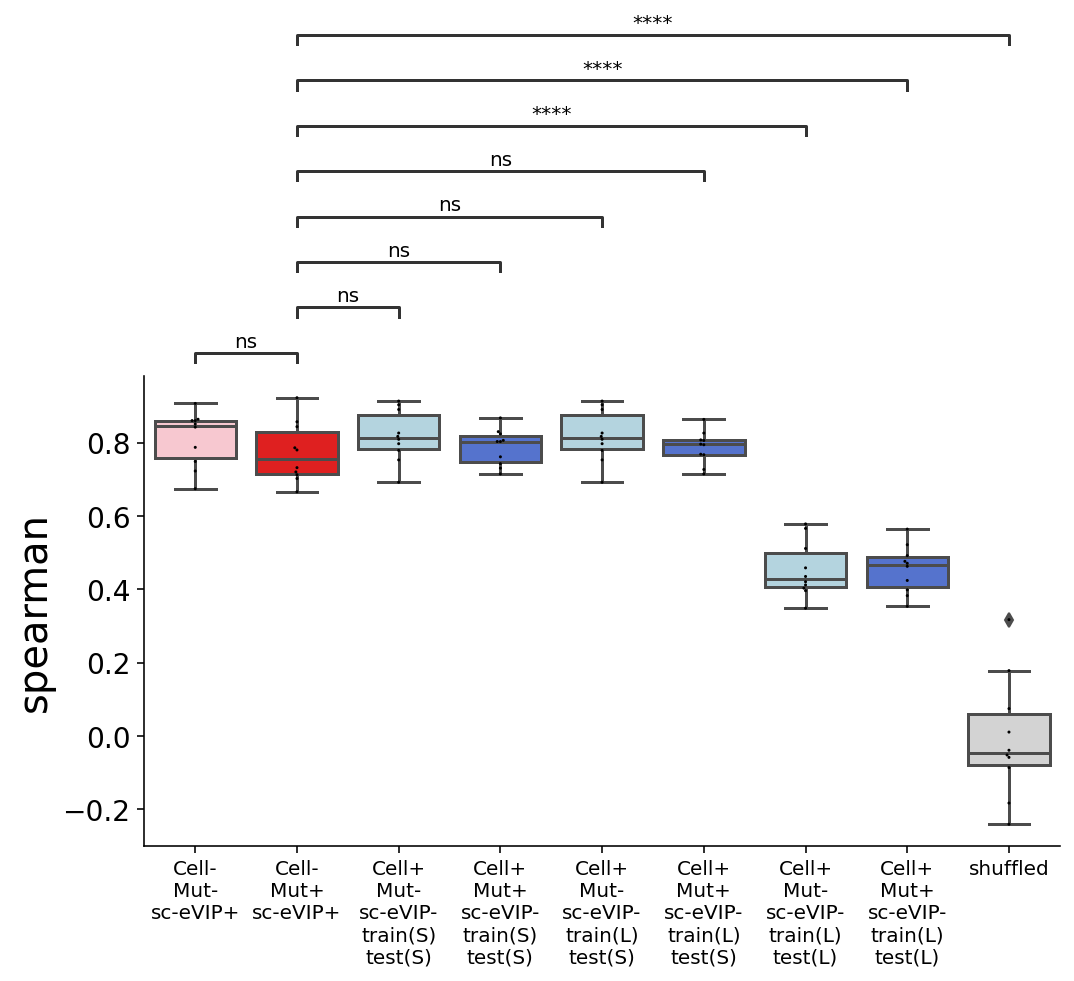

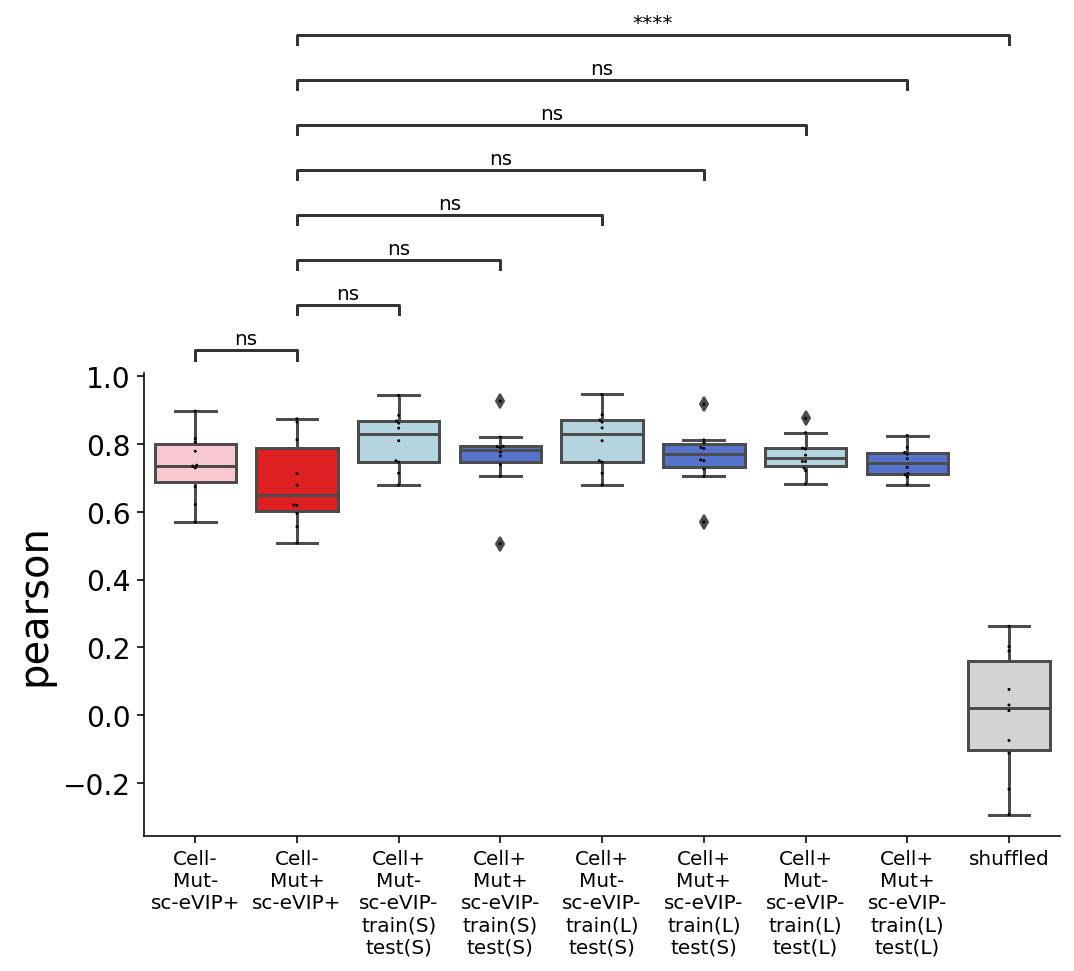

In [15]:
myorder=[]
for i in models:
    myorder.append(re.sub(' ','\n',i))
myorder.append('shuffled')
print('myorder',myorder)

color_dict={}
for m in myorder:
    if 'Mut+' in m:
        if 'sc-eVIP-' in m:
            co='royalblue'
        if 'sc-eVIP+' in m:
            co='red'
    elif 'Mut-' in m:
        if 'sc-eVIP-' in m:
            co='lightblue'
        if 'sc-eVIP+' in m:
            co='pink'
    else:
        co='lightgray'
    color_dict[m]=co
    
color_dict['shuffled']='lightgray'

pairs=[]
comparison='Cell-\nMut+\nsc-eVIP+'
for x in myorder:
    if x==comparison:
        continue
    pairs.append((x,comparison))
print(pairs)


def pairwise_ttests(df,condition,value):

    pval_m=pd.DataFrame(0.0,index=conditions,columns=conditions)

    for m1 in conditions:
        m1_values=df.loc[df[condition]==m1,value]
        for m2 in conditions:
            m2_values=df.loc[df[condition]==m2,value]

            from scipy.stats import ttest_ind
            res=ttest_ind(m1_values,m2_values,nan_policy='omit')

            pval_m.loc[m1,m2]=res[1]
            pval_m.loc[m2,m1]=pval_m.loc[m1,m2]
            
    #correct for multiple testing
    from statsmodels.stats.multitest import multipletests
    pvals=np.array(pval_m).flatten()
    new_pvals=multipletests(pvals,method='fdr_bh')[1]
    pval_m2=pd.DataFrame(new_pvals.reshape(pval_m.shape),index=pval_m.index,columns=pval_m.columns)
    return(pval_m2)

    
    
from statannot import add_stat_annotation
for item in ['r2','spearman','pearson']:
    
    df=pd.DataFrame({'condition':performances['condition'],
                'value':performances[item]})

    condition='condition'
    value='value'
    conditions=set(df[condition])
    pval_m=pairwise_ttests(df,'condition','value')
    if item=='r2':
        print(item,pval_m.loc[myorder,:])
    pvals_anno=[]
    for pair_idx in range(len(pairs)):
        #pvals_anno.append('{:0.2e}'.format(pval_m.loc[pairs[pair_idx][0],pairs[pair_idx][1]]))
        pvals_anno.append(pval_m.loc[pairs[pair_idx][0],pairs[pair_idx][1]])
        
    
    aspect_num=1.5
    g = sns.catplot(x="condition", y=item,kind='box',data=performances,palette=color_dict,
                   order=myorder,aspect=aspect_num)##aspect=1.3)#4)
                    #order=myorder)#,palette=color_dict)
    sns.swarmplot(x="condition", y=item, color="k", size=aspect_num, data=performances, ax=g.ax,order=myorder)
                  #order=myorder);
    #g.set_xticklabels(rotation=45)
        
    ax1 = g.axes[0,0]
    ax1.grid(False)
    
    '''
    if item=='r2':
        print('')
        #g.ax.set_ylim(-2,1)
        #g.ax.set_yticks([-1,0,1])
        #g.ax.set_yticklabels([-1,0,1],fontsize=20)
        
    else:
        g.ax.set_ylim(-0.5,1)
        g.ax.set_yticks([-0.5,0,0.5,1])
        g.ax.set_yticklabels([-0.5,0,0.5,1],fontsize=20)
    '''
    #g.ax.set_xticks([])
    g.ax.set_xlabel('')
    g.ax.set_ylabel(item,fontsize=20)
    g.ax.set_xticklabels(myorder,fontsize=10)
    
    test_results = add_stat_annotation(ax1,
                                       x="condition", y=item,data=performances,order=myorder,
                                   box_pairs=pairs,
                                       pvalues=pvals_anno,
                                       perform_stat_test=False,
                                       #text_annot_custom=pvals_anno,
                                   text_format='star',
                                   loc='outside', verbose=2)
    plt.savefig(FIGS+'/'+PROTEIN+'.LinModels_full.'+item+'.pdf',bbox_inches = "tight") 
    plt.savefig(FIGS+'/'+PROTEIN+'.LinModels_full.'+item+'.png',bbox_inches = "tight")

[('Cell+\nMut+\nsc-eVIP-\ntrain(S)\ntest(S)', 'Cell-\nMut+\nsc-eVIP+'), ('Cell+\nMut+\nsc-eVIP-\ntrain(L)\ntest(L)', 'Cell-\nMut+\nsc-eVIP+'), ('shuffled', 'Cell-\nMut+\nsc-eVIP+')]
r2                                           Cell+\nMut-\nsc-eVIP-\ntrain(S)\ntest(S)  \
Cell-\nMut+\nsc-eVIP+                                                     0.516593   
Cell+\nMut+\nsc-eVIP-\ntrain(S)\ntest(S)                                  0.992342   
Cell+\nMut+\nsc-eVIP-\ntrain(L)\ntest(L)                                  0.623130   
shuffled                                                                  0.000163   

                                          Cell+\nMut+\nsc-eVIP-\ntrain(S)\ntest(S)  \
Cell-\nMut+\nsc-eVIP+                                                     0.438182   
Cell+\nMut+\nsc-eVIP-\ntrain(S)\ntest(S)                                  1.000000   
Cell+\nMut+\nsc-eVIP-\ntrain(L)\ntest(L)                                  0.914137   
shuffled                                

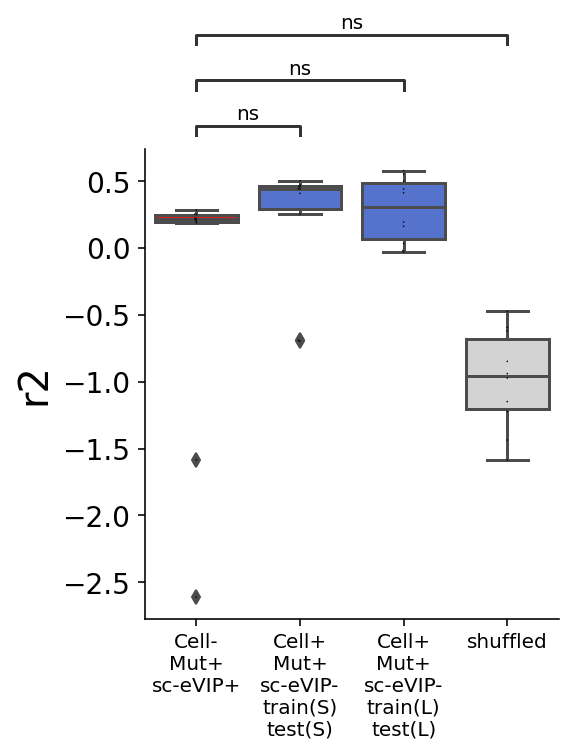

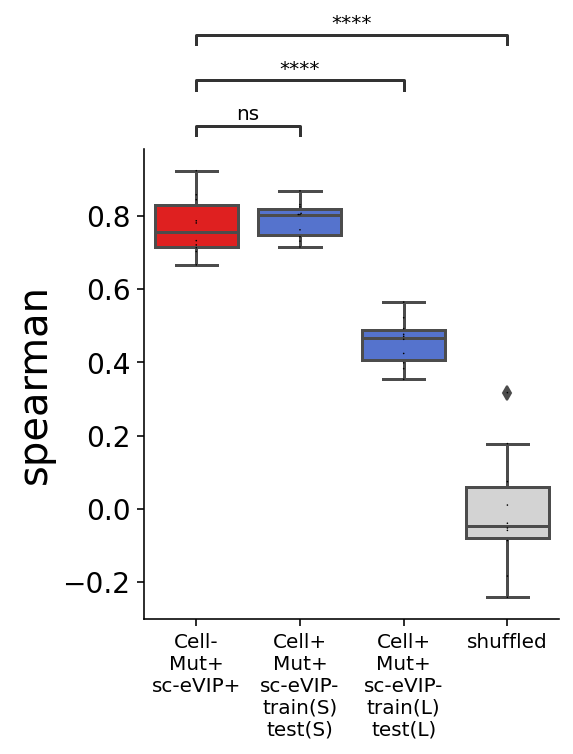

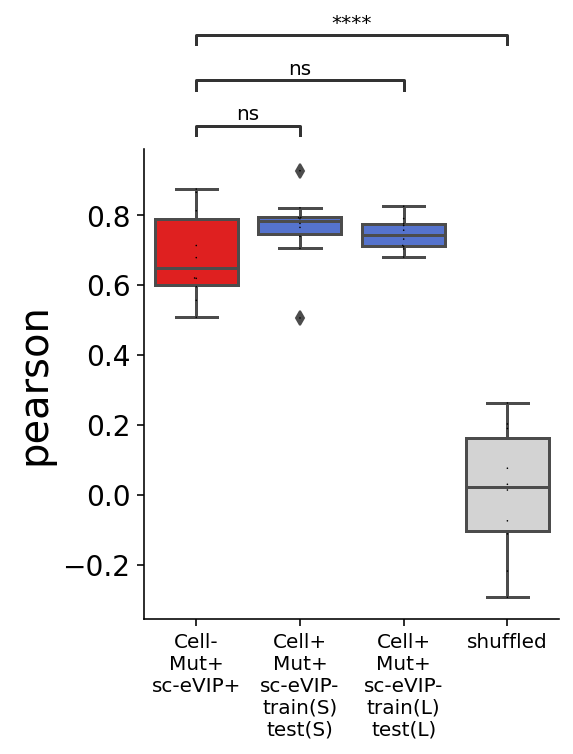

In [16]:
myorder=[
 'Cell-\nMut+\nsc-eVIP+',
 
 'Cell+\nMut+\nsc-eVIP-\ntrain(S)\ntest(S)',

 'Cell+\nMut+\nsc-eVIP-\ntrain(L)\ntest(L)',
 'shuffled']

color_dict={}
for m in myorder:
    if 'Mut+' in m:
        if 'sc-eVIP-' in m:
            co='royalblue'
        if 'sc-eVIP+' in m:
            co='red'
    elif 'Mut-' in m:
        if 'sc-eVIP-' in m:
            co='lightblue'
        if 'sc-eVIP+' in m:
            co='pink'
    else:
        co='lightgray'
    color_dict[m]=co
    
color_dict['shuffled']='lightgray'

pairs=[]
comparison='Cell-\nMut+\nsc-eVIP+'
for x in myorder:
    if x==comparison:
        continue
    pairs.append((x,comparison))
print(pairs)


def pairwise_ttests(df,condition,value):

    pval_m=pd.DataFrame(0.0,index=conditions,columns=conditions)

    for m1 in conditions:
        m1_values=df.loc[df[condition]==m1,value]
        for m2 in conditions:
            m2_values=df.loc[df[condition]==m2,value]

            from scipy.stats import ttest_ind
            res=ttest_ind(m1_values,m2_values,nan_policy='omit')

            pval_m.loc[m1,m2]=res[1]
            pval_m.loc[m2,m1]=pval_m.loc[m1,m2]
            
    #correct for multiple testing
    from statsmodels.stats.multitest import multipletests
    pvals=np.array(pval_m).flatten()
    new_pvals=multipletests(pvals,method='fdr_bh')[1]
    pval_m2=pd.DataFrame(new_pvals.reshape(pval_m.shape),index=pval_m.index,columns=pval_m.columns)
    return(pval_m2)

    
    
from statannot import add_stat_annotation
for item in ['r2','spearman','pearson']:
    
    df=pd.DataFrame({'condition':performances['condition'],
                'value':performances[item]})

    condition='condition'
    value='value'
    conditions=set(df[condition])
    pval_m=pairwise_ttests(df,'condition','value')
    if item=='r2':
        print(item,pval_m.loc[myorder,:])
    pvals_anno=[]
    for pair_idx in range(len(pairs)):
        #pvals_anno.append('{:0.2e}'.format(pval_m.loc[pairs[pair_idx][0],pairs[pair_idx][1]]))
        pvals_anno.append(pval_m.loc[pairs[pair_idx][0],pairs[pair_idx][1]])
        
    
    aspect_num=0.8
    g = sns.catplot(x="condition", y=item,kind='box',data=performances,palette=color_dict,
                   order=myorder,aspect=aspect_num)##aspect=1.3)#4)
                    #order=myorder)#,palette=color_dict)
    sns.swarmplot(x="condition", y=item, color="k", size=aspect_num, data=performances, ax=g.ax,order=myorder)
                  #order=myorder);
    #g.set_xticklabels(rotation=45)
        
    ax1 = g.axes[0,0]
    ax1.grid(False)
    
    '''
    if item=='r2':
        g.ax.set_ylim(-2,1)
        g.ax.set_yticks([-1,0,1])
        g.ax.set_yticklabels([-1,0,1],fontsize=20)
        
    else:
        g.ax.set_ylim(-0.5,1)
        g.ax.set_yticks([-0.5,0,0.5,1])
        g.ax.set_yticklabels([-0.5,0,0.5,1],fontsize=20)
    '''
    #g.ax.set_xticks([])
    g.ax.set_xlabel('')
    g.ax.set_ylabel(item,fontsize=20)
    g.ax.set_xticklabels(myorder,fontsize=10)
    
    test_results = add_stat_annotation(ax1,
                                       x="condition", y=item,data=performances,order=myorder,
                                   box_pairs=pairs,
                                       pvalues=pvals_anno,
                                       perform_stat_test=False,
                                       #text_annot_custom=pvals_anno,
                                   text_format='star',
                                   loc='outside', verbose=2)
    
    plt.savefig(FIGS+'/'+PROTEIN+'.LinModels_subset.'+item+'.pdf',bbox_inches = "tight") 
    plt.savefig(FIGS+'/'+PROTEIN+'.LinModels_subset.'+item+'.png',bbox_inches = "tight")

In [69]:
anno.loc[sorted_variants,'cluster_color2'].value_counts()

black      42
red        31
#138D75    12
gold       10
#BB8FCE     3
Name: cluster_color2, dtype: int64

In [75]:
gof=list(anno.loc[anno['cluster_color2']=='red',:].index)
gof

['G12D',
 'G12V',
 'G12C',
 'G12A',
 'G12R',
 'Q61H',
 'G12S',
 'A146T',
 'G13C',
 'Q61R',
 'Q61L',
 'A146V',
 'K117N',
 'G12F',
 'A59T',
 'G13V',
 'G13E',
 'Q22K',
 'A59G',
 'A146P',
 'A59E',
 'G13R',
 'K117R',
 'G12Y',
 'T58I',
 'AG59GV',
 'AG11TD',
 'V14L',
 'Q61A',
 'D119G',
 'G12I']

In [86]:
(preds.loc[gof,'COSMIC.1']>=20).sum()

17

In [83]:
mutsig.loc['D119G',:]

Position                  119
WT AA                       D
Final AA                    G
Mutation                D119G
COSMIC                 Single
Day0 Reads             1367.7
Z-Low-D7                 1.24
Z-Low-D14                0.88
Z-High-D7                -0.8
Z-High-D14              -0.14
Theta-D7                 0.23
chisq-pval-D7               0
Theta-D14                0.14
chisq-pval-D14              0
COSMIC.1                    0
GENIE                       1
TCGA                        0
EXaC                        0
Signature_1        0.00627496
Signature_2       0.000425577
Signature_3        0.00918629
Signature_4             0.002
Signature_5         0.0137711
Signature_6            0.0056
Signature_7            0.0001
Signature_8         0.0077878
Signature_9            0.0105
Signature_10           0.0052
Signature_11           0.0015
Signature_12           0.0317
Signature_13      0.000145507
Signature_14           0.0046
Signature_15           0.0073
Signature_

In [ ]:
performances.loc[performances['condition']=='Cell-\nMut+\nsc-eVIP+',:].sort_values(by='r2')

In [ ]:
foldname='fold3'
preds=pd.read_csv(DATA+'/mutfreq/KRAS.model_comparison.'+foldname+'.pred.csv',sep='\t')
preds.index=preds['Mutation']
entries=preds.loc[preds[foldname],:].index


ground_truth='COSMIC.1'
predcol='Cell- Mut+ sc-eVIP+'
plt.scatter(np.log10(1+preds.loc[entries,ground_truth]),
            np.log10(1+preds.loc[entries,predcol]),
           )
plt.plot([0,4],[0,4])

In [ ]:
foldname='fold3'
preds=pd.read_csv(DATA+'/mutfreq/KRAS.model_comparison.'+foldname+'.pred.csv',sep='\t')
preds.index=preds['Mutation']
entries=preds.loc[preds['valid'+foldname],:].index


ground_truth='COSMIC.1'
predcol='Cell+ Mut+ sc-eVIP- train(S) test(S)'
plt.scatter(np.log10(1+preds.loc[entries,ground_truth]),
            np.log10(1+preds.loc[entries,predcol]),
           )
plt.plot([0,4],[0,4])

In [ ]:
foldname='fold4'
preds=pd.read_csv(DATA+'/mutfreq/KRAS.model_comparison.'+foldname+'.pred.csv',sep='\t')
preds.index=preds['Mutation']
entries=preds.loc[preds[foldname],:].index


ground_truth='COSMIC.1'
predcol='Cell- Mut+ sc-eVIP+'
plt.scatter(np.log10(1+preds.loc[entries,ground_truth]),
            np.log10(1+preds.loc[entries,predcol]),
           )
plt.plot([0,4],[0,4])

In [ ]:
preds.columns

In [ ]:
#now average predictions from the 10 p53 models
predictions=pd.DataFrame(index=data.index,
                        columns=range(10))
for fold in range(10):
    foldname='fold'+str(fold)
    preds=pd.read_csv(DATA+'/mutfreq/KRAS.predictedFromTP53.'+foldname+'.pred.csv',
                     sep=' ')
    preds.index=list(preds['Mutation'])
    predictions[fold]=preds.loc[predictions.index,'predicted_mutonly']



In [ ]:
predictions.head()

In [ ]:
predictions.min()

In [ ]:
#average the predictions
avg_predictions=predictions.mean(axis=1)

In [ ]:
data['mutational_signature_score']=avg_predictions

In [ ]:
data['GILA_day7']=data['Z-Low-D7']

In [ ]:
#make the data for all the individual models

def get_positions_train_valid(data_pos,rng):
    
    positions=list(set(data_pos))
    train_positions=rng.choice(positions,size=int(len(positions)/2),replace=False)
    
    train_col=[]
    for j in range(len(data_pos)):
        curr_pos=data_pos[j]
        if curr_pos in train_positions:
            train_col.append(True)
        else:
            train_col.append(False)
    return(train_col)

def get_train_valid_datasets(data_here,
                            features,
                            training_pos_col,valid_pos_col,
                         training_y_name,valid_y_name,
                            offset_col=None):
    
    #subset data
    d={}
    d['x_train']=data_here.loc[data_here[training_pos_col]==True,features]
    d['y_train']=data_here.loc[data_here[training_pos_col]==True,training_y_name]
    d['x_valid']=data_here.loc[data_here[valid_pos_col]==True,features]
    d['y_valid']=data_here.loc[data_here[valid_pos_col]==True,valid_y_name]
    if offset_col is not None:
        d['offset_train']=data_here.loc[data_here[training_pos_col]==True,offset_col]
        d['offset_valid']=data_here.loc[data_here[valid_pos_col]==True,offset_col]
    return(d)

for i in range(10):
    print('=============== iteration',i)
    #define train, validation sets
    #==============================
    #randomize train/test - by position
    foldname='fold'+str(i)
    rng=np.random.RandomState(i)
    data[foldname]=get_positions_train_valid(copy.deepcopy(data['Position']),rng)
    
    data[foldname+'not']=(data[foldname]==False)
    
    data['train'+foldname]=np.multiply(data['has_effsize'],data[foldname])
    data['valid'+foldname]=np.multiply(data['has_effsize'],data[foldname+'not'])
    data.to_csv(DATA+'/mutfreq/KRAS.model_comparison.'+foldname+'.csv')
    print(DATA+'/mutfreq/KRAS.model_comparison.'+foldname+'.csv')

In [ ]:
#read in all the predictions and compute performance

from scipy.stats import spearmanr,pearsonr

performances=pd.DataFrame(columns=['condition','pearson','spearman','r2','fold'])
ground_truth='COSMIC.1'

models=['Cell- Mut- sc-eVIP+',
        'Cell- Mut+ sc-eVIP+',
        
        'Cell+ Mut- sc-eVIP- train(S) test(S)',
        'Cell+ Mut+ sc-eVIP- train(S) test(S)',
        
        'Cell+ Mut- sc-eVIP- train(L) test(S)',
        'Cell+ Mut+ sc-eVIP- train(L) test(S)',
        
        'Cell+ Mut- sc-eVIP- train(L) test(L)',
        'Cell+ Mut+ sc-eVIP- train(L) test(L)',
       ]

for i in range(10):
    print('=============== iteration',i)
    foldname='fold'+str(i)
    
    preds=pd.read_csv(DATA+'/mutfreq/KRAS.model_comparison.'+foldname+'.pred.csv',sep='\t')
    preds.index=preds['Mutation']
    
    
    for modelname in models:
        entries=data.loc[data[foldname],:].index
        if modelname in ['Cell+ Mut+ sc-eVIP- train(S) test(S)',
                        'Cell+ Mut+ sc-eVIP- train(L) test(S)',
                        #'Cell+ Mut+ sc-eVIP- train L test L',
                        
                        'Cell+ Mut- sc-eVIP- train(S) test(S)',
                        'Cell+ Mut- sc-eVIP- train(L) test(S)',
                        #'Cell+ Mut- sc-eVIP- train L test L',
                        
                        'Cell- Mut- sc-eVIP+',
                        'Cell- Mut+ sc-eVIP+']:
            entries=data.loc[data['valid'+foldname],:].index
            
        a=np.log10(1+preds.loc[entries,ground_truth])
        b=np.log10(1+preds.loc[entries,modelname])
        
        #measures
        s=spearmanr(a,b,nan_policy='omit')[0]
        p=pearsonr(a,b)[0]
        from sklearn.metrics import r2_score
        r2=r2_score(a,b)
        
        performances=pd.concat([performances,
                              pd.DataFrame({'condition':re.sub(' ','\n',modelname),
                                           'pearson':p,
                                           'spearman':s,
                                           'r2':r2,
                                           'fold':foldname},index=[modelname+foldname])])
    #also do a shuffled
    entries=data.loc[data['valid'+foldname],:].index
            
    a=np.log10(1+preds.loc[entries,ground_truth])
    b=np.log10(1+preds.loc[entries,ground_truth])
    shuffle_rng=np.random.RandomState(i)
    b=shuffle_rng.choice(b,size=len(b),replace=False)

    #measures
    s=spearmanr(a,b,nan_policy='omit')[0]
    p=pearsonr(a,b)[0]
    from sklearn.metrics import r2_score
    r2=r2_score(a,b)

    performances=pd.concat([performances,
                          pd.DataFrame({'condition':'shuffled',
                                       'pearson':p,
                                       'spearman':s,
                                       'r2':r2,
                                       'fold':foldname},index=['shuffled'+foldname])])

In [ ]:
color_dict={}
for m in models:
    if 'Mut+' in m:
        if 'sc-eVIP-' in m:
            co='royalblue'
        if 'sc-eVIP+' in m:
            co='red'
    elif 'Mut-' in m:
        if 'sc-eVIP-' in m:
            co='lightblue'
        if 'sc-eVIP+' in m:
            co='pink'
    else:
        co='lightgray'
    color_dict[m]=co
    
color_dict['shuffled']='lightgray'

sns.catplot(data=performances,x='condition',y='spearman',kind='box',aspect=2,
           #palette=color_dict
           )


In [ ]:
myorder=[]
for i in models:
    myorder.append(re.sub(' ','\n',i))
myorder.append('shuffled')
print('myorder',myorder)

color_dict={}
for m in myorder:
    if 'Mut+' in m:
        if 'sc-eVIP-' in m:
            co='royalblue'
        if 'sc-eVIP+' in m:
            co='red'
    elif 'Mut-' in m:
        if 'sc-eVIP-' in m:
            co='lightblue'
        if 'sc-eVIP+' in m:
            co='pink'
    else:
        co='lightgray'
    color_dict[m]=co
    
color_dict['shuffled']='lightgray'

pairs=[]
comparison='Cell-\nMut+\nsc-eVIP+'
for x in myorder:
    if x==comparison:
        continue
    pairs.append((x,comparison))
print(pairs)


def pairwise_ttests(df,condition,value):

    pval_m=pd.DataFrame(0.0,index=conditions,columns=conditions)

    for m1 in conditions:
        m1_values=df.loc[df[condition]==m1,value]
        for m2 in conditions:
            m2_values=df.loc[df[condition]==m2,value]

            from scipy.stats import ttest_ind
            res=ttest_ind(m1_values,m2_values,nan_policy='omit')

            pval_m.loc[m1,m2]=res[1]
            pval_m.loc[m2,m1]=pval_m.loc[m1,m2]
            
    #correct for multiple testing
    from statsmodels.stats.multitest import multipletests
    pvals=np.array(pval_m).flatten()
    new_pvals=multipletests(pvals,method='fdr_bh')[1]
    pval_m2=pd.DataFrame(new_pvals.reshape(pval_m.shape),index=pval_m.index,columns=pval_m.columns)
    return(pval_m2)

    
    
from statannot import add_stat_annotation
for item in ['r2','spearman','pearson']:
    
    df=pd.DataFrame({'condition':performances['condition'],
                'value':performances[item]})

    condition='condition'
    value='value'
    conditions=set(df[condition])
    pval_m=pairwise_ttests(df,'condition','value')
    ##print(item,pval_m.loc[myorder,:])
    pvals_anno=[]
    for pair_idx in range(len(pairs)):
        #pvals_anno.append('{:0.2e}'.format(pval_m.loc[pairs[pair_idx][0],pairs[pair_idx][1]]))
        pvals_anno.append(pval_m.loc[pairs[pair_idx][0],pairs[pair_idx][1]])
        
    
    aspect_num=1.5
    g = sns.catplot(x="condition", y=item,kind='box',data=performances,palette=color_dict,
                   order=myorder,aspect=aspect_num)##aspect=1.3)#4)
                    #order=myorder)#,palette=color_dict)
    sns.swarmplot(x="condition", y=item, color="k", size=aspect_num, data=performances, ax=g.ax,order=myorder)
                  #order=myorder);
    #g.set_xticklabels(rotation=45)
        
    ax1 = g.axes[0,0]
    ax1.grid(False)
    
    
    if item=='r2':
        g.ax.set_ylim(-2,1)
        g.ax.set_yticks([-1,0,1])
        g.ax.set_yticklabels([-1,0,1],fontsize=20)
        
    else:
        g.ax.set_ylim(-0.5,1)
        g.ax.set_yticks([-0.5,0,0.5,1])
        g.ax.set_yticklabels([-0.5,0,0.5,1],fontsize=20)
    #g.ax.set_xticks([])
    g.ax.set_xlabel('')
    g.ax.set_ylabel(item,fontsize=20)
    g.ax.set_xticklabels(myorder,fontsize=10)
    
    test_results = add_stat_annotation(ax1,
                                       x="condition", y=item,data=performances,order=myorder,
                                   box_pairs=pairs,
                                       pvalues=pvals_anno,
                                       perform_stat_test=False,
                                       #text_annot_custom=pvals_anno,
                                   text_format='star',
                                   loc='outside', verbose=2)

In [ ]:
#make data with 0-ed func data
#predict => from mutational 

def predict_from_mutational(data,features,func_data,mymodel):
    mut_data=data.loc[:,features]
    for c in func_data:
        mut_data[c]=0
    #now, predict
    #print('entries',mut_data.loc['T144P',:])
    mut_preds=mymodel.predict(mut_data.loc[:,model.params.index])
    return(mut_preds)

pheno=['A549_p53NULL_Etoposide_Z-score',
      'A549_p53NULL_Nutlin-3_Z-score',
      'A549_p53WT_Nutlin-3_Z-score']
signature_cols=['Signature_1', 'Signature_2', 'Signature_3',
       'Signature_4', 'Signature_5', 'Signature_6', 'Signature_7',
       'Signature_8', 'Signature_9', 'Signature_10', 'Signature_11',
       'Signature_12', 'Signature_13', 'Signature_14', 'Signature_15',
       'Signature_16', 'Signature_17', 'Signature_18', 'Signature_19',
       'Signature_20', 'Signature_21', 'Signature_22', 'Signature_23',
       'Signature_24', 'Signature_25', 'Signature_26', 'Signature_27',
       'Signature_28', 'Signature_29', 'Signature_30']

mut_prediction_data=pd.DataFrame(index=mutsig.index)

for i in range(1):
    from statsmodels.regression.linear_model import OLSResults
    model = OLSResults.load('TP53model.mutsig')
    #print(model.params)
                
    mut_preds=predict_from_mutational(mutsig,list(set(signature_cols).union(set(pheno))),pheno,
                       model)
    mut_prediction_data['iter'+str(i)]=mut_preds.loc[mutsig.index]


In [ ]:
mut_prediction_data['iter'+str(i)].shape

In [ ]:
data.columns

In [ ]:
means=np.mean(mut_prediction_data,axis=1)
sds=np.std(mut_prediction_data,axis=1)
mut_prediction_data2=pd.DataFrame({'mean':means,'sd':sds},index=mut_prediction_data.index)
print(mut_prediction_data2)

In [ ]:
data['mut.pred.mutsig']=mut_prediction_data2.loc[data.index,'mean']

In [ ]:
data['mut.pred.mutsig']=data['mut.pred.mutsig'].fillna(0)

In [ ]:
def get_positions_train_valid(data_pos,rng):
    
    positions=list(set(data_pos))
    train_positions=rng.choice(positions,size=int(len(positions)/2),replace=False)
    
    train_col=[]
    for j in range(len(data_pos)):
        curr_pos=data_pos[j]
        if curr_pos in train_positions:
            train_col.append(True)
        else:
            train_col.append(False)
    return(train_col)

def get_train_valid_datasets(data_here,
                            features,
                            training_pos_col,valid_pos_col,
                         training_y_name,valid_y_name,
                            offset_col=None):
    
    #subset data
    d={}
    d['x_train']=data_here.loc[data_here[training_pos_col]==True,features]
    d['y_train']=data_here.loc[data_here[training_pos_col]==True,training_y_name]
    d['x_valid']=data_here.loc[data_here[valid_pos_col]==True,features]
    d['y_valid']=data_here.loc[data_here[valid_pos_col]==True,valid_y_name]
    if offset_col is not None:
        d['offset_train']=data_here.loc[data_here[training_pos_col]==True,offset_col]
        d['offset_valid']=data_here.loc[data_here[valid_pos_col]==True,offset_col]
    return(d)


def get_model(d):
    import statsmodels.api as sm
    
    #train the model
    if 'offset_train' in d.keys():
        glm_binom=sm.GLM(d['y_train'], d['x_train'],family=sm.families.Poisson(),
                        offset=d['offset_train'])
    else:
        glm_binom = sm.GLM(d['y_train'], d['x_train'],family=sm.families.Poisson())
    
    #res=glm_binom.fit_regularized()
    res=glm_binom.fit()
    return(res)

def get_pred_by_position(y_here,data_with_position):
    df=pd.DataFrame(y_here,index=y_here.index)
    df['posi']=data_with_position.loc[df.index,'Position']
    #collapse to average
    pos_scores=df.groupby('posi').mean()
    pos_scores['pos']=pos_scores.index
    pos_scores=pos_scores.sort_values(by='pos')
    return(pos_scores)

def model_performance_by_position(y_true_train,y_true_valid,y_train_pred,y_valid_pred,data_with_position,ax1,ax2):
    y_true_train_pos=get_pred_by_position(y_true_train,data_with_position)
    ax1.plot(y_true_train_pos['pos'],y_true_train_pos.iloc[:,0],color='gray')
    
    y_true_valid_pos=get_pred_by_position(y_true_valid,data_with_position)
    ax2.plot(y_true_valid_pos['pos'],y_true_valid_pos.iloc[:,0],color='black')
    
    y_train_pos=get_pred_by_position(y_train_pred,data_with_position)
    ax1.plot(y_train_pos['pos'],-y_train_pos.iloc[:,0],color='deepskyblue')
    
    y_valid_pos=get_pred_by_position(y_valid_pred,data_with_position)
    ax2.plot(y_valid_pos['pos'],-y_valid_pos.iloc[:,0],color='blue')
    
    ax1.grid(False)
    ax2.grid(False)
    
def model_performance(x,y,model_res,toprint,ax,mycolor,log_it=True):
    #should return the predictions
    y_pred=model_res.predict(x)
    y2=y
    y2_pred=y_pred
    
    pred_df=pd.DataFrame({'obs':y,
                         'pred':y_pred})
    if log_it:
        y2=np.log10(y+1)
        y2_pred=np.log10(y_pred+1)
    
    from scipy.stats import spearmanr,pearsonr
    from sklearn.metrics import r2_score
    p=pearsonr(y2,y2_pred)[0]
    p=str(int(100*p)/100)
    r2=r2_score(y2,y2_pred)
    r2=str(int(100*r2)/100)
    sp=spearmanr(y2,y2_pred)[0]
    sp=str(int(100*sp)/100)
    
    return(y_pred,p,sp,r2,pred_df)

def model_full(data_here,
               features,
                training_pos_col,valid_pos_col,
                training_y_name,valid_y_name,
                offset_col=None,
              toprint=''):
    
    import copy
    
    fig,plots=plt.subplots(1,5)
    fig.set_size_inches(25,3)
    
    
    d_here={}
    
    #setup dataset, training, test
    d_here['data']=get_train_valid_datasets(data_here,
                features,
                training_pos_col,valid_pos_col,
                training_y_name,valid_y_name,
                offset_col)
    
    #train the model
    d_here['model']=get_model(d_here['data'])
    
    #get the model performance, for the training and validation sets
    d_here['pred_train'],p_train,sp_train,r2_train,y_train_pred=model_performance(d_here['data']['x_train'],
                                     d_here['data']['y_train'],
                                     d_here['model'],
                                   'training',
                                    plots[0],'lightblue')
    
    d_here['pred_valid'],p_valid,sp_valid,r2_valid,y_valid_pred=model_performance(d_here['data']['x_valid'],
                                     d_here['data']['y_valid'],
                                     d_here['model'],
                                   toprint+'\ntrain: '+str(d_here['data']['x_train'].shape[0])+
                                            ', test: '+str(d_here['data']['x_valid'].shape[0])+'\nvalidation',
                                    plots[1],'blue')
    
    #make a prediction with the model on the entire dataset
    data_here_cp=copy.deepcopy(data_here)
    data_here_cp['all']=True
    totals={}
    totals['data']=get_train_valid_datasets(data_here_cp,
                features,
                'all','all',
                training_y_name,valid_y_name,
                offset_col)
    
    #######
    '''
    data_here_cp[toprint],p_total,sp_total,r2_total,y_total_pred=model_performance(totals['data']['x_valid'],
                                     totals['data']['y_valid'],
                                     d_here['model'],
                                   'all data',
                                    plots[2],'purple')
    '''
    
    model_performance_by_position(d_here['data']['y_train'],
                                  d_here['data']['y_valid'],
                                  y_train_pred,
                                  y_valid_pred,
                                  data_here,
                                  plots[3],plots[4])
    
    performance_here=pd.DataFrame({'condition':toprint,
                                  'pearson':p_valid,
                                  'spearman':sp_valid,
                                  'r2':r2_valid},index=[0])
    plt.show()
    
    to_return={}
    #to_return['dataset']=data_here_cp
    to_return['model']=d_here['model']
    to_return['obs_train']=d_here['data']['y_train']
    to_return['obs_valid']=d_here['data']['y_valid']
    to_return['pred_train']=d_here['pred_train']
    to_return['pred_valid']=d_here['pred_valid']
    to_return['obs_all']=totals['data']['y_valid']
    #to_return['pred_all']=data_here_cp[toprint]
    return(to_return,p_valid,sp_valid,r2_valid,performance_here)

def plot_performance(preds,titlename='',mini=-0.5,maxi=5):
    fig,ax=plt.subplots(1)
    fig.set_size_inches(2,2)
    
    for item in ['train','valid']:
        if item=='train':
            c='lightgray'
        if item=='valid':
            c='black'
        ax.scatter(np.log10(preds['pred_'+item]+1),
            np.log10(preds['obs_'+item].loc[preds['pred_'+item].index]+1),s=5,color=c,
                          alpha=0.5)

        ###ax.set_xlim(mini,maxi)
        ###ax.set_ylim(mini,maxi)        
        ###ax.set_xticks([])
        
        ax.set_yticks([0,maxi/2,maxi])
        ax.set_ylabel('observed counts\n(log10(counts+1))')
        ax.set_ylabel('')
        ax.grid(False)
        
    ax.set_xticks([0,maxi/2,maxi])
    ax.set_xlabel('predicted counts\n(log10(counts+1))')
    ax.set_title(titlename)
    ax.set_ylabel('observed counts\nlog10(counts+1)')
    return(ax)

def plot_performance(preds,titlename='',mini=-0.5,maxi=5):
    fig,ax=plt.subplots(1)
    fig.set_size_inches(2,2)
    
    for item in ['train','valid']:
        if item=='train':
            c='lightgray'
        if item=='valid':
            c='black'
        ax.scatter(np.log10(preds['pred_'+item]+1),
            np.log10(preds['obs_'+item].loc[preds['pred_'+item].index]+1),s=5,color=c,
                          alpha=0.5)

        ###ax.set_xlim(mini,maxi)
        ###ax.set_ylim(mini,maxi)        
        ###ax.set_xticks([])
        
        ax.set_yticks([0,maxi/2,maxi])
        ax.set_ylabel('observed counts\n(log10(counts+1))')
        ax.set_ylabel('')
        ax.grid(False)
        
    ax.set_xticks([0,maxi/2,maxi])
    ax.set_xlabel('predicted counts\n(log10(counts+1))')
    ax.set_title(titlename)
    ax.set_ylabel('observed counts\nlog10(counts+1)')
    return(ax)

def get_pred_by_position(y_here,data_with_position):
    df=pd.DataFrame(y_here,index=y_here.index)
    df['posi']=data_with_position.loc[df.index,'Position']
    #collapse to average
    pos_scores=df.groupby('posi').mean()
    pos_scores['pos']=pos_scores.index
    pos_scores=pos_scores.sort_values(by='pos')
    return(pos_scores)


    
def avg_by_position(named_scores,data_with_position):
    
    df=pd.DataFrame(named_scores,index=named_scores.index)
    df['position']=data_with_position.loc[df.index,'Position']
    #collapse to average
    pos_scores=df.groupby('position').mean()
    pos_scores['pos']=pos_scores.index
    pos_scores=pos_scores.sort_values(by='pos')
    return(pos_scores)

In [ ]:
data.columns

In [ ]:
signature_cols=['Signature_1',
       'Signature_5',
       'Signature_2',
       'Signature_4',
       'Signature_6',
       'Signature_7',
       'Signature_13',
       'Signature_24',]
signature_cols=['mut.pred.mutsig']
impact_cols=['HotellingT2']
pheno_cols=['Z-Low-D7']
yname='COSMIC.1'

#record model performances here
performances=pd.DataFrame(columns=['condition','pearson','spearman','r2','fold'])
results={}


for i in range(10):
    print('=============== iteration',i)
    #define train, validation sets
    #==============================
    #randomize train/test - by position
    foldname='fold'+str(i)
    rng=np.random.RandomState(i)
    data[foldname]=get_positions_train_valid(copy.deepcopy(data['Position']),rng)
    
    data[foldname+'not']=(data[foldname]==False)
    
    data['train'+foldname]=np.multiply(data['has_effsize'],data[foldname])
    data['valid'+foldname]=np.multiply(data['has_effsize'],data[foldname+'not'])
    
    #train each model of interest
    #============================
    model2features={}
    model2features['Cell. + \n Mut. + \n sc-eVIP - \nTrain L \n Test L']=list(set(pheno_cols).union(set(signature_cols)))
    model2features['Cell. + \n Mut. - \n sc-eVIP - \nTrain L \n Test L']=pheno_cols
    
    model2features['Cell. + \n Mut. + \n sc-eVIP - \nTrain L \n Test S']=list(set(pheno_cols).union(set(signature_cols)))
    model2features['Cell. + \n Mut. - \n sc-eVIP - \nTrain L \n Test S']=list(set(pheno_cols).union(set([])))
    
    model2features['Cell. + \n Mut. + \n sc-eVIP - \nTrain S \n Test S']=list(set(pheno_cols).union(set(signature_cols)))
    model2features['Cell. + \n Mut. - \n sc-eVIP - \nTrain S \n Test S']=list(set(pheno_cols).union(set([])))
     
    model2features['Cell. Nutlin3 \n Mut. + \n sc-eVIP - \nTrain S \n Test S']=list(set(pheno_cols).union(set(signature_cols)))
    model2features['Cell. Nutlin3 \n Mut. - \n sc-eVIP - \nTrain S \n Test S']=pheno_cols
    
    model2features['Cell. - \n Mut. + \n sc-eVIP + \nTrain S \n Test S']=list(set(impact_cols).union(set(signature_cols)))
    model2features['Cell. - \n Mut. - \n sc-eVIP + \nTrain S \n Test S']=impact_cols
    
    
    
    model2train={}
    model2train['Cell. + \n Mut. + \n sc-eVIP - \nTrain L \n Test L']=foldname
    model2train['Cell. + \n Mut. - \n sc-eVIP - \nTrain L \n Test L']=foldname
    
    model2train['Cell. + \n Mut. + \n sc-eVIP - \nTrain L \n Test S']=foldname
    model2train['Cell. + \n Mut. - \n sc-eVIP - \nTrain L \n Test S']=foldname
    
    model2train['Cell. + \n Mut. + \n sc-eVIP - \nTrain S \n Test S']='train'+foldname
    model2train['Cell. + \n Mut. - \n sc-eVIP - \nTrain S \n Test S']='train'+foldname
     
    model2train['Cell. Nutlin3 \n Mut. + \n sc-eVIP - \nTrain S \n Test S']='train'+foldname
    model2train['Cell. Nutlin3 \n Mut. - \n sc-eVIP - \nTrain S \n Test S']='train'+foldname
    
    model2train['Cell. - \n Mut. + \n sc-eVIP + \nTrain S \n Test S']='train'+foldname
    model2train['Cell. - \n Mut. - \n sc-eVIP + \nTrain S \n Test S']='train'+foldname
    
       
    model2valid={}

    model2valid['Cell. + \n Mut. + \n sc-eVIP - \nTrain L \n Test L']=foldname+'not'
    model2valid['Cell. + \n Mut. - \n sc-eVIP - \nTrain L \n Test L']=foldname+'not'
    
    model2valid['Cell. + \n Mut. + \n sc-eVIP - \nTrain L \n Test S']='valid'+foldname
    model2valid['Cell. + \n Mut. - \n sc-eVIP - \nTrain L \n Test S']='valid'+foldname
    
    model2valid['Cell. + \n Mut. + \n sc-eVIP - \nTrain S \n Test S']='valid'+foldname
    model2valid['Cell. + \n Mut. - \n sc-eVIP - \nTrain S \n Test S']='valid'+foldname
     
    model2valid['Cell. Nutlin3 \n Mut. + \n sc-eVIP - \nTrain S \n Test S']='valid'+foldname
    model2valid['Cell. Nutlin3 \n Mut. - \n sc-eVIP - \nTrain S \n Test S']='valid'+foldname
    
    model2valid['Cell. - \n Mut. + \n sc-eVIP + \nTrain S \n Test S']='valid'+foldname
    model2valid['Cell. - \n Mut. - \n sc-eVIP + \nTrain S \n Test S']='valid'+foldname

       
    model2num={}
    model2num['Cell. + \n Mut. + \n sc-eVIP - \nTrain L \n Test L']=1
    model2num['Cell. + \n Mut. - \n sc-eVIP - \nTrain L \n Test L']=2
    
    model2num['Cell. + \n Mut. + \n sc-eVIP - \nTrain L \n Test S']=3
    model2num['Cell. + \n Mut. - \n sc-eVIP - \nTrain L \n Test S']=4
    
    model2num['Cell. + \n Mut. + \n sc-eVIP - \nTrain S \n Test S']=5
    model2num['Cell. + \n Mut. - \n sc-eVIP - \nTrain S \n Test S']=6
     
    model2num['Cell. Nutlin3 \n Mut. + \n sc-eVIP - \nTrain S \n Test S']=7
    model2num['Cell. Nutlin3 \n Mut. - \n sc-eVIP - \nTrain S \n Test S']=8
    
    model2num['Cell. - \n Mut. + \n sc-eVIP + \nTrain S \n Test S']=9
    model2num['Cell. - \n Mut. - \n sc-eVIP + \nTrain S \n Test S']=10
    
    
    results[i]={}
    
    model_names=list(model2features.keys())
    for idx in range(len(model_names)): #['impact_train100variants']:#
        model_name=model_names[idx]
        
        features=model2features[model_name]
        performance_current_full=model_full(data,
                    features,
                    training_pos_col=model2train[model_name],
                    valid_pos_col=model2valid[model_name],
                    training_y_name=yname,
                    valid_y_name=yname,
                                            
                  toprint=model_name)
        print(performance_current_full[4])
        plot_performance(performance_current_full[0],'',-0.5,4)
        
        import copy
        results[i][model_name]=copy.deepcopy(performance_current_full)
        
        performance_current=performance_current_full[4]
        performance_current['fold']=foldname
        performances=pd.concat([performances,performance_current],axis=0)
        
        
        
    import copy
    import random
    model_name='Cell. + \n Mut. + \n sc-eVIP - \nTrain S \n Test S'
    features=model2features[model_name]
    out=model_full(data,
                    features,
                    training_pos_col=model2train[model_name],
                    valid_pos_col=model2valid[model_name],
                    training_y_name=yname,
                    valid_y_name=yname,
                  toprint=model_name)
    out=model_full(data,
                features,
                training_pos_col=model2train[model_name],
                valid_pos_col=model2valid[model_name],
                training_y_name=yname,
                valid_y_name=yname,
              toprint=model_name)


    
    for item in ['train','valid','all']:
        idx=list(out[0]['obs_'+item].index)
        stuff=copy.deepcopy(list(out[0]['obs_'+item]))
        #shuffle
        stuff=rng.choice(stuff,size=len(stuff),replace=False)
        out[0]['pred_'+item]=pd.DataFrame(stuff,index=idx)[0]
        print(out[0]['pred_'+item].head())
    results[i]['shuffled']=copy.deepcopy(out)
    y_pred=np.array(out[0]['pred_valid']).flatten()
    y=out[0]['obs_valid']
    
    plot_performance(out[0],'',-0.5,4)
    
    
    from scipy.stats import spearmanr,pearsonr
    from sklearn.metrics import r2_score
    p=pearsonr(y,y_pred)[0]
    p=str(int(100*p)/100)
    r2=r2_score(y,y_pred)
    r2=str(int(100*r2)/100)
    sp=spearmanr(y,y_pred)[0]
    sp=str(int(100*sp)/100)
    performances_shuffled=pd.DataFrame({'condition':['shuffled'],
                                       'pearson':p,
                                       'spearman':sp,
                                       'r2':r2,
                                       'fold':[foldname]})
    performances=pd.concat([performances,performances_shuffled],axis=0)

In [ ]:
performances['spearman']=pd.DataFrame(performances['spearman'],dtype=float)
performances['pearson']=pd.DataFrame(performances['pearson'],dtype=float)
performances['r2']=pd.DataFrame(performances['r2'],dtype=float)
grouped_performances=performances.groupby('condition').median()
grouped_performances['condition']=list(grouped_performances.index)
grouped_performances.index=range(grouped_performances.shape[0])
pd.set_option('display.max_colwidth', 100)
print(grouped_performances)

In [ ]:
color_dict={}
for m in model_names:
    if 'Mut. +' in m:
        if 'sc-eVIP -' in m:
            co='royalblue'
        if 'sc-eVIP +' in m:
            co='red'
    elif 'Mut. -' in m:
        if 'sc-eVIP -' in m:
            co='lightblue'
        if 'sc-eVIP +' in m:
            co='pink'
    else:
        co='lightgray'
    color_dict[m]=co
    
color_dict['shuffled']='lightgray'

myorder=['shuffled',
         'Cell. + \n Mut. + \n sc-eVIP - \nTrain L \n Test L', 
         'Cell. + \n Mut. - \n sc-eVIP - \nTrain L \n Test L',
         
         'Cell. + \n Mut. + \n sc-eVIP - \nTrain L \n Test S',  
         'Cell. + \n Mut. - \n sc-eVIP - \nTrain L \n Test S', 
         
         'Cell. + \n Mut. + \n sc-eVIP - \nTrain S \n Test S',  
         'Cell. + \n Mut. - \n sc-eVIP - \nTrain S \n Test S',  
         
         'Cell. - \n Mut. + \n sc-eVIP + \nTrain S \n Test S',  
         'Cell. - \n Mut. - \n sc-eVIP + \nTrain S \n Test S']
myorder=myorder[::-1]

pairs=[]
comparison='Cell. - \n Mut. + \n sc-eVIP + \nTrain S \n Test S'
for x in myorder:
    if x==comparison:
        continue
    pairs.append((x,comparison))
    
    
def pairwise_ttests(df,condition,value):

    pval_m=pd.DataFrame(0.0,index=conditions,columns=conditions)

    for m1 in conditions:
        m1_values=df.loc[df[condition]==m1,value]
        for m2 in conditions:
            m2_values=df.loc[df[condition]==m2,value]

            from scipy.stats import ttest_ind
            res=ttest_ind(m1_values,m2_values,nan_policy='omit')

            pval_m.loc[m1,m2]=res[1]
            pval_m.loc[m2,m1]=pval_m.loc[m1,m2]
            
    #correct for multiple testing
    from statsmodels.stats.multitest import multipletests
    pvals=np.array(pval_m).flatten()
    new_pvals=multipletests(pvals,method='fdr_bh')[1]
    pval_m2=pd.DataFrame(new_pvals.reshape(pval_m.shape),index=pval_m.index,columns=pval_m.columns)
    return(pval_m2)

    
    
from statannot import add_stat_annotation
for item in ['r2','spearman','pearson']:
    
    df=pd.DataFrame({'condition':performances['condition'],
                'value':performances[item]})

    condition='condition'
    value='value'
    conditions=set(df[condition])
    pval_m=pairwise_ttests(df,'condition','value')
    ##print(item,pval_m.loc[myorder,:])
    pvals_anno=[]
    for pair_idx in range(len(pairs)):
        #pvals_anno.append('{:0.2e}'.format(pval_m.loc[pairs[pair_idx][0],pairs[pair_idx][1]]))
        pvals_anno.append(pval_m.loc[pairs[pair_idx][0],pairs[pair_idx][1]])
        
    
    aspect_num=1.5
    g = sns.catplot(x="condition", y=item,kind='box',data=performances,palette=color_dict,
                   order=myorder,aspect=aspect_num)##aspect=1.3)#4)
                    #order=myorder)#,palette=color_dict)
    sns.swarmplot(x="condition", y=item, color="k", size=aspect_num, data=performances, ax=g.ax,order=myorder)
                  #order=myorder);
        
    ax1 = g.axes[0,0]
    ax1.grid(False)
    
    
    if item=='r2':
        g.ax.set_ylim(-2,1)
        g.ax.set_yticks([-1,0,1])
        g.ax.set_yticklabels([-1,0,1],fontsize=20)
        
    else:
        g.ax.set_ylim(-0.5,1)
        g.ax.set_yticks([-0.5,0,0.5,1])
        g.ax.set_yticklabels([-0.5,0,0.5,1],fontsize=20)
    #g.ax.set_xticks([])
    g.ax.set_xlabel('')
    g.ax.set_ylabel(item,fontsize=20)
    g.ax.set_xticklabels(myorder,fontsize=10)
    
    
    test_results = add_stat_annotation(ax1,
                                       x="condition", y=item,data=performances,order=myorder,
                                   box_pairs=pairs,
                                       pvalues=pvals_anno,
                                       perform_stat_test=False,
                                       #text_annot_custom=pvals_anno,
                                   text_format='star',
                                   loc='outside', verbose=2)
    
    #plt.savefig(FIGS+'/'+PROTEIN+'.LinModels_full.'+item+'.pdf',bbox_inches = "tight") 
    #plt.savefig(FIGS+'/'+PROTEIN+'.LinModels_full.'+item+'.png',bbox_inches = "tight")

In [ ]:
#effect size vs mut freq

#plot impact score vs mutation frequency

mutcount='mut.pred'

#- get the data
score='HotellingT2'
mutdata=pd.DataFrame({#mutcount:mutsig.loc[sorted_variants,mutcount],
                     'effect size':anno.loc[sorted_variants,score],
                     'cluster_color':anno.loc[sorted_variants,'cluster_color'],
                     'COSMIC.1':mutsig.loc[sorted_variants,'COSMIC.1']},
                    index=sorted_variants)
mutdata=mutdata.dropna(subset=['COSMIC.1'])
mutdata=mutdata.fillna(0)
mutdata=mutdata.sort_values(by=['COSMIC.1','effect size'])
print(mutdata.index)
mut_prediction_data2=mut_prediction_data2.loc[mutdata.index,:]
mut_prediction_data2=mut_prediction_data2.fillna(0)

fig,plots=plt.subplots(1)
fig.set_size_inches(6,20)
plots.barh(mut_prediction_data2.index,mut_prediction_data2['mean'],
           color='lightgray'
          )
plots.errorbar(mut_prediction_data2['mean'], mut_prediction_data2.index,
             xerr=mut_prediction_data2['sd'],
             linestyle='None',#marker='o',
               color='black')
plots.set_ylim(-0.5,mut_prediction_data2.shape[0]-0.5)
plots.set_xlim(0,100)
plt.grid(False)

In [ ]:
anno.loc['unassigned','cluster_color']='slateblue'
fig,plots=plt.subplots()
fig.set_size_inches(5,5)
plots.scatter(mut_prediction_data2.loc[sorted_variants,'mean']+1,
           mutsig.loc[sorted_variants,'COSMIC.1']+1,
           c=anno.loc[sorted_variants,'cluster_color'])
plots.set_xlabel('Predicted occurence\nbased on mutability')
plots.set_ylabel('Occurence in patient cohorts')
plots.grid(False)
for i, txt in enumerate(sorted_variants):
        plots.annotate(txt, (mut_prediction_data2.loc[sorted_variants,'mean'][i]+1, 
                             mutsig.loc[sorted_variants,'COSMIC.1'][i]+1),fontsize=5)
plots.set_yscale('log')
plots.set_xscale('log')
plots.set_xlim(0,100)

In [ ]:
sum(mutsig.loc[anno.loc[anno['cluster_color']=='red',:].index,'COSMIC.1'].sort_values()>20)

In [ ]:
len(anno.loc[anno['cluster_color']=='red',:].index)

In [ ]:
anno.loc['unassigned','cluster_color']='slateblue'
fig,plots=plt.subplots()
fig.set_size_inches(5,5)
plots.scatter(anno.loc[sorted_variants,'HotellingT2'],
           mutsig.loc[sorted_variants,'COSMIC.1']+1,
           s=mut_prediction_data2.loc[sorted_variants,'mean'],
              c=anno.loc[sorted_variants,'cluster_color'],
              vmax=20,cmap='viridis')

plots.grid(False)
plots.set_yscale('log')
plots.set_xscale('log')
#plots.set_xlim(0,100)
plots.set_xlabel('sc-eVIP score')
plots.set_ylabel('Occurence in patient cohorts')
plots.grid(False)
for i, txt in enumerate(sorted_variants):
        plots.annotate(txt, (anno.loc[sorted_variants,'HotellingT2'][i], 
                             mutsig.loc[sorted_variants,'COSMIC.1'][i]+1),fontsize=5,color='lightgray')
plots.set_yscale('log')
#plots.set_xscale('log')
plt.savefig(FIGS+'/'+PROTEIN+'.EffectSize_vs_mutfreq.pdf',bbox_inches = "tight") 
plt.savefig(FIGS+'/'+PROTEIN+'.EffectSize_vs_mutfreq.png',bbox_inches = "tight")


In [ ]:
data['Signature_1'].to_string()

In [ ]:
data['mut.pred.mutsig'].sort_values().to_string()

In [ ]:
data['mut.pred.mutsig']=data['mut.pred.mutsig'].fillna(0)

In [ ]:
def get_positions_train_valid(data_pos,rng):
    
    positions=list(set(data_pos))
    train_positions=rng.choice(positions,size=int(len(positions)/2),replace=False)
    
    train_col=[]
    for j in range(len(data_pos)):
        curr_pos=data_pos[j]
        if curr_pos in train_positions:
            train_col.append(True)
        else:
            train_col.append(False)
    return(train_col)

def get_train_valid_datasets(data_here,
                            features,
                            training_pos_col,valid_pos_col,
                         training_y_name,valid_y_name,
                            offset_col=None):
    
    #subset data
    d={}
    d['x_train']=data_here.loc[data_here[training_pos_col]==True,features]
    d['y_train']=data_here.loc[data_here[training_pos_col]==True,training_y_name]
    d['x_valid']=data_here.loc[data_here[valid_pos_col]==True,features]
    d['y_valid']=data_here.loc[data_here[valid_pos_col]==True,valid_y_name]
    if offset_col is not None:
        d['offset_train']=data_here.loc[data_here[training_pos_col]==True,offset_col]
        d['offset_valid']=data_here.loc[data_here[valid_pos_col]==True,offset_col]
    return(d)


def get_model(d):
    import statsmodels.api as sm
    
    #train the model
    if 'offset_train' in d.keys():
        glm_binom=sm.GLM(d['y_train'], d['x_train'],family=sm.families.Poisson(),
                        offset=d['offset_train'])
    else:
        glm_binom = sm.GLM(d['y_train'], d['x_train'],family=sm.families.Poisson())
    res=glm_binom.fit_regularized()
    #res=glm_binom.fit()
    return(res)

def get_pred_by_position(y_here,data_with_position):
    df=pd.DataFrame(y_here,index=y_here.index)
    df['posi']=data_with_position.loc[df.index,'Position']
    #collapse to average
    pos_scores=df.groupby('posi').mean()
    pos_scores['pos']=pos_scores.index
    pos_scores=pos_scores.sort_values(by='pos')
    return(pos_scores)

def model_performance_by_position(y_true_train,y_true_valid,y_train_pred,y_valid_pred,data_with_position,ax1,ax2):
    y_true_train_pos=get_pred_by_position(y_true_train,data_with_position)
    ax1.plot(y_true_train_pos['pos'],y_true_train_pos.iloc[:,0],color='gray')
    
    y_true_valid_pos=get_pred_by_position(y_true_valid,data_with_position)
    ax2.plot(y_true_valid_pos['pos'],y_true_valid_pos.iloc[:,0],color='black')
    
    y_train_pos=get_pred_by_position(y_train_pred,data_with_position)
    ax1.plot(y_train_pos['pos'],-y_train_pos.iloc[:,0],color='deepskyblue')
    
    y_valid_pos=get_pred_by_position(y_valid_pred,data_with_position)
    ax2.plot(y_valid_pos['pos'],-y_valid_pos.iloc[:,0],color='blue')
    
    ax1.grid(False)
    ax2.grid(False)
    
def model_performance(x,y,model_res,toprint,ax,mycolor,log_it=True):
    #should return the predictions
    y_pred=model_res.predict(x)
    y2=y
    y2_pred=y_pred
    
    pred_df=pd.DataFrame({'obs':y,
                         'pred':y_pred})
    if log_it:
        y2=np.log10(y+1)
        y2_pred=np.log10(y_pred+1)
    
    from scipy.stats import spearmanr,pearsonr
    from sklearn.metrics import r2_score
    p=pearsonr(y2,y2_pred)[0]
    p=str(int(100*p)/100)
    r2=r2_score(y2,y2_pred)
    r2=str(int(100*r2)/100)
    sp=spearmanr(y2,y2_pred)[0]
    sp=str(int(100*sp)/100)
    
    return(y_pred,p,sp,r2,pred_df)

def model_full(data_here,
               features,
                training_pos_col,valid_pos_col,
                training_y_name,valid_y_name,
                offset_col=None,
              toprint=''):
    
    import copy
    
    fig,plots=plt.subplots(1,5)
    fig.set_size_inches(25,3)
    
    
    d_here={}
    
    #setup dataset, training, test
    d_here['data']=get_train_valid_datasets(data_here,
                features,
                training_pos_col,valid_pos_col,
                training_y_name,valid_y_name,
                offset_col)
    
    #train the model
    d_here['model']=get_model(d_here['data'])
    
    #get the model performance, for the training and validation sets
    d_here['pred_train'],p_train,sp_train,r2_train,y_train_pred=model_performance(d_here['data']['x_train'],
                                     d_here['data']['y_train'],
                                     d_here['model'],
                                   'training',
                                    plots[0],'lightblue')
    
    d_here['pred_valid'],p_valid,sp_valid,r2_valid,y_valid_pred=model_performance(d_here['data']['x_valid'],
                                     d_here['data']['y_valid'],
                                     d_here['model'],
                                   toprint+'\ntrain: '+str(d_here['data']['x_train'].shape[0])+
                                            ', test: '+str(d_here['data']['x_valid'].shape[0])+'\nvalidation',
                                    plots[1],'blue')
    
    #make a prediction with the model on the entire dataset
    data_here_cp=copy.deepcopy(data_here)
    data_here_cp['all']=True
    totals={}
    totals['data']=get_train_valid_datasets(data_here_cp,
                features,
                'all','all',
                training_y_name,valid_y_name,
                offset_col)
    
    #######
    '''
    data_here_cp[toprint],p_total,sp_total,r2_total,y_total_pred=model_performance(totals['data']['x_valid'],
                                     totals['data']['y_valid'],
                                     d_here['model'],
                                   'all data',
                                    plots[2],'purple')
    '''
    
    model_performance_by_position(d_here['data']['y_train'],
                                  d_here['data']['y_valid'],
                                  y_train_pred,
                                  y_valid_pred,
                                  data_here,
                                  plots[3],plots[4])
    
    performance_here=pd.DataFrame({'condition':toprint,
                                  'pearson':p_valid,
                                  'spearman':sp_valid,
                                  'r2':r2_valid},index=[0])
    plt.show()
    
    to_return={}
    #to_return['dataset']=data_here_cp
    to_return['model']=d_here['model']
    to_return['obs_train']=d_here['data']['y_train']
    to_return['obs_valid']=d_here['data']['y_valid']
    to_return['pred_train']=d_here['pred_train']
    to_return['pred_valid']=d_here['pred_valid']
    to_return['obs_all']=totals['data']['y_valid']
    #to_return['pred_all']=data_here_cp[toprint]
    return(to_return,p_valid,sp_valid,r2_valid,performance_here)

def plot_performance(preds,titlename='',mini=-0.5,maxi=5):
    fig,ax=plt.subplots(1)
    fig.set_size_inches(2,2)
    
    for item in ['train','valid']:
        if item=='train':
            c='lightgray'
        if item=='valid':
            c='black'
        ax.scatter(np.log10(preds['pred_'+item]+1),
            np.log10(preds['obs_'+item].loc[preds['pred_'+item].index]+1),s=5,color=c,
                          alpha=0.5)

        ###ax.set_xlim(mini,maxi)
        ###ax.set_ylim(mini,maxi)        
        ###ax.set_xticks([])
        
        ax.set_yticks([0,maxi/2,maxi])
        ax.set_ylabel('observed counts\n(log10(counts+1))')
        ax.set_ylabel('')
        ax.grid(False)
        
    ax.set_xticks([0,maxi/2,maxi])
    ax.set_xlabel('predicted counts\n(log10(counts+1))')
    ax.set_title(titlename)
    ax.set_ylabel('observed counts\nlog10(counts+1)')
    return(ax)

def plot_performance(preds,titlename='',mini=-0.5,maxi=5):
    fig,ax=plt.subplots(1)
    fig.set_size_inches(2,2)
    
    for item in ['train','valid']:
        if item=='train':
            c='lightgray'
        if item=='valid':
            c='black'
        ax.scatter(np.log10(preds['pred_'+item]+1),
            np.log10(preds['obs_'+item].loc[preds['pred_'+item].index]+1),s=5,color=c,
                          alpha=0.5)

        ###ax.set_xlim(mini,maxi)
        ###ax.set_ylim(mini,maxi)        
        ###ax.set_xticks([])
        
        ax.set_yticks([0,maxi/2,maxi])
        ax.set_ylabel('observed counts\n(log10(counts+1))')
        ax.set_ylabel('')
        ax.grid(False)
        
    ax.set_xticks([0,maxi/2,maxi])
    ax.set_xlabel('predicted counts\n(log10(counts+1))')
    ax.set_title(titlename)
    ax.set_ylabel('observed counts\nlog10(counts+1)')
    return(ax)

def get_pred_by_position(y_here,data_with_position):
    df=pd.DataFrame(y_here,index=y_here.index)
    df['posi']=data_with_position.loc[df.index,'Position']
    #collapse to average
    pos_scores=df.groupby('posi').mean()
    pos_scores['pos']=pos_scores.index
    pos_scores=pos_scores.sort_values(by='pos')
    return(pos_scores)


    
def avg_by_position(named_scores,data_with_position):
    
    df=pd.DataFrame(named_scores,index=named_scores.index)
    df['position']=data_with_position.loc[df.index,'Position']
    #collapse to average
    pos_scores=df.groupby('position').mean()
    pos_scores['pos']=pos_scores.index
    pos_scores=pos_scores.sort_values(by='pos')
    return(pos_scores)

In [ ]:
data.columns

In [ ]:
signature_cols=['Signature_1',
       'Signature_5',
       'Signature_2',
       'Signature_4',
       'Signature_6',
       'Signature_7',
       'Signature_13',
       'Signature_24',]
signature_cols=['mut.pred.mutsig']
impact_cols=['HotellingT2']
pheno_cols=['Z-Low-D7']
yname='COSMIC.1'

#record model performances here
performances=pd.DataFrame(columns=['condition','pearson','spearman','r2','fold'])
results={}


for i in range(10):
    print('=============== iteration',i)
    #define train, validation sets
    #==============================
    #randomize train/test - by position
    foldname='fold'+str(i)
    rng=np.random.RandomState(i)
    data[foldname]=get_positions_train_valid(copy.deepcopy(data['Position']),rng)
    
    data[foldname+'not']=(data[foldname]==False)
    
    data['train'+foldname]=np.multiply(data['has_effsize'],data[foldname])
    data['valid'+foldname]=np.multiply(data['has_effsize'],data[foldname+'not'])
    
    #train each model of interest
    #============================
    model2features={}
    model2features['Cell. + \n Mut. + \n sc-eVIP - \nTrain L \n Test L']=list(set(pheno_cols).union(set(signature_cols)))
    model2features['Cell. + \n Mut. - \n sc-eVIP - \nTrain L \n Test L']=pheno_cols
    
    model2features['Cell. + \n Mut. + \n sc-eVIP - \nTrain L \n Test S']=list(set(pheno_cols).union(set(signature_cols)))
    model2features['Cell. + \n Mut. - \n sc-eVIP - \nTrain L \n Test S']=list(set(pheno_cols).union(set([])))
    
    model2features['Cell. + \n Mut. + \n sc-eVIP - \nTrain S \n Test S']=list(set(pheno_cols).union(set(signature_cols)))
    model2features['Cell. + \n Mut. - \n sc-eVIP - \nTrain S \n Test S']=list(set(pheno_cols).union(set([])))
     
    model2features['Cell. Nutlin3 \n Mut. + \n sc-eVIP - \nTrain S \n Test S']=list(set(['A549_p53WT_Nutlin-3_Z-score']).union(set(signature_cols)))
    model2features['Cell. Nutlin3 \n Mut. - \n sc-eVIP - \nTrain S \n Test S']=['A549_p53WT_Nutlin-3_Z-score']
    
    model2features['Cell. - \n Mut. + \n sc-eVIP + \nTrain S \n Test S']=list(set(impact_cols).union(set(signature_cols)))
    model2features['Cell. - \n Mut. - \n sc-eVIP + \nTrain S \n Test S']=impact_cols
    
    
    
    model2train={}
    model2train['Cell. + \n Mut. + \n sc-eVIP - \nTrain L \n Test L']=foldname
    model2train['Cell. + \n Mut. - \n sc-eVIP - \nTrain L \n Test L']=foldname
    
    model2train['Cell. + \n Mut. + \n sc-eVIP - \nTrain L \n Test S']=foldname
    model2train['Cell. + \n Mut. - \n sc-eVIP - \nTrain L \n Test S']=foldname
    
    model2train['Cell. + \n Mut. + \n sc-eVIP - \nTrain S \n Test S']='train'+foldname
    model2train['Cell. + \n Mut. - \n sc-eVIP - \nTrain S \n Test S']='train'+foldname
     
    model2train['Cell. Nutlin3 \n Mut. + \n sc-eVIP - \nTrain S \n Test S']='train'+foldname
    model2train['Cell. Nutlin3 \n Mut. - \n sc-eVIP - \nTrain S \n Test S']='train'+foldname
    
    model2train['Cell. - \n Mut. + \n sc-eVIP + \nTrain S \n Test S']='train'+foldname
    model2train['Cell. - \n Mut. - \n sc-eVIP + \nTrain S \n Test S']='train'+foldname
    
       
    model2valid={}

    model2valid['Cell. + \n Mut. + \n sc-eVIP - \nTrain L \n Test L']=foldname+'not'
    model2valid['Cell. + \n Mut. - \n sc-eVIP - \nTrain L \n Test L']=foldname+'not'
    
    model2valid['Cell. + \n Mut. + \n sc-eVIP - \nTrain L \n Test S']='valid'+foldname
    model2valid['Cell. + \n Mut. - \n sc-eVIP - \nTrain L \n Test S']='valid'+foldname
    
    model2valid['Cell. + \n Mut. + \n sc-eVIP - \nTrain S \n Test S']='valid'+foldname
    model2valid['Cell. + \n Mut. - \n sc-eVIP - \nTrain S \n Test S']='valid'+foldname
     
    model2valid['Cell. Nutlin3 \n Mut. + \n sc-eVIP - \nTrain S \n Test S']='valid'+foldname
    model2valid['Cell. Nutlin3 \n Mut. - \n sc-eVIP - \nTrain S \n Test S']='valid'+foldname
    
    model2valid['Cell. - \n Mut. + \n sc-eVIP + \nTrain S \n Test S']='valid'+foldname
    model2valid['Cell. - \n Mut. - \n sc-eVIP + \nTrain S \n Test S']='valid'+foldname

       
    model2num={}
    model2num['Cell. + \n Mut. + \n sc-eVIP - \nTrain L \n Test L']=1
    model2num['Cell. + \n Mut. - \n sc-eVIP - \nTrain L \n Test L']=2
    
    model2num['Cell. + \n Mut. + \n sc-eVIP - \nTrain L \n Test S']=3
    model2num['Cell. + \n Mut. - \n sc-eVIP - \nTrain L \n Test S']=4
    
    model2num['Cell. + \n Mut. + \n sc-eVIP - \nTrain S \n Test S']=5
    model2num['Cell. + \n Mut. - \n sc-eVIP - \nTrain S \n Test S']=6
     
    model2num['Cell. Nutlin3 \n Mut. + \n sc-eVIP - \nTrain S \n Test S']=7
    model2num['Cell. Nutlin3 \n Mut. - \n sc-eVIP - \nTrain S \n Test S']=8
    
    model2num['Cell. - \n Mut. + \n sc-eVIP + \nTrain S \n Test S']=9
    model2num['Cell. - \n Mut. - \n sc-eVIP + \nTrain S \n Test S']=10
    
    
    results[i]={}
    
    model_names=list(model2features.keys())
    for idx in range(len(model_names)): #['impact_train100variants']:#
        model_name=model_names[idx]
        
        features=model2features[model_name]
        performance_current_full=model_full(data,
                    features,
                    training_pos_col=model2train[model_name],
                    valid_pos_col=model2valid[model_name],
                    training_y_name=yname,
                    valid_y_name=yname,
                                            
                  toprint=model_name)
        print(performance_current_full[4])
        plot_performance(performance_current_full[0],'',-0.5,4)
        
        import copy
        results[i][model_name]=copy.deepcopy(performance_current_full)
        
        performance_current=performance_current_full[4]
        performance_current['fold']=foldname
        performances=pd.concat([performances,performance_current],axis=0)
        
        
        
    import copy
    import random
    model_name='Cell. + \n Mut. + \n sc-eVIP - \nTrain S \n Test S'
    features=model2features[model_name]
    out=model_full(data,
                    features,
                    training_pos_col=model2train[model_name],
                    valid_pos_col=model2valid[model_name],
                    training_y_name=yname,
                    valid_y_name=yname,
                  toprint=model_name)
    out=model_full(data,
                features,
                training_pos_col=model2train[model_name],
                valid_pos_col=model2valid[model_name],
                training_y_name=yname,
                valid_y_name=yname,
              toprint=model_name)


    
    for item in ['train','valid','all']:
        idx=list(out[0]['obs_'+item].index)
        stuff=copy.deepcopy(list(out[0]['obs_'+item]))
        #shuffle
        stuff=rng.choice(stuff,size=len(stuff),replace=False)
        out[0]['pred_'+item]=pd.DataFrame(stuff,index=idx)[0]
        print(out[0]['pred_'+item].head())
    results[i]['shuffled']=copy.deepcopy(out)
    y_pred=np.array(out[0]['pred_valid']).flatten()
    y=out[0]['obs_valid']
    
    plot_performance(out[0],'',-0.5,4)
    
    
    from scipy.stats import spearmanr,pearsonr
    from sklearn.metrics import r2_score
    p=pearsonr(y,y_pred)[0]
    p=str(int(100*p)/100)
    r2=r2_score(y,y_pred)
    r2=str(int(100*r2)/100)
    sp=spearmanr(y,y_pred)[0]
    sp=str(int(100*sp)/100)
    performances_shuffled=pd.DataFrame({'condition':['shuffled'],
                                       'pearson':p,
                                       'spearman':sp,
                                       'r2':r2,
                                       'fold':[foldname]})
    performances=pd.concat([performances,performances_shuffled],axis=0)

In [ ]:
performances['spearman']=pd.DataFrame(performances['spearman'],dtype=float)
performances['pearson']=pd.DataFrame(performances['pearson'],dtype=float)
performances['r2']=pd.DataFrame(performances['r2'],dtype=float)
grouped_performances=performances.groupby('condition').median()
grouped_performances['condition']=list(grouped_performances.index)
grouped_performances.index=range(grouped_performances.shape[0])
pd.set_option('display.max_colwidth', 100)
print(grouped_performances)

In [ ]:
color_dict={}
for m in model_names:
    if 'Mut. +' in m:
        if 'sc-eVIP -' in m:
            co='royalblue'
        if 'sc-eVIP +' in m:
            co='red'
    elif 'Mut. -' in m:
        if 'sc-eVIP -' in m:
            co='lightblue'
        if 'sc-eVIP +' in m:
            co='pink'
    else:
        co='lightgray'
    color_dict[m]=co
    
color_dict['shuffled']='lightgray'

myorder=['shuffled',
         'Cell. + \n Mut. + \n sc-eVIP - \nTrain L \n Test L', 
         'Cell. + \n Mut. - \n sc-eVIP - \nTrain L \n Test L',
         
         'Cell. + \n Mut. + \n sc-eVIP - \nTrain L \n Test S',  
         'Cell. + \n Mut. - \n sc-eVIP - \nTrain L \n Test S', 
         
         'Cell. + \n Mut. + \n sc-eVIP - \nTrain S \n Test S',  
         'Cell. + \n Mut. - \n sc-eVIP - \nTrain S \n Test S',  
         
         'Cell. - \n Mut. + \n sc-eVIP + \nTrain S \n Test S',  
         'Cell. - \n Mut. - \n sc-eVIP + \nTrain S \n Test S']
myorder=myorder[::-1]

pairs=[]
comparison='Cell. - \n Mut. + \n sc-eVIP + \nTrain S \n Test S'
for x in myorder:
    if x==comparison:
        continue
    pairs.append((x,comparison))
    
    
def pairwise_ttests(df,condition,value):

    pval_m=pd.DataFrame(0.0,index=conditions,columns=conditions)

    for m1 in conditions:
        m1_values=df.loc[df[condition]==m1,value]
        for m2 in conditions:
            m2_values=df.loc[df[condition]==m2,value]

            from scipy.stats import ttest_ind
            res=ttest_ind(m1_values,m2_values,nan_policy='omit')

            pval_m.loc[m1,m2]=res[1]
            pval_m.loc[m2,m1]=pval_m.loc[m1,m2]
            
    #correct for multiple testing
    from statsmodels.stats.multitest import multipletests
    pvals=np.array(pval_m).flatten()
    new_pvals=multipletests(pvals,method='fdr_bh')[1]
    pval_m2=pd.DataFrame(new_pvals.reshape(pval_m.shape),index=pval_m.index,columns=pval_m.columns)
    return(pval_m2)

    
    
from statannot import add_stat_annotation
for item in ['r2','spearman','pearson']:
    
    df=pd.DataFrame({'condition':performances['condition'],
                'value':performances[item]})

    condition='condition'
    value='value'
    conditions=set(df[condition])
    pval_m=pairwise_ttests(df,'condition','value')
    ##print(item,pval_m.loc[myorder,:])
    pvals_anno=[]
    for pair_idx in range(len(pairs)):
        #pvals_anno.append('{:0.2e}'.format(pval_m.loc[pairs[pair_idx][0],pairs[pair_idx][1]]))
        pvals_anno.append(pval_m.loc[pairs[pair_idx][0],pairs[pair_idx][1]])
        
    
    aspect_num=1.5
    g = sns.catplot(x="condition", y=item,kind='box',data=performances,palette=color_dict,
                   order=myorder,aspect=aspect_num)##aspect=1.3)#4)
                    #order=myorder)#,palette=color_dict)
    sns.swarmplot(x="condition", y=item, color="k", size=aspect_num, data=performances, ax=g.ax,order=myorder)
                  #order=myorder);
        
    ax1 = g.axes[0,0]
    ax1.grid(False)
    
    
    if item=='r2':
        g.ax.set_ylim(-2,1)
        g.ax.set_yticks([-1,0,1])
        g.ax.set_yticklabels([-1,0,1],fontsize=20)
        
    else:
        g.ax.set_ylim(-0.5,1)
        g.ax.set_yticks([-0.5,0,0.5,1])
        g.ax.set_yticklabels([-0.5,0,0.5,1],fontsize=20)
    #g.ax.set_xticks([])
    g.ax.set_xlabel('')
    g.ax.set_ylabel(item,fontsize=20)
    g.ax.set_xticklabels(myorder,fontsize=10)
    
    
    test_results = add_stat_annotation(ax1,
                                       x="condition", y=item,data=performances,order=myorder,
                                   box_pairs=pairs,
                                       pvalues=pvals_anno,
                                       perform_stat_test=False,
                                       #text_annot_custom=pvals_anno,
                                   text_format='star',
                                   loc='outside', verbose=2)
    
    #plt.savefig(FIGS+'/'+PROTEIN+'.LinModels_full.'+item+'.pdf',bbox_inches = "tight") 
    #plt.savefig(FIGS+'/'+PROTEIN+'.LinModels_full.'+item+'.png',bbox_inches = "tight")

In [ ]:
#effect size vs mut freq

#plot impact score vs mutation frequency

#- get the data
mutcount='mut.pred'
score='HotellingT2'
mutdata=pd.DataFrame({mutcount:mutsig.loc[sorted_variants,mutcount],
                     'effect size':anno.loc[sorted_variants,score],
                     'cluster_color':anno.loc[sorted_variants,'cluster_color'],
                     'COSMIC.1':mutsig.loc[sorted_variants,'COSMIC.1']},
                    index=sorted_variants)
mutdata=mutdata.dropna(subset=['COSMIC.1'])
mutdata=mutdata.fillna(0)
mutdata=mutdata.sort_values(by=['COSMIC.1','effect size'])
mutdata[mutcount]=pd.DataFrame(mutdata[mutcount],dtype=float)
mutdata['color_mutant_freq']='lightgray'
mutdata.loc[mutdata[mutcount]>=20,'color_mutant_freq']='dimgray'

#- make the plot
multiply_impact_score=1

fig,plots=plt.subplots(1,2)
fig.set_size_inches(5,18)
fig.subplots_adjust(wspace=0, hspace=0)

plots[1].barh(mutdata.index,
           mutdata['effect size']*multiply_impact_score,
           color=mutdata['cluster_color'])

plots[0].barh(mutdata.index,
           mutdata[mutcount],
          color=mutdata['color_mutant_freq'])
plots[0].set_xscale('log')
plots[0].invert_xaxis()

plots[1].axvline(x=0,color='black')
for i in range(2):
    plots[i].set_ylim(-0.6,mutdata.shape[0]-0.5)
    plots[i].spines['right'].set_visible(False)
    plots[i].spines['left'].set_visible(False)
    plots[i].spines['top'].set_visible(False)
    plots[i].set_yticks([])
    
#annotate the number of mutations and the variants
n=mutdata.shape[0]
for i in range(n):
    variant=list(mutdata.index)[i]
    effect_size=list(mutdata['effect size'])[i]
    effect_size_plot=multiply_impact_score*effect_size
    effect_size_color=list(mutdata['cluster_color'])[i]
    mutfreq=int(list(mutdata[mutcount])[i])
    mutfreq_plot=mutfreq
    mutfreq_color=list(mutdata['color_mutant_freq'])[i]
    if mutfreq_color=='lightgray':
        mutfreq_color='gray'
    
    plots[0].text(10000,i-0.4,' '+str(int(mutfreq)),
                 color=mutfreq_color)
    
    variant_text=' '+variant
    if anno.loc[variant,'mutation_type']=='Multiple':
        variant_text=variant_text+' (multi)'
    plots[1].text(effect_size_plot,i-0.4,variant_text,
                 color=effect_size_color)
    
plots[1].set_xticks([0,3000,6000])
plots[1].set_xticklabels([0,int(3000.0/multiply_impact_score),
                          int(6000.0/multiply_impact_score)],fontsize=15)
plots[0].tick_params(axis='x', labelsize=15)
plots[0].set_xlabel('Mutation freq.')
plots[1].set_xlabel('sc-eVIP impact score')
plots[0].grid(False)
plots[1].grid(False)


plt.show()

In [ ]:
for signature in ['Signature_1', 'Signature_2', 'Signature_3',
       'Signature_4', 'Signature_5', 'Signature_6', 'Signature_7',
       'Signature_8', 'Signature_9', 'Signature_10', 'Signature_11',
       'Signature_12', 'Signature_13', 'Signature_14', 'Signature_15',
       'Signature_16', 'Signature_17', 'Signature_18', 'Signature_19',
       'Signature_20', 'Signature_21', 'Signature_22', 'Signature_23',
       'Signature_24', 'Signature_25', 'Signature_26', 'Signature_27',
       'Signature_28', 'Signature_29', 'Signature_30']:
    print(np.min(data[signature]))
    plt.scatter(np.log2(data[signature]+1),np.log2(data['COSMIC.1']))
    plt.show()

In [ ]:
#===================================================================================

signature_cols=['Signature_1', 'Signature_2', 'Signature_3',
       'Signature_4', 'Signature_5', 'Signature_6', 'Signature_7',
       'Signature_8', 'Signature_9', 'Signature_10', 'Signature_11',
       'Signature_12', 'Signature_13', 'Signature_14', 'Signature_15',
       'Signature_16', 'Signature_17', 'Signature_18', 'Signature_19',
       'Signature_20', 'Signature_21', 'Signature_22', 'Signature_23',
       'Signature_24', 'Signature_25', 'Signature_26', 'Signature_27',
       'Signature_28', 'Signature_29', 'Signature_30']
signature_cols=['Signature_1']
#signature_cols=[]
impact_cols=['HotellingT2']
pheno_cols=['Z-Low-D7']
yname='COSMIC.1'


#record model performances here
performances=pd.DataFrame(columns=['condition','pearson','spearman','r2','fold'])

In [ ]:
def get_positions_train_valid(data_pos,rng):
    
    positions=list(set(data_pos))
    train_positions=rng.choice(positions,size=int(len(positions)/2),replace=False)
    
    train_col=[]
    for j in range(len(data_pos)):
        curr_pos=data_pos[j]
        if curr_pos in train_positions:
            train_col.append(True)
        else:
            train_col.append(False)
    return(train_col)

def get_train_valid_datasets(data_here,
                            features,
                            training_pos_col,valid_pos_col,
                         training_y_name,valid_y_name,
                            offset_col=None):
    
    #subset data
    d={}
    d['x_train']=data_here.loc[data_here[training_pos_col]==True,features]
    d['y_train']=data_here.loc[data_here[training_pos_col]==True,training_y_name]
    d['x_valid']=data_here.loc[data_here[valid_pos_col]==True,features]
    d['y_valid']=data_here.loc[data_here[valid_pos_col]==True,valid_y_name]
    if offset_col is not None:
        d['offset_train']=data_here.loc[data_here[training_pos_col]==True,offset_col]
        d['offset_valid']=data_here.loc[data_here[valid_pos_col]==True,offset_col]
    return(d)


def get_model(d):
    import statsmodels.api as sm
    
    #train the model
    if 'offset_train' in d.keys():
        glm_binom=sm.GLM(d['y_train'], d['x_train'],family=sm.families.Poisson(),
                        offset=d['offset_train'])
    else:
        glm_binom = sm.GLM(d['y_train'], d['x_train'],family=sm.families.Poisson())
    res=glm_binom.fit_regularized()
    print('model',res.params)
    #res=glm_binom.fit()
    return(res)

def get_pred_by_position(y_here,data_with_position):
    df=pd.DataFrame(y_here,index=y_here.index)
    df['posi']=data_with_position.loc[df.index,'Position']
    #collapse to average
    pos_scores=df.groupby('posi').mean()
    pos_scores['pos']=pos_scores.index
    pos_scores=pos_scores.sort_values(by='pos')
    return(pos_scores)

def model_performance_by_position(y_true_train,y_true_valid,y_train_pred,y_valid_pred,data_with_position,ax1,ax2):
    y_true_train_pos=get_pred_by_position(y_true_train,data_with_position)
    ax1.plot(y_true_train_pos['pos'],y_true_train_pos.iloc[:,0],color='gray')
    
    y_true_valid_pos=get_pred_by_position(y_true_valid,data_with_position)
    ax2.plot(y_true_valid_pos['pos'],y_true_valid_pos.iloc[:,0],color='black')
    
    y_train_pos=get_pred_by_position(y_train_pred,data_with_position)
    ax1.plot(y_train_pos['pos'],-y_train_pos.iloc[:,0],color='deepskyblue')
    
    y_valid_pos=get_pred_by_position(y_valid_pred,data_with_position)
    ax2.plot(y_valid_pos['pos'],-y_valid_pos.iloc[:,0],color='blue')
    
    ax1.grid(False)
    ax2.grid(False)
    
def model_performance(x,y,model_res,toprint,ax,mycolor,log_it=True):
    #should return the predictions
    y_pred=model_res.predict(x)
    y2=y
    y2_pred=y_pred
    
    pred_df=pd.DataFrame({'obs':y,
                         'pred':y_pred})
    if log_it:
        y2=np.log10(y+1)
        y2_pred=np.log10(y_pred+1)
    
    from scipy.stats import spearmanr,pearsonr
    from sklearn.metrics import r2_score
    print('y2',y2,'y2pred',y2_pred)
    p=pearsonr(y2,y2_pred)[0]
    p=str(int(100*p)/100)
    r2=r2_score(y2,y2_pred)
    r2=str(int(100*r2)/100)
    sp=spearmanr(y2,y2_pred)[0]
    sp=str(int(100*sp)/100)
    
    return(y_pred,p,sp,r2,pred_df)

def model_full(data_here,
               features,
                training_pos_col,valid_pos_col,
                training_y_name,valid_y_name,
                offset_col=None,
              toprint=''):
    
    import copy
    
    fig,plots=plt.subplots(1,5)
    fig.set_size_inches(25,3)
    
    
    d_here={}
    
    #setup dataset, training, test
    d_here['data']=get_train_valid_datasets(data_here,
                features,
                training_pos_col,valid_pos_col,
                training_y_name,valid_y_name,
                offset_col)
    
    #train the model
    d_here['model']=get_model(d_here['data'])
    
    #get the model performance, for the training and validation sets
    d_here['pred_train'],p_train,sp_train,r2_train,y_train_pred=model_performance(d_here['data']['x_train'],
                                     d_here['data']['y_train'],
                                     d_here['model'],
                                   'training',
                                    plots[0],'lightblue')
    
    d_here['pred_valid'],p_valid,sp_valid,r2_valid,y_valid_pred=model_performance(d_here['data']['x_valid'],
                                     d_here['data']['y_valid'],
                                     d_here['model'],
                                   toprint+'\ntrain: '+str(d_here['data']['x_train'].shape[0])+
                                            ', test: '+str(d_here['data']['x_valid'].shape[0])+'\nvalidation',
                                    plots[1],'blue')
    
    #make a prediction with the model on the entire dataset
    data_here_cp=copy.deepcopy(data_here)
    data_here_cp['all']=True
    totals={}
    totals['data']=get_train_valid_datasets(data_here_cp,
                features,
                'all','all',
                training_y_name,valid_y_name,
                offset_col)
    
    #######
    '''
    data_here_cp[toprint],p_total,sp_total,r2_total,y_total_pred=model_performance(totals['data']['x_valid'],
                                     totals['data']['y_valid'],
                                     d_here['model'],
                                   'all data',
                                    plots[2],'purple')
    '''
    
    model_performance_by_position(d_here['data']['y_train'],
                                  d_here['data']['y_valid'],
                                  y_train_pred,
                                  y_valid_pred,
                                  data_here,
                                  plots[3],plots[4])
    
    performance_here=pd.DataFrame({'condition':toprint,
                                  'pearson':p_valid,
                                  'spearman':sp_valid,
                                  'r2':r2_valid},index=[0])
    plt.show()
    
    to_return={}
    #to_return['dataset']=data_here_cp
    to_return['model']=d_here['model']
    to_return['obs_train']=d_here['data']['y_train']
    to_return['obs_valid']=d_here['data']['y_valid']
    to_return['pred_train']=d_here['pred_train']
    to_return['pred_valid']=d_here['pred_valid']
    to_return['obs_all']=totals['data']['y_valid']
    #to_return['pred_all']=data_here_cp[toprint]
    return(to_return,p_valid,sp_valid,r2_valid,performance_here)

def plot_performance(preds,titlename='',mini=-0.5,maxi=5):
    fig,ax=plt.subplots(1)
    fig.set_size_inches(2,2)
    
    for item in ['train','valid']:
        if item=='train':
            c='lightgray'
        if item=='valid':
            c='black'
        ax.scatter(np.log10(preds['pred_'+item]+1),
            np.log10(preds['obs_'+item].loc[preds['pred_'+item].index]+1),s=5,color=c,
                          alpha=0.5)

        ###ax.set_xlim(mini,maxi)
        ###ax.set_ylim(mini,maxi)        
        ###ax.set_xticks([])
        
        ax.set_yticks([0,maxi/2,maxi])
        ax.set_ylabel('observed counts\n(log10(counts+1))')
        ax.set_ylabel('')
        ax.grid(False)
        
    ax.set_xticks([0,maxi/2,maxi])
    ax.set_xlabel('predicted counts\n(log10(counts+1))')
    ax.set_title(titlename)
    ax.set_ylabel('observed counts\nlog10(counts+1)')
    return(ax)

Comparing models
====

In [ ]:
def predict_from_mutational(data,features,func_data,mymodel):
    mut_data=data.loc[:,features]
    for c in func_data:
        mut_data[c]=0
    #now, predict
    mut_preds=mymodel.predict(mut_data)
    return(mut_preds)

#record model performances here
performances=pd.DataFrame(columns=['condition','pearson','spearman','r2','fold'])
results={}

mut_prediction_data=pd.DataFrame(index=sorted_variants)



for i in range(3):
    print('=============== iteration',i)
    #define train, validation sets
    #==============================
    #randomize train/test - by position
    foldname='fold'+str(i)
    rng=np.random.RandomState(i)
    data[foldname]=get_positions_train_valid(copy.deepcopy(data['Position']),rng)
    
    data[foldname+'not']=(data[foldname]==False)
    
    data['train'+foldname]=np.multiply(data['has_effsize'],data[foldname])
    data['valid'+foldname]=np.multiply(data['has_effsize'],data[foldname+'not'])
    
    #train each model of interest
    #============================
    model2features={}
    model2features['Cell. + \n Mut. + \n sc-eVIP - \nTrain L \n Test L']=list(set(pheno_cols).union(set(signature_cols)))
    model2features['Cell. + \n Mut. - \n sc-eVIP - \nTrain L \n Test L']=pheno_cols
    
    model2features['Cell. + \n Mut. + \n sc-eVIP - \nTrain L \n Test S']=list(set(pheno_cols).union(set(signature_cols)))
    model2features['Cell. + \n Mut. - \n sc-eVIP - \nTrain L \n Test S']=list(set(pheno_cols).union(set([])))
    
    model2features['Cell. + \n Mut. + \n sc-eVIP - \nTrain S \n Test S']=list(set(pheno_cols).union(set(signature_cols)))
    model2features['Cell. + \n Mut. - \n sc-eVIP - \nTrain S \n Test S']=list(set(pheno_cols).union(set([])))
         
    model2features['Cell. - \n Mut. + \n sc-eVIP + \nTrain S \n Test S']=list(set(impact_cols).union(set(signature_cols)))
    model2features['Cell. - \n Mut. - \n sc-eVIP + \nTrain S \n Test S']=impact_cols
    
    
    
    model2train={}
    model2train['Cell. + \n Mut. + \n sc-eVIP - \nTrain L \n Test L']=foldname
    model2train['Cell. + \n Mut. - \n sc-eVIP - \nTrain L \n Test L']=foldname
    
    model2train['Cell. + \n Mut. + \n sc-eVIP - \nTrain L \n Test S']=foldname
    model2train['Cell. + \n Mut. - \n sc-eVIP - \nTrain L \n Test S']=foldname
    
    model2train['Cell. + \n Mut. + \n sc-eVIP - \nTrain S \n Test S']='train'+foldname
    model2train['Cell. + \n Mut. - \n sc-eVIP - \nTrain S \n Test S']='train'+foldname
     
    model2train['Cell. - \n Mut. + \n sc-eVIP + \nTrain S \n Test S']='train'+foldname
    model2train['Cell. - \n Mut. - \n sc-eVIP + \nTrain S \n Test S']='train'+foldname
    
       
    model2valid={}

    model2valid['Cell. + \n Mut. + \n sc-eVIP - \nTrain L \n Test L']=foldname+'not'
    model2valid['Cell. + \n Mut. - \n sc-eVIP - \nTrain L \n Test L']=foldname+'not'
    
    model2valid['Cell. + \n Mut. + \n sc-eVIP - \nTrain L \n Test S']='valid'+foldname
    model2valid['Cell. + \n Mut. - \n sc-eVIP - \nTrain L \n Test S']='valid'+foldname
    
    model2valid['Cell. + \n Mut. + \n sc-eVIP - \nTrain S \n Test S']='valid'+foldname
    model2valid['Cell. + \n Mut. - \n sc-eVIP - \nTrain S \n Test S']='valid'+foldname
     
    model2valid['Cell. - \n Mut. + \n sc-eVIP + \nTrain S \n Test S']='valid'+foldname
    model2valid['Cell. - \n Mut. - \n sc-eVIP + \nTrain S \n Test S']='valid'+foldname

       
    model2num={}
    model2num['Cell. + \n Mut. + \n sc-eVIP - \nTrain L \n Test L']=1
    model2num['Cell. + \n Mut. - \n sc-eVIP - \nTrain L \n Test L']=2
    
    model2num['Cell. + \n Mut. + \n sc-eVIP - \nTrain L \n Test S']=3
    model2num['Cell. + \n Mut. - \n sc-eVIP - \nTrain L \n Test S']=4
    
    model2num['Cell. + \n Mut. + \n sc-eVIP - \nTrain S \n Test S']=5
    model2num['Cell. + \n Mut. - \n sc-eVIP - \nTrain S \n Test S']=6
     
    model2num['Cell. - \n Mut. + \n sc-eVIP + \nTrain S \n Test S']=9
    model2num['Cell. - \n Mut. - \n sc-eVIP + \nTrain S \n Test S']=10
    
    
    results[i]={}
    
    model_names=list(model2features.keys())
    for idx in range(len(model_names)): #['impact_train100variants']:#
        model_name=model_names[idx]
        
        features=model2features[model_name]
        performance_current_full=model_full(data,
                    features,
                    training_pos_col=model2train[model_name],
                    valid_pos_col=model2valid[model_name],
                    training_y_name=yname,
                    valid_y_name=yname,
                                            
                  toprint=model_name)
        
        #predictions from mutational signatures coefficients, trained using mutsig and func data
        if model_name=='Cell. + \n Mut. + \n sc-eVIP - \nTrain L \n Test L':
            print('model name',model_name)
            model_here=performance_current_full[0]['model']
            mut_pred=predict_from_mutational(data,
                                             model2features[model_name],pheno_cols,
                                            model_here)
            print('mut pred ===',mut_pred)
            mut_prediction_data['iter'+str(i)]=mut_pred.loc[sorted_variants]
        #=================    
        
        print(performance_current_full[4])
        plot_performance(performance_current_full[0],'',-0.5,4)
        
        import copy
        results[i][model_name]=copy.deepcopy(performance_current_full)
        
        performance_current=performance_current_full[4]
        performance_current['fold']=foldname
        performances=pd.concat([performances,performance_current],axis=0)
        
        
        
    import copy
    import random
    model_name='Cell. + \n Mut. + \n sc-eVIP - \nTrain S \n Test S'
    features=model2features[model_name]
    out=model_full(data,
                    features,
                    training_pos_col=model2train[model_name],
                    valid_pos_col=model2valid[model_name],
                    training_y_name=yname,
                    valid_y_name=yname,
                  toprint=model_name)
    out=model_full(data,
                features,
                training_pos_col=model2train[model_name],
                valid_pos_col=model2valid[model_name],
                training_y_name=yname,
                valid_y_name=yname,
              toprint=model_name)


    
    for item in ['train','valid','all']:
        idx=list(out[0]['obs_'+item].index)
        stuff=copy.deepcopy(list(out[0]['obs_'+item]))
        #shuffle
        stuff=rng.choice(stuff,size=len(stuff),replace=False)
        out[0]['pred_'+item]=pd.DataFrame(stuff,index=idx)[0]
        print(out[0]['pred_'+item].head())
    results[i]['shuffled']=copy.deepcopy(out)
    y_pred=np.array(out[0]['pred_valid']).flatten()
    y=out[0]['obs_valid']
    
    plot_performance(out[0],'',-0.5,4)
    
    
    from scipy.stats import spearmanr,pearsonr
    from sklearn.metrics import r2_score
    p=pearsonr(y,y_pred)[0]
    p=str(int(100*p)/100)
    r2=r2_score(y,y_pred)
    r2=str(int(100*r2)/100)
    sp=spearmanr(y,y_pred)[0]
    sp=str(int(100*sp)/100)
    performances_shuffled=pd.DataFrame({'condition':['shuffled'],
                                       'pearson':p,
                                       'spearman':sp,
                                       'r2':r2,
                                       'fold':[foldname]})
    performances=pd.concat([performances,performances_shuffled],axis=0)

In [ ]:
means=np.mean(mut_prediction_data,axis=1)
sds=np.std(mut_prediction_data,axis=1)
mut_prediction_data2=pd.DataFrame({'mean':means,'sd':sds},index=mut_prediction_data.index)
print(mut_prediction_data2)


In [ ]:
#effect size vs mut freq

#plot impact score vs mutation frequency

mutcount='COSMIC.1'

#- get the data
score='HotellingT2'
mutdata=pd.DataFrame({mutcount:mutsig.loc[sorted_variants,mutcount],
                     'effect size':anno.loc[sorted_variants,score],
                     'cluster_color':anno.loc[sorted_variants,'cluster_color'],
                     'COSMIC.1':mutsig.loc[sorted_variants,'COSMIC.1']},
                    index=sorted_variants)
mutdata=mutdata.dropna(subset=['COSMIC.1'])
mutdata=mutdata.fillna(0)
mutdata=mutdata.sort_values(by=['COSMIC.1','effect size'])
print(mutdata.index)
mut_prediction_data2=mut_prediction_data2.loc[mutdata.index,:]
mut_prediction_data2=mut_prediction_data2.fillna(0)

fig,plots=plt.subplots(1)
fig.set_size_inches(6,20)
plots.barh(mut_prediction_data2.index,mut_prediction_data2['mean'],
           color='lightgray'
          )
plots.errorbar(mut_prediction_data2['mean'], mut_prediction_data2.index,
             xerr=mut_prediction_data2['sd'],
             linestyle='None',#marker='o',
               color='black')
plots.set_ylim(-0.5,mut_prediction_data2.shape[0]-0.5)
plt.grid(False)

In [ ]:
performances['spearman']=pd.DataFrame(performances['spearman'],dtype=float)
performances['pearson']=pd.DataFrame(performances['pearson'],dtype=float)
performances['r2']=pd.DataFrame(performances['r2'],dtype=float)
grouped_performances=performances.groupby('condition').median()
grouped_performances['condition']=list(grouped_performances.index)
grouped_performances.index=range(grouped_performances.shape[0])
pd.set_option('display.max_colwidth', 100)
print(grouped_performances)

In [ ]:
color_dict={}
for m in model_names:
    if 'Mut. +' in m:
        if 'sc-eVIP -' in m:
            co='royalblue'
        if 'sc-eVIP +' in m:
            co='red'
    elif 'Mut. -' in m:
        if 'sc-eVIP -' in m:
            co='lightblue'
        if 'sc-eVIP +' in m:
            co='pink'
    else:
        co='lightgray'
    color_dict[m]=co
    
color_dict['shuffled']='lightgray'

myorder=['shuffled',
         'Cell. + \n Mut. + \n sc-eVIP - \nTrain L \n Test L', 
         'Cell. + \n Mut. - \n sc-eVIP - \nTrain L \n Test L',
         
         'Cell. + \n Mut. + \n sc-eVIP - \nTrain L \n Test S',  
         'Cell. + \n Mut. - \n sc-eVIP - \nTrain L \n Test S', 
         
         'Cell. + \n Mut. + \n sc-eVIP - \nTrain S \n Test S',  
         'Cell. + \n Mut. - \n sc-eVIP - \nTrain S \n Test S',  
         
         'Cell. - \n Mut. + \n sc-eVIP + \nTrain S \n Test S',  
         'Cell. - \n Mut. - \n sc-eVIP + \nTrain S \n Test S']
myorder=myorder[::-1]

pairs=[]
comparison='Cell. - \n Mut. + \n sc-eVIP + \nTrain S \n Test S'
for x in myorder:
    if x==comparison:
        continue
    pairs.append((x,comparison))
    
    
def pairwise_ttests(df,condition,value):

    pval_m=pd.DataFrame(0.0,index=conditions,columns=conditions)

    for m1 in conditions:
        m1_values=df.loc[df[condition]==m1,value]
        for m2 in conditions:
            m2_values=df.loc[df[condition]==m2,value]

            from scipy.stats import ttest_ind
            res=ttest_ind(m1_values,m2_values,nan_policy='omit')

            pval_m.loc[m1,m2]=res[1]
            pval_m.loc[m2,m1]=pval_m.loc[m1,m2]
            
    #correct for multiple testing
    from statsmodels.stats.multitest import multipletests
    pvals=np.array(pval_m).flatten()
    new_pvals=multipletests(pvals,method='fdr_bh')[1]
    pval_m2=pd.DataFrame(new_pvals.reshape(pval_m.shape),index=pval_m.index,columns=pval_m.columns)
    return(pval_m2)

    
    
from statannot import add_stat_annotation
for item in ['r2','spearman','pearson']:
    
    df=pd.DataFrame({'condition':performances['condition'],
                'value':performances[item]})

    condition='condition'
    value='value'
    conditions=set(df[condition])
    pval_m=pairwise_ttests(df,'condition','value')
    print(item,pval_m.loc[myorder,:])
    pvals_anno=[]
    for pair_idx in range(len(pairs)):
        #pvals_anno.append('{:0.2e}'.format(pval_m.loc[pairs[pair_idx][0],pairs[pair_idx][1]]))
        pvals_anno.append(pval_m.loc[pairs[pair_idx][0],pairs[pair_idx][1]])
        
    
    g = sns.catplot(x="condition", y=item,kind='box',data=performances,palette=color_dict,
                   order=myorder,aspect=3)##aspect=1.3)#4)
                    #order=myorder)#,palette=color_dict)
    sns.swarmplot(x="condition", y=item, color="k", size=3, data=performances, ax=g.ax,order=myorder)
                  #order=myorder);
        
    ax1 = g.axes[0,0]
    ax1.grid(False)
    
    
    if item=='r2':
        g.ax.set_ylim(-2,1)
        g.ax.set_yticks([-1,0,1])
        g.ax.set_yticklabels([-1,0,1],fontsize=20)
        
    else:
        g.ax.set_ylim(-0.5,1)
        g.ax.set_yticks([-0.5,0,0.5,1])
        g.ax.set_yticklabels([-0.5,0,0.5,1],fontsize=20)
    #g.ax.set_xticks([])
    g.ax.set_xlabel('')
    g.ax.set_ylabel(item,fontsize=20)
    g.ax.set_xticklabels(myorder,fontsize=10)
    
    
    test_results = add_stat_annotation(ax1,
                                       x="condition", y=item,data=performances,order=myorder,
                                   box_pairs=pairs,
                                       pvalues=pvals_anno,
                                       perform_stat_test=False,
                                       #text_annot_custom=pvals_anno,
                                   text_format='star',
                                   loc='outside', verbose=2)
    
    plt.savefig(FIGS+'/'+PROTEIN+'.LinModels_full.'+item+'.pdf',bbox_inches = "tight") 
    plt.savefig(FIGS+'/'+PROTEIN+'.LinModels_full.'+item+'.png',bbox_inches = "tight")

In [ ]:
color_dict={}
for m in model_names:
    if 'Mut. +' in m:
        if 'sc-eVIP -' in m:
            co='royalblue'
        if 'sc-eVIP +' in m:
            co='red'
    elif 'Mut. -' in m:
        if 'sc-eVIP -' in m:
            co='lightblue'
        if 'sc-eVIP +' in m:
            co='pink'
    else:
        co='lightgray'
    color_dict[m]=co
    
color_dict['shuffled']='lightgray'

def pairwise_ttests(df,condition,value):

    pval_m=pd.DataFrame(0.0,index=conditions,columns=conditions)

    for m1 in conditions:
        m1_values=df.loc[df[condition]==m1,value]
        for m2 in conditions:
            m2_values=df.loc[df[condition]==m2,value]

            from scipy.stats import ttest_ind
            res=ttest_ind(m1_values,m2_values,nan_policy='omit')

            pval_m.loc[m1,m2]=res[1]
            pval_m.loc[m2,m1]=pval_m.loc[m1,m2]
            
    #correct for multiple testing
    from statsmodels.stats.multitest import multipletests
    pvals=np.array(pval_m).flatten()
    new_pvals=multipletests(pvals,method='fdr_bh')[1]
    pval_m2=pd.DataFrame(new_pvals.reshape(pval_m.shape),index=pval_m.index,columns=pval_m.columns)
    return(pval_m2)

myorder=['shuffled',
         'Cell. + \n Mut. + \n sc-eVIP - \nTrain L \n Test L', 
         
         'Cell. + \n Mut. + \n sc-eVIP - \nTrain L \n Test S',  
         
         'Cell. + \n Mut. + \n sc-eVIP - \nTrain S \n Test S',    
         
         'Cell. - \n Mut. + \n sc-eVIP + \nTrain S \n Test S']
myorder=myorder[::-1]

pairs=[]
comparison='Cell. - \n Mut. + \n sc-eVIP + \nTrain S \n Test S'
for x in myorder:
    if x==comparison:
        continue
    pairs.append((x,comparison))
    
from statannot import add_stat_annotation
for item in ['r2','spearman','pearson']:
    
    df=pd.DataFrame({'condition':performances['condition'],
                'value':performances[item]})

    condition='condition'
    value='value'
    conditions=set(df[condition])
    pval_m=pairwise_ttests(df,'condition','value')
    print(item,pval_m.loc[myorder,:])
    pvals_anno=[]
    for pair_idx in range(len(pairs)):
        #pvals_anno.append('{:0.2e}'.format(pval_m.loc[pairs[pair_idx][0],pairs[pair_idx][1]]))
        pvals_anno.append(pval_m.loc[pairs[pair_idx][0],pairs[pair_idx][1]])
        
    
    g = sns.catplot(x="condition", y=item,kind='box',data=performances,palette=color_dict,
                   order=myorder,aspect=3)##aspect=1.3)#4)
                    #order=myorder)#,palette=color_dict)
    sns.swarmplot(x="condition", y=item, color="k", size=3, data=performances, ax=g.ax,order=myorder)
                  #order=myorder);
        
    ax1 = g.axes[0,0]
    ax1.grid(False)
    
    
    if item=='r2':
        g.ax.set_ylim(-2,1)
        g.ax.set_yticks([-1,0,1])
        g.ax.set_yticklabels([-1,0,1],fontsize=20)
        
    else:
        g.ax.set_ylim(-0.5,1)
        g.ax.set_yticks([-0.5,0,0.5,1])
        g.ax.set_yticklabels([-0.5,0,0.5,1],fontsize=20)
    #g.ax.set_xticks([])
    g.ax.set_xlabel('')
    g.ax.set_ylabel(item,fontsize=20)
    g.ax.set_xticklabels(myorder,fontsize=10)
    
    
    test_results = add_stat_annotation(ax1,
                                       x="condition", y=item,data=performances,order=myorder,
                                   box_pairs=pairs,
                                       pvalues=pvals_anno,
                                       perform_stat_test=False,
                                       #text_annot_custom=pvals_anno,
                                   text_format='star',
                                   loc='outside', verbose=2)
    plt.savefig(FIGS+'/'+PROTEIN+'.LinModels_subset.'+item+'.pdf',bbox_inches = "tight") 
    plt.savefig(FIGS+'/'+PROTEIN+'.LinModels_subset.'+item+'.png',bbox_inches = "tight")
    plt.savefig(FIGS+'/'+PROTEIN+'.LinModels_subset.'+item+'.pdf',bbox_inches = "tight") 
    plt.savefig(FIGS+'/'+PROTEIN+'.LinModels_subset.'+item+'.png',bbox_inches = "tight")

In [ ]:
#make 1 of each plot

def plot_performance(preds,titlename='',mini=-0.5,maxi=5):
    fig,ax=plt.subplots(1)
    fig.set_size_inches(2,2)
    
    for item in ['train','valid']:
        if item=='train':
            c='lightgray'
        if item=='valid':
            c='black'
        ax.scatter(np.log10(preds['pred_'+item]+1),
            np.log10(preds['obs_'+item].loc[preds['pred_'+item].index]+1),s=5,color=c,
                          alpha=0.5)

        ###ax.set_xlim(mini,maxi)
        ###ax.set_ylim(mini,maxi)        
        ###ax.set_xticks([])
        
        ax.set_yticks([0,maxi/2,maxi])
        ax.set_ylabel('observed counts\n(log10(counts+1))')
        ax.set_ylabel('')
        ax.grid(False)
        
    ax.set_xticks([0,maxi/2,maxi])
    ax.set_xlabel('predicted counts\n(log10(counts+1))')
    ax.set_title(titlename)
    ax.set_ylabel('observed counts\nlog10(counts+1)')
    return(ax)

def get_pred_by_position(y_here,data_with_position):
    df=pd.DataFrame(y_here,index=y_here.index)
    df['posi']=data_with_position.loc[df.index,'Position']
    #collapse to average
    pos_scores=df.groupby('posi').mean()
    pos_scores['pos']=pos_scores.index
    pos_scores=pos_scores.sort_values(by='pos')
    return(pos_scores)


    
def avg_by_position(named_scores,data_with_position):
    
    df=pd.DataFrame(named_scores,index=named_scores.index)
    df['position']=data_with_position.loc[df.index,'Position']
    #collapse to average
    pos_scores=df.groupby('position').mean()
    pos_scores['pos']=pos_scores.index
    pos_scores=pos_scores.sort_values(by='pos')
    return(pos_scores)
    

def plot_pos_pred(pred_train,obs_train,pred_valid,obs_valid,data_with_position,ax):
    
    pred_train_pos=avg_by_position(pred_train,data_with_position)
    obs_train_pos=avg_by_position(obs_train,data_with_position)
    pred_valid_pos=avg_by_position(pred_valid,data_with_position)
    obs_valid_pos=avg_by_position(obs_valid,data_with_position)
    
    lw=2
    ax.bar(pred_train_pos.loc[:,'pos'],
           -pred_train_pos.iloc[:,0],color='lightgray',width=lw)
    ax.bar(obs_train_pos.loc[:,'pos'],
           obs_train_pos.iloc[:,0],color='lightblue',width=lw)
    ax.bar(pred_valid_pos.loc[:,'pos'],
           -pred_valid_pos.iloc[:,0],color='black',width=lw)
    ax.bar(obs_valid_pos.loc[:,'pos'],
           obs_valid_pos.iloc[:,0],color='blue',width=lw)
    ax.grid(False)
    ax.axhline(y=0,color='black',linewidth=0.5)


for i in range(10):
    fig_pos,plots_pos=plt.subplots(1,len(myorder))
    x=3
    fig_pos.set_size_inches(len(myorder)*x,x)
    
    for idx in range(len(myorder)):
        model_name=myorder[idx]
        plot_pos_pred(results[i][model_name][0]['pred_train'],
                      results[i][model_name][0]['obs_train'],
                    results[i][model_name][0]['pred_valid'],
                      results[i][model_name][0]['obs_valid'],
                  data,
                    plots_pos[idx])
        if idx!=0:
            plots_pos[idx].set_yticks([])
        plots_pos[idx].set_title(model_name)
        plots_pos[idx].set_ylim(-1000,1000)
    fig_pos.text(0.5, -0.15, 'Position in TP53', ha='center')
    plt.savefig(FIGS+'/'+PROTEIN+'.LinModels_subset.pos'+str(i)+'.pdf',bbox_inches = "tight") 
    plt.savefig(FIGS+'/'+PROTEIN+'.LinModels_subset.pos'+str(i)+'.png',bbox_inches = "tight")
    
    

In [ ]:
def scatter_pred_obs(pred_train,obs_train,pred_valid,obs_valid,ax,log_it=False):
    
    if not log_it:
        ax.scatter(obs_train,pred_train,color='lightgray')
        ax.scatter(obs_valid,pred_valid,color='black')
    if log_it:
        
        ax.scatter(np.log10(obs_train+1),np.log10(pred_train+1),color='lightgray')
        ax.scatter(np.log10(obs_valid+1),np.log10(pred_valid+1),color='black')

    

for i in range(10):
    fig_scatter,plots_scatter=plt.subplots(1,len(myorder))
    x=3
    fig_scatter.set_size_inches(len(myorder)*x+2,x)
    
    for idx in range(len(myorder)):
        model_name=myorder[idx]
        scatter_pred_obs(results[i][model_name][0]['pred_train'],
                      results[i][model_name][0]['obs_train'],
                    results[i][model_name][0]['pred_valid'],
                      results[i][model_name][0]['obs_valid'],
                    plots_scatter[idx],log_it=True)
        if idx!=0:
            plots_scatter[idx].set_yticks([])
        plots_scatter[idx].set_title(model_name)
        plots_scatter[idx].grid(False)
        if idx==0:
            plots_scatter[idx].set_ylabel('predicted\n(log10(counts+1))')
        
        plots_scatter[idx].set_ylim(-0.5,5)
        plots_scatter[idx].set_xlim(-0.5,5)
        plots_scatter[idx].set_xticks([0,3])
        plots_scatter[idx].set_yticks([0,3])
    fig_scatter.text(0.5, -0.15, 'observed\n(log10(counts+1))', ha='center')
        
    plt.savefig(FIGS+'/'+PROTEIN+'.LinModels_subset.scatter'+str(i)+'.pdf',bbox_inches = "tight") 
    plt.savefig(FIGS+'/'+PROTEIN+'.LinModels_subset.scatter'+str(i)+'.png',bbox_inches = "tight")

In [ ]:


#record model performances here
performances=pd.DataFrame(columns=['condition','pearson','spearman','r2','fold'])


results={}

for i in range(10):
    print('FOLD: ================',i)
    #define train, validation sets
    #==============================
    #randomize train/test - by position
    foldname='fold'+str(i)
    rng=np.random.RandomState(i)
    data[foldname]=get_positions_train_valid(copy.deepcopy(data['Position']),rng)
    
    data[foldname+'not']=(data[foldname]==False)
    
    data['train'+foldname]=np.multiply(data['has_effsize'],data[foldname])
    data['valid'+foldname]=np.multiply(data['has_effsize'],data[foldname+'not'])
    print('train effect',data['train'+foldname].sum())
    print('vali effect',data['valid'+foldname].sum())
    
    print('train',data.loc[data['train'+foldname],'COSMIC.1'])
    
    
    #train each model of interest
    #============================
    model2features={}
    model2features['Func. assays: - | Mut. sig.: + | Impact score: + \nTrain: 50 var | Test: 50 var ']=list(set(impact_cols).union(set(signature_cols)))
    model2features['Func. assays: - | Mut. sig.: - | Impact score: + \nTrain: 50 var | Test: 50 var ']=list(impact_cols)

    model2features['Func. assays: + | Mut. sig.: + | Impact score: - \nTrain: 50 var | Test: 50 var ']=list(set(pheno_cols).union(set(signature_cols)))
    model2features['Func. assays: + | Mut. sig.: - | Impact score: - \nTrain: 50 var | Test: 50 var ']=list(pheno_cols)
    
    model2features['Func. assays: + | Mut. sig.: + | Impact score: - \nTrain: Half | Test: 50 var ']=list(set(pheno_cols).union(set(signature_cols)))
    model2features['Func. assays: + | Mut. sig.: - | Impact score: - \nTrain: Half | Test: 50 var ']=list(pheno_cols)
    
    model2features['Func. assays: + | Mut. sig.: + | Impact score: - \nTrain: Half | Test: Half ']=list(set(pheno_cols).union(set(signature_cols)))
    model2features['Func. assays: + | Mut. sig.: - | Impact score: - \nTrain: Half | Test: Half ']=pheno_cols
    
    
    model2train={}
    model2train['Func. assays: - | Mut. sig.: - | Impact score: + \nTrain: 50 var | Test: 50 var ']='train'+foldname
    model2train['Func. assays: - | Mut. sig.: + | Impact score: + \nTrain: 50 var | Test: 50 var ']='train'+foldname

    model2train['Func. assays: + | Mut. sig.: + | Impact score: - \nTrain: 50 var | Test: 50 var ']='train'+foldname
    model2train['Func. assays: + | Mut. sig.: - | Impact score: - \nTrain: 50 var | Test: 50 var ']='train'+foldname
    
    model2train['Func. assays: + | Mut. sig.: + | Impact score: - \nTrain: Half | Test: 50 var ']=foldname
    model2train['Func. assays: + | Mut. sig.: - | Impact score: - \nTrain: Half | Test: 50 var ']=foldname
    
    model2train['Func. assays: + | Mut. sig.: + | Impact score: - \nTrain: Half | Test: Half ']=foldname
    model2train['Func. assays: + | Mut. sig.: - | Impact score: - \nTrain: Half | Test: Half ']=foldname
    
    model2valid={}
    model2valid['Func. assays: - | Mut. sig.: - | Impact score: + \nTrain: 50 var | Test: 50 var ']='valid'+foldname
    model2valid['Func. assays: - | Mut. sig.: + | Impact score: + \nTrain: 50 var | Test: 50 var ']='valid'+foldname

    model2valid['Func. assays: + | Mut. sig.: + | Impact score: - \nTrain: 50 var | Test: 50 var ']='valid'+foldname
    model2valid['Func. assays: + | Mut. sig.: - | Impact score: - \nTrain: 50 var | Test: 50 var ']='valid'+foldname
    
    model2valid['Func. assays: + | Mut. sig.: + | Impact score: - \nTrain: Half | Test: 50 var ']='valid'+foldname
    model2valid['Func. assays: + | Mut. sig.: - | Impact score: - \nTrain: Half | Test: 50 var ']='valid'+foldname
    
    model2valid['Func. assays: + | Mut. sig.: + | Impact score: - \nTrain: Half | Test: Half ']=foldname+'not'
    model2valid['Func. assays: + | Mut. sig.: - | Impact score: - \nTrain: Half | Test: Half ']=foldname+'not'
    
    model2num={}
    
    model2num['Func. assays: - | Mut. sig.: - | Impact score: + \nTrain: 50 var | Test: 50 var ']=1
    model2num['Func. assays: - | Mut. sig.: + | Impact score: + \nTrain: 50 var | Test: 50 var ']=2

    model2num['Func. assays: + | Mut. sig.: + | Impact score: - \nTrain: 50 var | Test: 50 var ']=3
    model2num['Func. assays: + | Mut. sig.: - | Impact score: - \nTrain: 50 var | Test: 50 var ']=4
    
    model2num['Func. assays: + | Mut. sig.: + | Impact score: - \nTrain: Half | Test: 50 var ']=5
    model2num['Func. assays: + | Mut. sig.: - | Impact score: - \nTrain: Half | Test: 50 var ']=6
    
    model2num['Func. assays: + | Mut. sig.: + | Impact score: - \nTrain: Half | Test: Half ']=7
    model2num['Func. assays: + | Mut. sig.: - | Impact score: - \nTrain: Half | Test: Half ']=8
    
    results[i]={}
    
    model_names=list(model2features.keys())
    for idx in range(len(model_names)): #['impact_train100variants']:#
        model_name=model_names[idx]
        
        features=model2features[model_name]
        performance_current_full=model_full(data,
                    features,
                    training_pos_col=model2train[model_name],
                    valid_pos_col=model2valid[model_name],
                    training_y_name=yname,
                    valid_y_name=yname,
                                            
                  toprint=model_name)
        print(performance_current_full[4])
        plot_performance(performance_current_full[0],'',-0.5,4)
        
        import copy
        results[i][model_name]=copy.deepcopy(performance_current_full)
        
        performance_current=performance_current_full[4]
        performance_current['fold']=foldname
        performances=pd.concat([performances,performance_current],axis=0)
        
        
        
    import copy
    import random
    model_name='Func. assays: - | Mut. sig.: - | Impact score: + \nTrain: 50 var | Test: 50 var '
    features=model2features[model_name]
    out=model_full(data,
                    features,
                    training_pos_col=model2train[model_name],
                    valid_pos_col=model2valid[model_name],
                    training_y_name=yname,
                    valid_y_name=yname,
                  toprint=model_name)
    out=model_full(data,
                features,
                training_pos_col=model2train[model_name],
                valid_pos_col=model2valid[model_name],
                training_y_name=yname,
                valid_y_name=yname,
              toprint=model_name)


    
    for item in ['train','valid','all']:
        idx=list(out[0]['obs_'+item].index)
        stuff=copy.deepcopy(list(out[0]['obs_'+item]))
        #shuffle
        rng=np.random.RandomState(1234)
        stuff=rng.choice(stuff,size=len(stuff),replace=False)
        out[0]['pred_'+item]=pd.DataFrame(stuff,index=idx)[0]
    results[i]['shuffled']=copy.deepcopy(out)
    y_pred=np.array(out[0]['pred_valid']).flatten()
    y=out[0]['obs_valid']
    
    plot_performance(out[0],'',-0.5,4)
    
    
    from scipy.stats import spearmanr,pearsonr
    from sklearn.metrics import r2_score
    p=pearsonr(y,y_pred)[0]
    p=str(int(100*p)/100)
    r2=r2_score(y,y_pred)
    r2=str(int(100*r2)/100)
    sp=spearmanr(y,y_pred)[0]
    sp=str(int(100*sp)/100)
    performances_shuffled=pd.DataFrame({'condition':['shuffled'],
                                       'pearson':p,
                                       'spearman':sp,
                                       'r2':r2,
                                       'fold':[foldname]})
    performances=pd.concat([performances,performances_shuffled],axis=0)

In [ ]:
def get_pred_by_position(y_here,data_with_position):
    df=pd.DataFrame(y_here,index=y_here.index)
    df['posi']=data_with_position.loc[df.index,'Position']
    #collapse to average
    pos_scores=df.groupby('posi').mean()
    pos_scores['pos']=pos_scores.index
    pos_scores=pos_scores.sort_values(by='pos')
    return(pos_scores)


    
def avg_by_position(named_scores,data_with_position):
    
    df=pd.DataFrame(named_scores,index=named_scores.index)
    df['position']=data_with_position.loc[df.index,'Position']
    #collapse to average
    pos_scores=df.groupby('position').mean()
    pos_scores['pos']=pos_scores.index
    pos_scores=pos_scores.sort_values(by='pos')
    return(pos_scores)

In [ ]:
def plot_pos_pred(pred_train,obs_train,pred_valid,obs_valid,data_with_position,ax):
    
    pred_train_pos=avg_by_position(pred_train,data_with_position)
    obs_train_pos=avg_by_position(obs_train,data_with_position)
    pred_valid_pos=avg_by_position(pred_valid,data_with_position)
    obs_valid_pos=avg_by_position(obs_valid,data_with_position)
    
    lw=2
    ax.bar(pred_train_pos.loc[:,'pos'],
           -pred_train_pos.iloc[:,0],color='lightgray',width=lw)
    ax.bar(obs_train_pos.loc[:,'pos'],
           obs_train_pos.iloc[:,0],color='lightblue',width=lw)
    ax.bar(pred_valid_pos.loc[:,'pos'],
           -pred_valid_pos.iloc[:,0],color='black',width=lw)
    ax.bar(obs_valid_pos.loc[:,'pos'],
           obs_valid_pos.iloc[:,0],color='blue',width=lw)
    ax.grid(False)
    ax.axhline(y=0,color='black',linewidth=0.5)


myorder=['Func. assays: - | Mut. sig.: + | Impact score: + \nTrain: 50 var | Test: 50 var ',
         'Func. assays: + | Mut. sig.: + | Impact score: - \nTrain: 50 var | Test: 50 var ',
         'Func. assays: + | Mut. sig.: + | Impact score: - \nTrain: Half | Test: 50 var ',
         'Func. assays: + | Mut. sig.: + | Impact score: - \nTrain: Half | Test: Half ',
         'shuffled'
    
]

for i in range(10):
    fig_pos,plots_pos=plt.subplots(1,len(myorder))
    x=3
    fig_pos.set_size_inches(len(myorder)*x,x)
    
    for idx in range(len(myorder)):
        model_name=myorder[idx]
        plot_pos_pred(results[i][model_name][0]['pred_train'],
                      results[i][model_name][0]['obs_train'],
                    results[i][model_name][0]['pred_valid'],
                      results[i][model_name][0]['obs_valid'],
                  data,
                    plots_pos[idx])
        if idx!=0:
            plots_pos[idx].set_yticks([])
        plots_pos[idx].set_title(model_name)
        plots_pos[idx].set_ylim(-1000,1000)

In [ ]:
def scatter_pred_obs(pred_train,obs_train,pred_valid,obs_valid,ax,log_it=False):
    
    if not log_it:
        ax.scatter(obs_train,pred_train,color='lightgray')
        ax.scatter(obs_valid,pred_valid,color='black')
    if log_it:
        
        ax.scatter(np.log10(obs_train+1),np.log10(pred_train+1),color='lightgray')
        ax.scatter(np.log10(obs_valid+1),np.log10(pred_valid+1),color='black')

    

for i in range(10):
    fig_scatter,plots_scatter=plt.subplots(1,len(myorder))
    x=3
    fig_scatter.set_size_inches(len(myorder)*x+2,x)
    
    for idx in range(len(myorder)):
        model_name=myorder[idx]
        scatter_pred_obs(results[i][model_name][0]['pred_train'],
                      results[i][model_name][0]['obs_train'],
                    results[i][model_name][0]['pred_valid'],
                      results[i][model_name][0]['obs_valid'],
                    plots_scatter[idx],log_it=True)
        if idx!=0:
            plots_scatter[idx].set_yticks([])
        plots_scatter[idx].set_title(model_name)
        plots_scatter[idx].grid(False)
        if idx==0:
            plots_scatter[idx].set_ylabel('predicted')
        
        plots_scatter[idx].set_ylim(-0.5,6)
        plots_scatter[idx].set_xlim(-0.5,6)
        plots_scatter[idx].set_xticks([0,5])
        plots_scatter[idx].set_yticks([0,5])
        

In [ ]:
performances['spearman']=pd.DataFrame(performances['spearman'],dtype=float)
performances['pearson']=pd.DataFrame(performances['pearson'],dtype=float)
performances['r2']=pd.DataFrame(performances['r2'],dtype=float)
grouped_performances=performances.groupby('condition').median()
grouped_performances['condition']=list(grouped_performances.index)
grouped_performances.index=range(grouped_performances.shape[0])
pd.set_option('display.max_colwidth', 100)
print(grouped_performances)

In [ ]:
color_dict={'Func. assays: - | Mut. sig.: - | Impact score: + \nTrain: 50 var | Test: 50 var ':'pink',
    'Func. assays: - | Mut. sig.: + | Impact score: + \nTrain: 50 var | Test: 50 var ':'red',
    'Func. assays: + | Mut. sig.: + | Impact score: - \nTrain: 50 var | Test: 50 var ':'royalblue',
    'Func. assays: + | Mut. sig.: + | Impact score: - \nTrain: Half | Test: 50 var ':'royalblue',
            'Func. assays: + | Mut. sig.: - | Impact score: - \nTrain: Half | Test: 50 var ':'lightblue',
            'Func. assays: + | Mut. sig.: - | Impact score: - \nTrain: Half | Test: 50 var ':'lightblue',
    'Func. assays: + | Mut. sig.: + | Impact score: - \nTrain: Half | Test: Half ':'royalblue',
    'Func. assays: + | Mut. sig.: - | Impact score: - \nTrain: Half | Test: Half ':'lightblue',
            'Func. assays: + | Mut. sig.: - | Impact score: - \nTrain: 50 var | Test: 50 var ':'lightblue',
           'shuffled':'lightgray'}

myorder=['shuffled','Func. assays: + | Mut. sig.: + | Impact score: - \nTrain: Half | Test: Half ',
         'Func. assays: + | Mut. sig.: - | Impact score: - \nTrain: Half | Test: Half ',
         
         'Func. assays: + | Mut. sig.: + | Impact score: - \nTrain: Half | Test: 50 var ',
         'Func. assays: + | Mut. sig.: - | Impact score: - \nTrain: Half | Test: 50 var ',
         
         'Func. assays: + | Mut. sig.: + | Impact score: - \nTrain: 50 var | Test: 50 var ',
         'Func. assays: + | Mut. sig.: - | Impact score: - \nTrain: 50 var | Test: 50 var ',
         
         'Func. assays: - | Mut. sig.: + | Impact score: + \nTrain: 50 var | Test: 50 var ',
         'Func. assays: - | Mut. sig.: - | Impact score: + \nTrain: 50 var | Test: 50 var ']
#myorder=myorder[::-1]

pairs=[]
comparison='Func. assays: - | Mut. sig.: + | Impact score: + \nTrain: 50 var | Test: 50 var '
for x in color_dict:
    if x==comparison:
        continue
    pairs.append((x,comparison))
    
    
from statannot import add_stat_annotation
for item in ['r2','spearman','pearson']:
    g = sns.catplot(x="condition", y=item,kind='box',data=performances,palette=color_dict,
                   order=myorder,aspect=2)##aspect=1.3)#4)
                    #order=myorder)#,palette=color_dict)
    sns.swarmplot(x="condition", y=item, color="k", size=3, data=performances, ax=g.ax,order=myorder)
                  #order=myorder);
        
    ax1 = g.axes[0,0]
    ax1.grid(False)
    
    
    if item=='r2':
        g.ax.set_ylim(-2,1)
        g.ax.set_yticks([-1,0,1])
        g.ax.set_yticklabels([-1,0,1],fontsize=20)
        
    else:
        g.ax.set_ylim(-0.5,1)
        g.ax.set_yticks([-0.5,0,0.5,1])
        g.ax.set_yticklabels([0.5,0,0.5,1],fontsize=20)
    #g.ax.set_xticks([])
    g.ax.set_xlabel('')
    g.ax.set_ylabel(item,fontsize=20)
    
    
    test_results = add_stat_annotation(ax1,
                                       x="condition", y=item,data=performances,order=myorder,
                                   box_pairs=pairs,
                                   test='t-test_ind', text_format='star',
                                   loc='outside', verbose=2)

In [ ]:
color_dict={'Func. assays: - | Mut. sig.: - | Impact score: + \nTrain: 50 var | Test: 50 var ':'pink',
    'Func. assays: - | Mut. sig.: + | Impact score: + \nTrain: 50 var | Test: 50 var ':'red',
    'Func. assays: + | Mut. sig.: + | Impact score: - \nTrain: 50 var | Test: 50 var ':'royalblue',
    'Func. assays: + | Mut. sig.: + | Impact score: - \nTrain: Half | Test: 50 var ':'royalblue',
            'Func. assays: + | Mut. sig.: - | Impact score: - \nTrain: Half | Test: 50 var ':'lightblue',
            'Func. assays: + | Mut. sig.: - | Impact score: - \nTrain: Half | Test: 50 var ':'lightblue',
    'Func. assays: + | Mut. sig.: + | Impact score: - \nTrain: Half | Test: Half ':'royalblue',
    'Func. assays: + | Mut. sig.: - | Impact score: - \nTrain: Half | Test: Half ':'lightblue',
            'Func. assays: + | Mut. sig.: - | Impact score: - \nTrain: 50 var | Test: 50 var ':'lightblue',
           'shuffled':'lightgray'}

myorder=['Func. assays: - | Mut. sig.: + | Impact score: + \nTrain: 50 var | Test: 50 var ',
         'Func. assays: + | Mut. sig.: + | Impact score: - \nTrain: 50 var | Test: 50 var ',
         'Func. assays: + | Mut. sig.: + | Impact score: - \nTrain: Half | Test: 50 var ',
         'Func. assays: + | Mut. sig.: + | Impact score: - \nTrain: Half | Test: Half ',
         'shuffled'
    
]


pairs=[]
comparison='Func. assays: - | Mut. sig.: + | Impact score: + \nTrain: 50 var | Test: 50 var '
for x in myorder:
    if x==comparison:
        continue
    pairs.append((x,comparison))
    
    
from statannot import add_stat_annotation
for item in ['r2','spearman','pearson']:
    g = sns.catplot(x="condition", y=item,kind='box',data=performances,palette=color_dict,
                   order=myorder,aspect=2)##aspect=1.3)#4)
                    #order=myorder)#,palette=color_dict)
    sns.swarmplot(x="condition", y=item, color="k", size=3, data=performances, ax=g.ax,order=myorder)
                  #order=myorder);
        
    ax1 = g.axes[0,0]
    ax1.grid(False)
    
    if item=='r2':
        ax1.set_ylim(-5,1)
        print('')
        
    test_results = add_stat_annotation(ax1,
                                       x="condition", y=item,data=performances,order=myorder,
                                   box_pairs=pairs,
                                   test='t-test_ind', text_format='star',
                                   loc='outside', verbose=2)
    

In [ ]:
performances['spearman']=pd.DataFrame(performances['spearman'],dtype=float)
performances['pearson']=pd.DataFrame(performances['pearson'],dtype=float)
performances['r2']=pd.DataFrame(performances['r2'],dtype=float)
grouped_performances=performances.groupby('condition').median()
grouped_performances['condition']=list(grouped_performances.index)
grouped_performances.index=range(grouped_performances.shape[0])
pd.set_option('display.max_colwidth', 100)
print(grouped_performances)

In [ ]:
myorder=['shuffled',
         'Func. assays: - | Mut. sig.: - | Impact score: + \nTrain: 50 var | Test: 50 var ',
         'Func. assays: + | Mut. sig.: - | Impact score: - \nTrain: 50 var | Test: 50 var ',
         'Func. assays: + | Mut. sig.: - | Impact score: - \nTrain: Half | Test: 50 var ',
         'Func. assays: + | Mut. sig.: - | Impact score: - \nTrain: Half | Test: Half ']

color_dict={}
for entry in myorder:
    color_dict[entry]='lightgray'
    

for item in ['r2','spearman','pearson']:
    g = sns.catplot(x="condition", y=item,kind='box',data=performances,palette=color_dict,
                   order=myorder,aspect=4)
                    #order=myorder)#,palette=color_dict)
    sns.swarmplot(x="condition", y=item, color="k", size=10, data=performances, ax=g.ax,order=myorder)
                  #order=myorder);
    if item=='r2':
        g.ax.set_ylim(-2,1)
        g.ax.set_yticks([-1,0,1])
        g.ax.set_yticklabels([-1,0,1],fontsize=20)
        
    else:
        g.ax.set_ylim(-0.5,1)
        g.ax.set_yticks([-0.5,0,0.5,1])
        g.ax.set_yticklabels([0.5,0,0.5,1],fontsize=20)
    g.ax.set_xticks([])
    g.ax.set_xlabel('')
    g.ax.set_ylabel(item,fontsize=20)


In [ ]:
color_dict={'Func. assays: - | Mut. sig.: - | Impact score: + \nTrain: 50 var | Test: 50 var ':'pink',
    'Func. assays: - | Mut. sig.: + | Impact score: + \nTrain: 50 var | Test: 50 var ':'red',
    'Func. assays: + | Mut. sig.: + | Impact score: - \nTrain: 50 var | Test: 50 var ':'royalblue',
    'Func. assays: + | Mut. sig.: + | Impact score: - \nTrain: Half | Test: 50 var ':'royalblue',
            'Func. assays: + | Mut. sig.: - | Impact score: - \nTrain: Half | Test: 50 var ':'lightblue',
            'Func. assays: + | Mut. sig.: - | Impact score: - \nTrain: Half | Test: 50 var ':'lightblue',
    'Func. assays: + | Mut. sig.: + | Impact score: - \nTrain: Half | Test: Half ':'royalblue',
    'Func. assays: + | Mut. sig.: - | Impact score: - \nTrain: Half | Test: Half ':'lightblue',
            'Func. assays: + | Mut. sig.: - | Impact score: - \nTrain: 50 var | Test: 50 var ':'lightblue',
           'shuffled':'lightgray'}

myorder=['shuffled','Func. assays: + | Mut. sig.: + | Impact score: - \nTrain: Half | Test: Half ',
         'Func. assays: + | Mut. sig.: - | Impact score: - \nTrain: Half | Test: Half ',
         
         'Func. assays: + | Mut. sig.: + | Impact score: - \nTrain: Half | Test: 50 var ',
         'Func. assays: + | Mut. sig.: - | Impact score: - \nTrain: Half | Test: 50 var ',
         
         'Func. assays: + | Mut. sig.: + | Impact score: - \nTrain: 50 var | Test: 50 var ',
         'Func. assays: + | Mut. sig.: - | Impact score: - \nTrain: 50 var | Test: 50 var ',
         
         'Func. assays: - | Mut. sig.: + | Impact score: + \nTrain: 50 var | Test: 50 var ',
         'Func. assays: - | Mut. sig.: - | Impact score: + \nTrain: 50 var | Test: 50 var ']
#myorder=myorder[::-1]

pairs=[]
comparison='Func. assays: - | Mut. sig.: + | Impact score: + \nTrain: 50 var | Test: 50 var '
for x in color_dict:
    if x==comparison:
        continue
    pairs.append((x,comparison))
    
    
from statannot import add_stat_annotation
for item in ['r2','spearman','pearson']:
    g = sns.catplot(x="condition", y=item,kind='box',data=performances,palette=color_dict,
                   order=myorder,aspect=2)##aspect=1.3)#4)
                    #order=myorder)#,palette=color_dict)
    sns.swarmplot(x="condition", y=item, color="k", size=3, data=performances, ax=g.ax,order=myorder)
                  #order=myorder);
        
    ax1 = g.axes[0,0]
    test_results = add_stat_annotation(ax1,
                                       x="condition", y=item,data=performances,order=myorder,
                                   box_pairs=pairs,
                                   test='t-test_ind', text_format='star',
                                   loc='outside', verbose=2)

In [ ]:
color_dict={'Func. assays: - | Mut. sig.: - | Impact score: + \nTrain: 50 var | Test: 50 var ':'pink',
    'Func. assays: - | Mut. sig.: + | Impact score: + \nTrain: 50 var | Test: 50 var ':'red',
    'Func. assays: + | Mut. sig.: + | Impact score: - \nTrain: 50 var | Test: 50 var ':'royalblue',
    'Func. assays: + | Mut. sig.: + | Impact score: - \nTrain: Half | Test: 50 var ':'royalblue',
            'Func. assays: + | Mut. sig.: - | Impact score: - \nTrain: Half | Test: 50 var ':'lightblue',
            'Func. assays: + | Mut. sig.: - | Impact score: - \nTrain: Half | Test: 50 var ':'lightblue',
    'Func. assays: Nutlin3 | Mut. sig.: - | Impact score: - \nTrain: 50 var | Test: 50 var ':'lightblue',
            'Func. assays: Nutlin3 | Mut. sig.: + | Impact score: - \nTrain: 50 var | Test: 50 var ':'royalblue',
    'Func. assays: + | Mut. sig.: + | Impact score: - \nTrain: Half | Test: Half ':'royalblue',
    'Func. assays: + | Mut. sig.: - | Impact score: - \nTrain: Half | Test: Half ':'lightblue',
            'Func. assays: + | Mut. sig.: - | Impact score: - \nTrain: 50 var | Test: 50 var ':'lightblue',
           'shuffled':'lightgray'}

myorder=['Func. assays: - | Mut. sig.: + | Impact score: + \nTrain: 50 var | Test: 50 var ',
         'Func. assays: + | Mut. sig.: + | Impact score: - \nTrain: 50 var | Test: 50 var ',
         'Func. assays: + | Mut. sig.: + | Impact score: - \nTrain: Half | Test: 50 var ',
         'Func. assays: + | Mut. sig.: + | Impact score: - \nTrain: Half | Test: Half ',
         'shuffled'
    
]


pairs=[]
comparison='Func. assays: - | Mut. sig.: + | Impact score: + \nTrain: 50 var | Test: 50 var '
for x in myorder:
    if x==comparison:
        continue
    pairs.append((x,comparison))
    
    
from statannot import add_stat_annotation
for item in ['r2','spearman','pearson']:
    g = sns.catplot(x="condition", y=item,kind='box',data=performances,palette=color_dict,
                   order=myorder,aspect=2)##aspect=1.3)#4)
                    #order=myorder)#,palette=color_dict)
    sns.swarmplot(x="condition", y=item, color="k", size=3, data=performances, ax=g.ax,order=myorder)
                  #order=myorder);
        
    ax1 = g.axes[0,0]
    test_results = add_stat_annotation(ax1,
                                       x="condition", y=item,data=performances,order=myorder,
                                   box_pairs=pairs,
                                   test='Mann-Whitney', text_format='star',
                                   loc='outside', verbose=2)
    
    if item=='r2':
        g.ax.set_ylim(-2,1)
        g.ax.set_yticks([-1,0,1])
        g.ax.set_yticklabels([-1,0,1],fontsize=20)
        
    else:
        g.ax.set_ylim(-0.5,1)
        g.ax.set_yticks([-0.5,0,0.5,1])
        g.ax.set_yticklabels([0.5,0,0.5,1],fontsize=20)
    #g.ax.set_xticks([])
    g.ax.set_xlabel('')
    g.ax.set_ylabel(item,fontsize=20)

In [ ]:
def model_performance_no_plot(x,y,model_res,toprint,ax,mycolor):
    #should return the predictions
    y_pred=model_res.predict(x)
    y2=np.log10(y+1)
    y_pred2=np.log10(y_pred+1)
    y_pred2[np.isnan(y_pred2)]=-1
    
    from scipy.stats import spearmanr,pearsonr
    from sklearn.metrics import r2_score
    p=pearsonr(y2,y_pred2)[0]
    p=str(int(100*p)/100)
    r2=r2_score(y2,y_pred2)
    r2=str(int(100*r2)/100)
    sp=spearmanr(y2,y_pred2)[0]
    sp=str(int(100*sp)/100)
    

    
    return(y_pred,p,sp,r2,y_pred)

def model_full(data_here,
               features,
                training_pos_col,valid_pos_col,
                training_y_name,valid_y_name,
                offset_col=None,
              toprint=''):
    
    import copy
    
    fig,plots=plt.subplots(1,5)
    fig.set_size_inches(25,3)
    
    
    d_here={}
    
    #setup dataset, training, test
    d_here['data']=get_train_valid_datasets(data_here,
                features,
                training_pos_col,valid_pos_col,
                training_y_name,valid_y_name,
                offset_col)
    
    #train the model
    d_here['model']=get_model(d_here['data'])
    
    #get the model performance, for the training and validation sets
    d_here['pred_train'],p_train,sp_train,r2_train,y_train_pred=model_performance(d_here['data']['x_train'],
                                     d_here['data']['y_train'],
                                     d_here['model'],
                                   'training',
                                    plots[0],'lightblue')
    
    d_here['pred_valid'],p_valid,sp_valid,r2_valid,y_valid_pred=model_performance(d_here['data']['x_valid'],
                                     d_here['data']['y_valid'],
                                     d_here['model'],
                                   toprint+'\ntrain: '+str(d_here['data']['x_train'].shape[0])+
                                            ', test: '+str(d_here['data']['x_valid'].shape[0])+'\nvalidation',
                                    plots[1],'blue')
    
    #make a prediction with the model on the entire dataset
    data_here_cp=copy.deepcopy(data_here)
    data_here_cp['all']=True
    totals={}
    totals['data']=get_train_valid_datasets(data_here_cp,
                features,
                'all','all',
                training_y_name,valid_y_name,
                offset_col)
    data_here_cp[toprint],p_total,sp_total,r2_total,y_total_pred=model_performance(totals['data']['x_valid'],
                                     totals['data']['y_valid'],
                                     d_here['model'],
                                   'all data',
                                    plots[2],'purple')
    
    model_performance_by_position(d_here['data']['y_train'],
                                  d_here['data']['y_valid'],
                                  y_train_pred,
                                  y_valid_pred,
                                  data_here,
                                  plots[3],plots[4])
    
    performance_here=pd.DataFrame({'condition':toprint,
                                  'pearson':p_valid,
                                  'spearman':sp_valid,
                                  'r2':r2_valid},index=[0])
    plt.show()
    
    to_return={}
    to_return['dataset']=data_here_cp
    to_return['model']=d_here['model']
    to_return['obs_train']=d_here['data']['y_train']
    to_return['obs_valid']=d_here['data']['y_valid']
    to_return['pred_train']=d_here['pred_train']
    to_return['pred_valid']=d_here['pred_valid']
    to_return['obs_all']=totals['data']['y_valid']
    to_return['pred_all']=data_here_cp[toprint]
    return(to_return,p_valid,sp_valid,r2_valid,performance_here)




















#the compared predictions

#===================================================================================

#we'll split into train/test here by using positions below/above 200

#define train, validation sets
#==============================
i=0
foldname='fold'+str(i)
data[foldname]=copy.deepcopy(data['Position'])<=95
data[foldname+'not']=(data[foldname]==False)
    
data['train'+foldname]=np.multiply(data['has_effsize'],data[foldname])
data['valid'+foldname]=np.multiply(data['has_effsize'],data[foldname+'not'])
    
model2features={}
model2features['Func. assays: + | Mut. sig.: + | Impact score: - \nTrain: Half | Test: Half ']=list(set(pheno_cols).union(set(signature_cols)))
model2features['Func. assays: + | Mut. sig.: - | Impact score: - \nTrain: Half | Test: Half ']=pheno_cols

model2features['Func. assays: + | Mut. sig.: + | Impact score: - \nTrain: Half | Test: 50 var ']=list(set(pheno_cols).union(set(signature_cols)))
model2features['Func. assays: + | Mut. sig.: - | Impact score: - \nTrain: Half | Test: 50 var ']=list(set(pheno_cols).union(set([])))

model2features['Func. assays: + | Mut. sig.: + | Impact score: - \nTrain: 50 var | Test: 50 var ']=list(set(pheno_cols).union(set(signature_cols)))
model2features['Func. assays: + | Mut. sig.: - | Impact score: - \nTrain: 50 var | Test: 50 var ']=list(set(pheno_cols).union(set([])))

model2features['Func. assays: Nutlin3 | Mut. sig.: + | Impact score: - \nTrain: 50 var | Test: 50 var ']=list(set(['A549_p53WT_Nutlin-3_Z-score']).union(set(signature_cols)))
model2features['Func. assays: Nutlin3 | Mut. sig.: - | Impact score: - \nTrain: 50 var | Test: 50 var ']=['A549_p53WT_Nutlin-3_Z-score']

model2features['Func. assays: - | Mut. sig.: + | Impact score: + \nTrain: 50 var | Test: 50 var ']=list(set(impact_cols).union(set(signature_cols)))
model2features['Func. assays: - | Mut. sig.: - | Impact score: + \nTrain: 50 var | Test: 50 var ']=impact_cols



model2train={}
model2train['Func. assays: + | Mut. sig.: + | Impact score: - \nTrain: Half | Test: Half ']=foldname
model2train['Func. assays: + | Mut. sig.: - | Impact score: - \nTrain: Half | Test: Half ']=foldname

model2train['Func. assays: + | Mut. sig.: + | Impact score: - \nTrain: Half | Test: 50 var ']=foldname
model2train['Func. assays: + | Mut. sig.: - | Impact score: - \nTrain: Half | Test: 50 var ']=foldname

model2train['Func. assays: + | Mut. sig.: + | Impact score: - \nTrain: 50 var | Test: 50 var ']='train'+foldname
model2train['Func. assays: + | Mut. sig.: - | Impact score: - \nTrain: 50 var | Test: 50 var ']='train'+foldname

model2train['Func. assays: Nutlin3 | Mut. sig.: + | Impact score: - \nTrain: 50 var | Test: 50 var ']='train'+foldname
model2train['Func. assays: Nutlin3 | Mut. sig.: - | Impact score: - \nTrain: 50 var | Test: 50 var ']='train'+foldname

model2train['Func. assays: - | Mut. sig.: + | Impact score: + \nTrain: 50 var | Test: 50 var ']='train'+foldname
model2train['Func. assays: - | Mut. sig.: - | Impact score: + \nTrain: 50 var | Test: 50 var ']='train'+foldname


model2valid={}

model2valid['Func. assays: + | Mut. sig.: + | Impact score: - \nTrain: Half | Test: Half ']=foldname+'not'
model2valid['Func. assays: + | Mut. sig.: - | Impact score: - \nTrain: Half | Test: Half ']=foldname+'not'

model2valid['Func. assays: + | Mut. sig.: + | Impact score: - \nTrain: Half | Test: 50 var ']='valid'+foldname
model2valid['Func. assays: + | Mut. sig.: - | Impact score: - \nTrain: Half | Test: 50 var ']='valid'+foldname

model2valid['Func. assays: + | Mut. sig.: + | Impact score: - \nTrain: 50 var | Test: 50 var ']='valid'+foldname
model2valid['Func. assays: + | Mut. sig.: - | Impact score: - \nTrain: 50 var | Test: 50 var ']='valid'+foldname

model2valid['Func. assays: Nutlin3 | Mut. sig.: + | Impact score: - \nTrain: 50 var | Test: 50 var ']='valid'+foldname
model2valid['Func. assays: Nutlin3 | Mut. sig.: - | Impact score: - \nTrain: 50 var | Test: 50 var ']='valid'+foldname

model2valid['Func. assays: - | Mut. sig.: + | Impact score: + \nTrain: 50 var | Test: 50 var ']='valid'+foldname
model2valid['Func. assays: - | Mut. sig.: - | Impact score: + \nTrain: 50 var | Test: 50 var ']='valid'+foldname


model2num={}
model2num['Func. assays: + | Mut. sig.: + | Impact score: - \nTrain: Half | Test: Half ']=1
model2num['Func. assays: + | Mut. sig.: - | Impact score: - \nTrain: Half | Test: Half ']=2

model2num['Func. assays: + | Mut. sig.: + | Impact score: - \nTrain: Half | Test: 50 var ']=3
model2num['Func. assays: + | Mut. sig.: - | Impact score: - \nTrain: Half | Test: 50 var ']=4

model2num['Func. assays: + | Mut. sig.: + | Impact score: - \nTrain: 50 var | Test: 50 var ']=5
model2num['Func. assays: + | Mut. sig.: - | Impact score: - \nTrain: 50 var | Test: 50 var ']=6

model2num['Func. assays: Nutlin3 | Mut. sig.: + | Impact score: - \nTrain: 50 var | Test: 50 var ']=7
model2num['Func. assays: Nutlin3 | Mut. sig.: - | Impact score: - \nTrain: 50 var | Test: 50 var ']=8

model2num['Func. assays: - | Mut. sig.: + | Impact score: + \nTrain: 50 var | Test: 50 var ']=9
model2num['Func. assays: - | Mut. sig.: - | Impact score: + \nTrain: 50 var | Test: 50 var ']=10

def plot_performance(preds,titlename='',mini=-0.5,maxi=5):
    fig,ax=plt.subplots(1)
    fig.set_size_inches(2,2)
    
    for item in ['train','valid']:
        if item=='train':
            c='black'
        if item=='valid':
            c='blue'
        ax.scatter(np.log10(preds['pred_'+item]+1),
            np.log10(preds['obs_'+item].loc[preds['pred_'+item].index]+1),s=5,color=c,
                          alpha=0.5)

        ax.set_xlim(mini,maxi)
        ax.set_ylim(mini,maxi)        
        ax.set_xticks([])
        
        ax.set_yticks([0,maxi/2,maxi])
        ax.set_ylabel('observed counts\n(log10(counts+1))')
        ax.set_ylabel('')
        ax.grid(False)
        
    ax.set_xticks([0,maxi/2,maxi])
    ax.set_xlabel('predicted counts\n(log10(counts+1))')
    ax.set_title(titlename)
    ax.set_ylabel('observed counts\nlog10(counts+1)')
    return(ax)


preds=copy.deepcopy(data)                      
for model_name in myorder:#model2features.keys(): 
    if model_name=='shuffled':
        continue

    features=model2features[model_name]
    out=model_full(data,
                features,
                training_pos_col=model2train[model_name],
                valid_pos_col=model2valid[model_name],
                training_y_name=yname,
                valid_y_name=yname,
              toprint=model_name)
    preds[model_name]=out[0]['dataset'].loc[preds.index,model_name]

    plot_performance(out[0],'',-0.5,4)
    plt.savefig(FIGS+'/'+PROTEIN+'.performance.model'+str(model2num[model_name])+'.pdf',bbox_inches = "tight") 
    plt.savefig(FIGS+'/'+PROTEIN+'.performance.model'+str(model2num[model_name])+'.png',bbox_inches = "tight")
    plt.show()
    
#and the shuffled model
import copy
import random
model_name='Func. assays: - | Mut. sig.: - | Impact score: + \nTrain: 50 var | Test: 50 var '
features=model2features[model_name]
out=model_full(data,
                features,
                training_pos_col=model2train[model_name],
                valid_pos_col=model2valid[model_name],
                training_y_name=yname,
                valid_y_name=yname,
              toprint=model_name)

for item in ['train','valid','all']:
    idx=list(out[0]['obs_'+item].index)
    stuff=copy.deepcopy(list(out[0]['obs_'+item]))
    print(stuff[:3])
    random.shuffle(stuff)
    out[0]['pred_'+item]=pd.DataFrame(stuff,index=idx)
    print(out[0]['pred_'+item].head())
    
plot_performance(out[0],'shuffled',-0.5,4)
plt.savefig(FIGS+'/'+PROTEIN+'.performance.model'+str(11)+'.pdf',bbox_inches = "tight") 
plt.savefig(FIGS+'/'+PROTEIN+'.performance.model'+str(11)+'.png',bbox_inches = "tight")
plt.show()




In [ ]:
pairs=[]
comparison='Func. assays: - | Mut. sig.: - | Impact score: + \nTrain: 50 var | Test: 50 var '
for x in myorder:
    if x==comparison:
        continue
    pairs.append((x,comparison))
    
    
from statannot import add_stat_annotation
for item in ['r2','spearman','pearson']:
    g = sns.catplot(x="condition", y=item,kind='box',data=performances,palette=color_dict,
                   order=myorder,aspect=2)##aspect=1.3)#4)
                    #order=myorder)#,palette=color_dict)
    sns.swarmplot(x="condition", y=item, color="k", size=3, data=performances, ax=g.ax,order=myorder)
                  #order=myorder);
        
    ax1 = g.axes[0,0]
    test_results = add_stat_annotation(ax1,
                                       x="condition", y=item,data=performances,order=myorder,
                                   box_pairs=pairs,
                                   test='t-test_ind', text_format='star',
                                   loc='outside', verbose=2)
    

In [ ]:
color_dict={'Func. assays: - | Mut. sig.: - | Impact score: + \nTrain: 50 var | Test: 50 var ':'pink',
    'Func. assays: - | Mut. sig.: + | Impact score: + \nTrain: 50 var | Test: 50 var ':'red',
    'Func. assays: + | Mut. sig.: + | Impact score: - \nTrain: 50 var | Test: 50 var ':'royalblue',
    'Func. assays: + | Mut. sig.: + | Impact score: - \nTrain: Half | Test: 50 var ':'royalblue',
            'Func. assays: + | Mut. sig.: - | Impact score: - \nTrain: Half | Test: 50 var ':'lightblue',
            'Func. assays: + | Mut. sig.: - | Impact score: - \nTrain: Half | Test: 50 var ':'lightblue',
    'Func. assays: Nutlin3 | Mut. sig.: - | Impact score: - \nTrain: 50 var | Test: 50 var ':'lightblue',
            'Func. assays: Nutlin3 | Mut. sig.: + | Impact score: - \nTrain: 50 var | Test: 50 var ':'royalblue',
    'Func. assays: + | Mut. sig.: + | Impact score: - \nTrain: Half | Test: Half ':'royalblue',
    'Func. assays: + | Mut. sig.: - | Impact score: - \nTrain: Half | Test: Half ':'lightblue',
            'Func. assays: + | Mut. sig.: - | Impact score: - \nTrain: 50 var | Test: 50 var ':'lightblue',
           'shuffled':'lightgray'}

myorder=['shuffled','Func. assays: + | Mut. sig.: + | Impact score: - \nTrain: Half | Test: Half ',
         'Func. assays: + | Mut. sig.: - | Impact score: - \nTrain: Half | Test: Half ',
         
         'Func. assays: + | Mut. sig.: + | Impact score: - \nTrain: Half | Test: 50 var ',
         'Func. assays: + | Mut. sig.: - | Impact score: - \nTrain: Half | Test: 50 var ',
         
         'Func. assays: + | Mut. sig.: + | Impact score: - \nTrain: 50 var | Test: 50 var ',
         'Func. assays: + | Mut. sig.: - | Impact score: - \nTrain: 50 var | Test: 50 var ',
         
         'Func. assays: Nutlin3 | Mut. sig.: + | Impact score: - \nTrain: 50 var | Test: 50 var ',
         'Func. assays: Nutlin3 | Mut. sig.: - | Impact score: - \nTrain: 50 var | Test: 50 var ',
         
         'Func. assays: - | Mut. sig.: + | Impact score: + \nTrain: 50 var | Test: 50 var ',
         'Func. assays: - | Mut. sig.: - | Impact score: + \nTrain: 50 var | Test: 50 var ']
#myorder=myorder[::-1]

pairs=[]
comparison='Func. assays: - | Mut. sig.: + | Impact score: + \nTrain: 50 var | Test: 50 var '
for x in color_dict:
    if x==comparison:
        continue
    pairs.append((x,comparison))
    
    
from statannot import add_stat_annotation
for item in ['r2','spearman','pearson']:
    g = sns.catplot(x="condition", y=item,kind='box',data=performances,palette=color_dict,
                   order=myorder,aspect=2)##aspect=1.3)#4)
                    #order=myorder)#,palette=color_dict)
    sns.swarmplot(x="condition", y=item, color="k", size=3, data=performances, ax=g.ax,order=myorder)
                  #order=myorder);
        
    ax1 = g.axes[0,0]
    test_results = add_stat_annotation(ax1,
                                       x="condition", y=item,data=performances,order=myorder,
                                   box_pairs=pairs,
                                   test='t-test_ind', text_format='star',
                                   loc='outside', verbose=2)
    '''
    if item=='r2':
        g.ax.set_xlim(-2,1)
        g.ax.set_xticks([-1,0,1])
        g.ax.set_xticklabels([-1,0,1],fontsize=20)
        
    else:
        g.ax.set_xlim(-0.5,1)
        g.ax.set_xticks([-0.5,0,0.5,1])
        g.ax.set_xticklabels([0.5,0,0.5,1],fontsize=20)
    #g.ax.set_xticks([])
    g.ax.set_ylabel('')
    g.ax.set_xlabel(item,fontsize=20)
    '''

In [ ]:
?add_stat_annotation